# ADANNs for a Reaction diffusion type Equation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
import shutil
import importlib
import time 


#Suppressing the error messages from Tensorflow
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
import param_loop_methods
import semilinear_ODEs
import reference_methods
import initial_values
import training_sample_generators
import base_model_classes
import classical_model_classes
import whole_adann_models
import training
import FNO_1d
import evaluation

In [3]:
importlib.reload(evaluation)
importlib.reload(param_loop_methods)
importlib.reload(reference_methods)
importlib.reload(base_model_classes)
importlib.reload(classical_model_classes)
importlib.reload(whole_adann_models)
importlib.reload(training)
importlib.reload(FNO_1d)
importlib.reload(initial_values)
importlib.reload(semilinear_ODEs)
importlib.reload(training_sample_generators)


from param_loop_methods import *
from reference_methods import *
from base_model_classes import *
from classical_model_classes import *
from whole_adann_models import *
from training import *
from FNO_1d import *
from initial_values import *
from training_sample_generators import *
from semilinear_ODEs import *
from evaluation import *

### Setup

In [4]:
#EXPERIMENT SETUP
#Problem parameters
T = 1.
space_size = 1.
laplace_factor = 0.01

# pde = semilinear_heat_PDE_Dirichlet(space_size, laplace_factor, sin_nonlin, "Sine")
pde = semilinear_heat_PDE_Dirichlet(space_size, laplace_factor, AJ_nonlin, "(1-u)/(1+u^2)")
# pde = semilinear_heat_PDE_periodic(space_size, laplace_factor, nice_exponential, "1-e^(-u^2)")

  
#Initial value
var = 5.
modes = 32
decay_rate = 2
initial_value_generator = Initial_value_generator(KL_expansion_sine_Dirichlet, "Sine KL with " + str(modes) + " modes, var " + str(var) + " and decay_rate " + str(decay_rate), [var, modes, decay_rate])
# initial_value_generator = Initial_value_generator(KL_expansion_periodic, "Perdiodic KL with " + str(modes) + " modes, var " + str(var) + " and decay_rate " + str(decay_rate), [var, modes, decay_rate])


#Training data
reference_algorithm = Second_order_LIRK_model
reference_algorithm_params = [[0.5], [0.5]]
reference_algorithm_name = "Second order LIRK(0.5, 0.5) model"

nr_spacediscr = 35
nr_reference_timesteps = 300
space_resolution_step = 8

nr_training_samples = 128*4096 #HEERE 
nr_validation_samples = 4096


#Evaluation
eval_steps = 20000
eval_samples = 1 #HEERE
end_eval_samples = 4096 #HEERE 4096
est_samples = 1024




##########################################
# Setup for experiments
##########################################

'''
ADANN experiments
'''

#Base model parameters
base_model_class = Second_order_LIRK_model
nr_timesteps = 5

base_initial_lr = 0.000001
base_initial_batchsize = 512 #HEERE 
base_tolerance = 128
base_max_trainsteps = 10000 #HEERE 10000

#Diference model parameters

# diff_model_class = FNO_Model
# nr_fourier_modes = 12
# width = 20
# depth = 4
# diff_model_params = [nr_fourier_modes, width, depth]

diff_model_class = ANN_Model
diff_model_params = [nr_spacediscr, 50, 150, nr_spacediscr]

diff_initial_lr = 0.01
diff_initial_batchsize = 512 #HEERE 
diff_tolerance = 128
diff_max_trainsteps = 10000 #HEERE 10000

#Grid
grid_p1_low = 0.1
grid_p1_high = 0.9
grid_nr_p1_steps = 9 #HEERE 

grid_p2_low = 0.3
grid_p2_high = 0.9
grid_nr_p2_steps = 7 #HEERE 

#Opt
opt_nr_of_runs = 40 #HEERE 

opt_p1_low = 0.1
opt_p1_high = 0.9
opt_p2_low = 0.3
opt_p2_high = 0.9

'''
Classical approximation algorithms
'''
nr_classical_timesteps = [5, 6, 7, 8, 9, 10]
nr_timesteps_classical_reference = nr_timesteps
#Algorithm parameter
classical_p1s = [0.5]
classical_p2s = [0.5]



'''
ANN
'''
layer_dims = [nr_spacediscr, 100, 220, 150, nr_spacediscr]

#Training parameters
ann_nr_of_runs = 3
ann_initial_lr = 0.01
ann_initial_batchsize = 512 #HEERE 
ann_tolerance = 128
ann_max_trainsteps = 10000 #HEERE 10000

'''
FNO
'''
nr_fourier_modes = 13
width = 32
depth = 4


#Training parameters
fno_nr_of_runs = 3
fno_initial_lr = 0.01
fno_initial_batchsize = 512 #HEERE 
fno_tolerance = 128
fno_max_trainsteps = 10000 #HEERE 2000

In [5]:
start_time = time.perf_counter()
training_samples_generator = Training_Sample_Generator(T, pde, initial_value_generator, reference_algorithm, nr_spacediscr, 
                                                                 space_resolution_step, nr_reference_timesteps, 
                                                                 nr_training_samples = nr_training_samples,
                                                                 nr_validation_samples = nr_validation_samples,
                                                                 reference_algorithm_params = reference_algorithm_params, 
                                                                 reference_algorithm_name = reference_algorithm_name)
training_samples_generator.generate_data()
total_data_generation_time = time.perf_counter() - start_time
with open('RD_data_generation_time.txt', 'w+') as f:
    print("Data_generation_time:", total_data_generation_time, file = f)
    print("Data_generation_time:", total_data_generation_time)
# training_samples_generator.save_data("RD_train", "RD_validate")

2023-01-25 16:37:09.965045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22240 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


Generating new training data


2023-01-25 16:37:19.401921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Generating new validation data
Data_generation_time: 310.8475473597646


#### Classical approximation algorithms

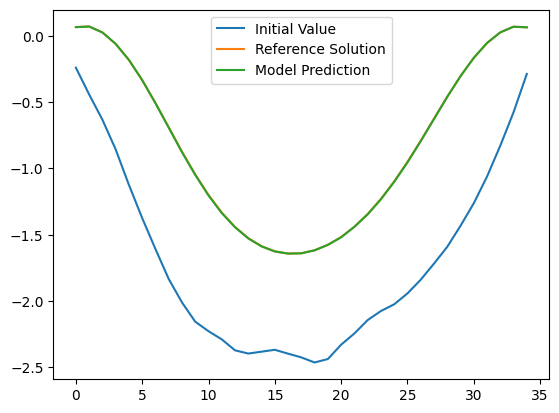

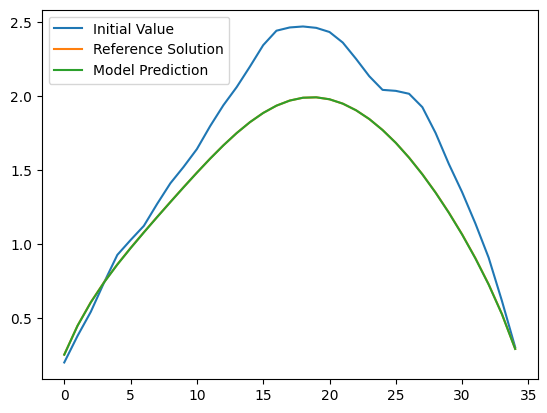

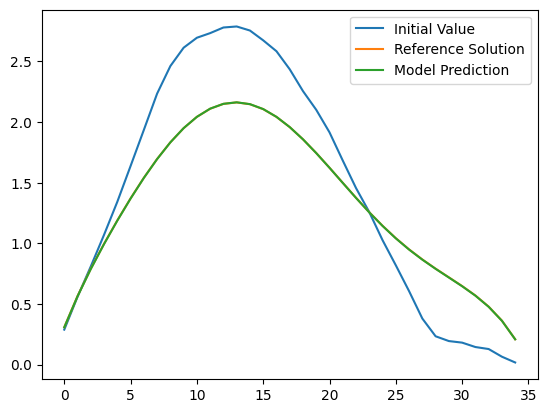

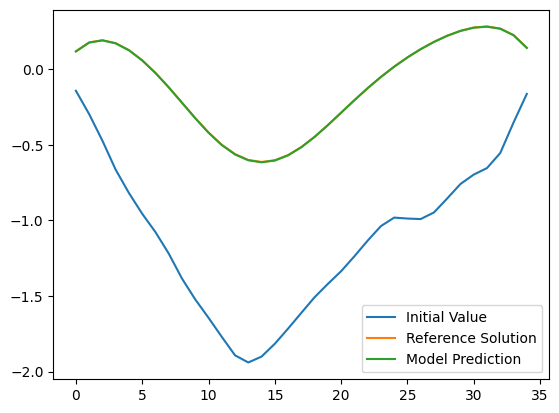

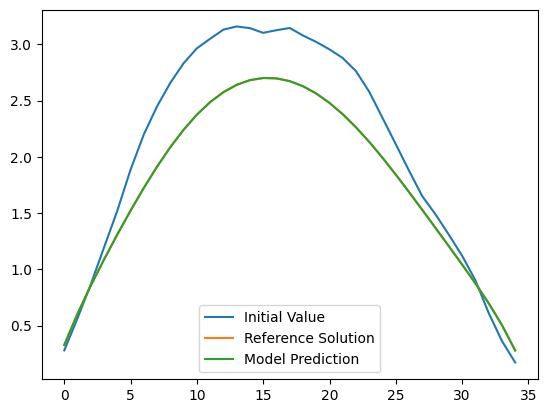

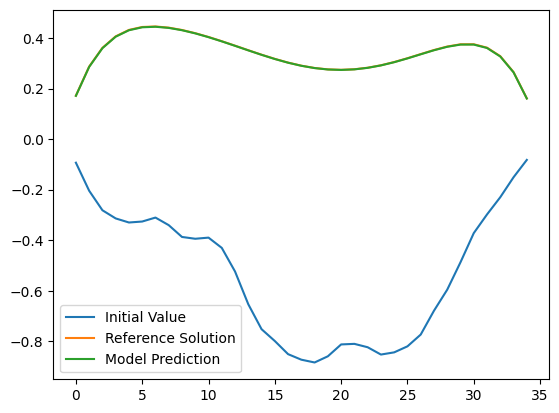

In [6]:
#Store the results
std_foldername = "Results_std"
if not os.path.exists(std_foldername):
        os.makedirs(std_foldername)
        

with open(std_foldername + '/Classical_LIRK_results.txt', 'w+') as f:
    for nr_tsteps in nr_classical_timesteps:
        
        second_order_lirk_model = Second_order_LIRK_model(T, 
                                                          pde,
                                                          nr_spacediscr,
                                                          nr_tsteps, 
                                                          [classical_p1s, classical_p2s],
                                                          training_samples_generator)
        
        error = evaluate(second_order_lirk_model, evaluate_samples = end_eval_samples)
        if nr_tsteps == nr_timesteps_classical_reference:
            classical_reference_error = error
        summary(second_order_lirk_model, write_file=f, plot_file_name = std_foldername + "/plot_LIRK_standard_" + str(nr_tsteps))
        csv_summary(second_order_lirk_model, std_foldername + "/LIRK_standard_" + str(nr_tsteps))


## ADANN Experiments

#### ADANN Experiment 1: Grid based approach

---------NEW RUN---------  i, j =  0 0
------ TRAINING BASE------


2023-01-25 16:42:37.750965: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x42c3f190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 16:42:37.751019: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 16:42:37.760145: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 16:42:38.023564: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0  :  5.956e-06
10  :  3.641e-06
20  :  2.71e-06
30  :  1.861e-06
40  :  1.609e-06
50  :  1.504e-06
60  :  1.333e-06
70  :  1.259e-06
80  :  1.078e-06
90  :  1.128e-06
100  :  1.082e-06
110  :  9.984e-07
120  :  9.535e-07
130  :  9.122e-07
140  :  7.422e-07
150  :  8.674e-07
160  :  7.585e-07
170  :  6.655e-07
180  :  6.912e-07
190  :  7.298e-07
200  :  5.851e-07
210  :  5.583e-07
220  :  6.486e-07
230  :  5.725e-07
240  :  5.457e-07
250  :  5.54e-07
260  :  5.38e-07
270  :  5.607e-07
280  :  5.089e-07
290  :  5.442e-07
300  :  4.844e-07
310  :  3.986e-07
320  :  4.598e-07
330  :  5.138e-07
340  :  4.635e-07
350  :  4.575e-07
360  :  4.603e-07
370  :  4.338e-07
380  :  3.871e-07
390  :  3.715e-07
400  :  3.776e-07
410  :  3.715e-07
420  :  3.366e-07
430  :  3.39e-07
440  :  3.672e-07
450  :  3.799e-07
460  :  3.193e-07
470  :  3.222e-07
480  :  3.483e-07
490  :  3.803e-07
500  :  3.164e-07
510  :  3.044e-07
520  :  3.436e-07
530  :  3.099e-07
540  :  3.037e-07
550  :  3.46e-07
560  :  

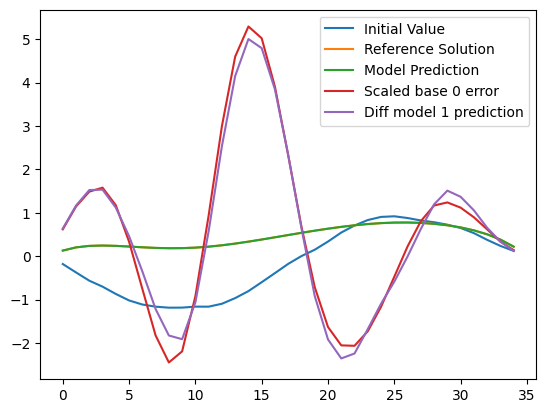

---------NEW RUN---------  i, j =  0 1
------ TRAINING BASE------
0  :  4.928e-06
10  :  3.175e-06
20  :  2.284e-06
30  :  2.103e-06
40  :  1.655e-06
50  :  1.438e-06
60  :  1.478e-06
70  :  1.17e-06
80  :  1.19e-06
90  :  1.024e-06
100  :  9.471e-07
110  :  9.259e-07
120  :  8.871e-07
130  :  7.764e-07
140  :  7.867e-07
150  :  8.346e-07
160  :  7.628e-07
170  :  6.464e-07
180  :  6.686e-07
190  :  6.793e-07
200  :  6.137e-07
210  :  5.831e-07
220  :  6.023e-07
230  :  5.442e-07
240  :  5.695e-07
250  :  5.25e-07
260  :  5.842e-07
270  :  4.719e-07
280  :  4.393e-07
290  :  4.623e-07
300  :  4.905e-07
310  :  4.785e-07
320  :  4.787e-07
330  :  4.289e-07
340  :  4.386e-07
350  :  4.701e-07
360  :  4.317e-07
370  :  4.079e-07
380  :  4.084e-07
390  :  3.792e-07
400  :  3.349e-07
410  :  3.89e-07
420  :  3.609e-07
430  :  3.653e-07
440  :  3.586e-07
450  :  3.889e-07
460  :  3.149e-07
470  :  2.888e-07
480  :  3.57e-07
490  :  3.361e-07
500  :  3.135e-07
510  :  2.936e-07
520  :  3.034e

1910  :  0.01827
1920  :  0.01989
1930  :  0.01816
1940  :  0.01936
1950  :  0.0185
1960  :  0.01813
1970  :  0.01902
1980  :  0.01896
1990  :  0.01776
    New learning rate:  0.0004
    New Batch size:  2048
2000  :  0.01831
2010  :  0.02115
2020  :  0.01852
2030  :  0.01928
2040  :  0.0171
2050  :  0.01769
2060  :  0.01785
2070  :  0.01657
2080  :  0.01628
2090  :  0.01746
2100  :  0.01717
2110  :  0.01762
2120  :  0.01734
Training ended due to inssuficient improvement


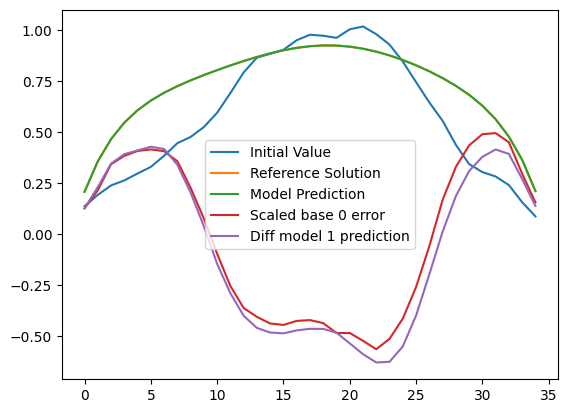

---------NEW RUN---------  i, j =  0 2
------ TRAINING BASE------
0  :  3.85e-06
10  :  2.323e-06
20  :  2.01e-06
30  :  1.678e-06
40  :  1.394e-06
50  :  1.253e-06
60  :  1.147e-06
70  :  1.014e-06
80  :  8.618e-07
90  :  8.569e-07
100  :  9.356e-07
110  :  8.219e-07
120  :  7.324e-07
130  :  6.808e-07
140  :  6.514e-07
150  :  6.51e-07
160  :  6.199e-07
170  :  5.705e-07
180  :  5.642e-07
190  :  5.457e-07
200  :  5.147e-07
210  :  5.15e-07
220  :  4.469e-07
230  :  4.883e-07
240  :  4.403e-07
250  :  4.223e-07
260  :  4.586e-07
270  :  4.332e-07
280  :  4.218e-07
290  :  4.1e-07
300  :  3.768e-07
310  :  3.918e-07
320  :  3.752e-07
330  :  4.172e-07
340  :  3.448e-07
350  :  3.376e-07
360  :  3.525e-07
370  :  3.179e-07
380  :  3.223e-07
390  :  3.211e-07
400  :  3.339e-07
410  :  3.439e-07
420  :  2.853e-07
430  :  3.216e-07
440  :  2.888e-07
450  :  2.58e-07
460  :  2.855e-07
470  :  2.869e-07
480  :  2.869e-07
490  :  2.791e-07
500  :  2.753e-07
510  :  2.609e-07
520  :  2.68e-07

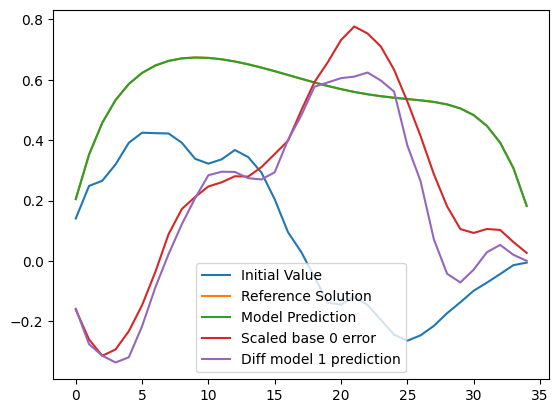

---------NEW RUN---------  i, j =  0 3
------ TRAINING BASE------
0  :  4.02e-06
10  :  1.994e-06
20  :  1.57e-06
30  :  1.441e-06
40  :  1.169e-06
50  :  1.096e-06
60  :  9.93e-07
70  :  8.649e-07
80  :  8.111e-07
90  :  6.897e-07
100  :  6.846e-07
110  :  5.994e-07
120  :  6.151e-07
130  :  5.519e-07
140  :  5.568e-07
150  :  5.523e-07
160  :  5.276e-07
170  :  4.906e-07
180  :  5.043e-07
190  :  4.447e-07
200  :  4.193e-07
210  :  4.045e-07
220  :  4.012e-07
230  :  3.868e-07
240  :  3.742e-07
250  :  3.862e-07
260  :  3.513e-07
270  :  3.51e-07
280  :  3.354e-07
290  :  3.278e-07
300  :  3.25e-07
310  :  3.241e-07
320  :  2.995e-07
330  :  2.91e-07
340  :  2.854e-07
350  :  3.076e-07
360  :  2.849e-07
370  :  2.7e-07
380  :  2.946e-07
390  :  2.971e-07
400  :  2.684e-07
410  :  2.643e-07
420  :  2.647e-07
430  :  2.571e-07
440  :  2.634e-07
450  :  2.482e-07
460  :  2.377e-07
470  :  2.336e-07
480  :  2.069e-07
490  :  2.194e-07
500  :  2.136e-07
510  :  2.338e-07
520  :  2.164e-07

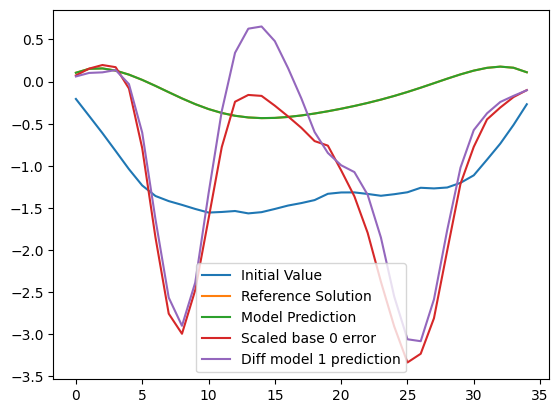

---------NEW RUN---------  i, j =  0 4
------ TRAINING BASE------
0  :  4.569e-06
10  :  1.681e-06
20  :  1.331e-06
30  :  1.213e-06
40  :  1.011e-06
50  :  8.884e-07
60  :  8.432e-07
70  :  7.446e-07
80  :  6.332e-07
90  :  5.873e-07
100  :  5.543e-07
110  :  5.358e-07
120  :  4.814e-07
130  :  4.865e-07
140  :  4.583e-07
150  :  4.098e-07
160  :  3.998e-07
170  :  3.84e-07
180  :  3.86e-07
190  :  3.587e-07
200  :  3.476e-07
210  :  3.401e-07
220  :  3.333e-07
230  :  3.134e-07
240  :  3.259e-07
250  :  3.066e-07
260  :  2.991e-07
270  :  3.011e-07
280  :  2.749e-07
290  :  2.769e-07
300  :  2.718e-07
310  :  2.606e-07
320  :  2.647e-07
330  :  2.783e-07
340  :  2.513e-07
350  :  2.579e-07
360  :  2.355e-07
370  :  2.24e-07
380  :  2.247e-07
390  :  2.12e-07
400  :  2.137e-07
410  :  2.086e-07
420  :  2.128e-07
430  :  1.891e-07
440  :  2.089e-07
450  :  2.092e-07
460  :  1.832e-07
470  :  2.015e-07
480  :  1.963e-07
490  :  1.801e-07
500  :  1.985e-07
510  :  1.766e-07
520  :  2.013

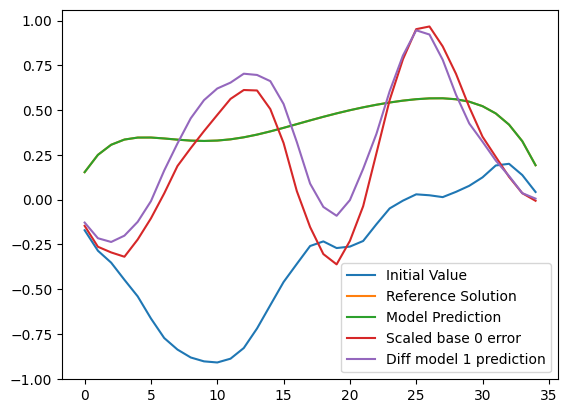

---------NEW RUN---------  i, j =  0 5
------ TRAINING BASE------
0  :  5.317e-06
10  :  1.702e-06
20  :  1.291e-06
30  :  1.112e-06
40  :  8.959e-07
50  :  7.83e-07
60  :  7.281e-07
70  :  6.801e-07
80  :  5.575e-07
90  :  5.244e-07
100  :  4.964e-07
110  :  4.388e-07
120  :  3.927e-07
130  :  3.697e-07
140  :  3.512e-07
150  :  3.44e-07
160  :  3.155e-07
170  :  3.193e-07
180  :  2.766e-07
190  :  2.869e-07
200  :  2.675e-07
210  :  2.853e-07
220  :  2.636e-07
230  :  2.602e-07
240  :  2.492e-07
250  :  2.204e-07
260  :  2.487e-07
270  :  2.368e-07
280  :  2.424e-07
290  :  2.27e-07
300  :  2.124e-07
310  :  2.045e-07
320  :  2.092e-07
330  :  2.073e-07
340  :  2.007e-07
350  :  1.91e-07
360  :  1.921e-07
370  :  1.995e-07
380  :  1.864e-07
390  :  1.761e-07
400  :  1.77e-07
410  :  1.825e-07
420  :  1.779e-07
430  :  1.63e-07
440  :  1.701e-07
450  :  1.642e-07
460  :  1.614e-07
470  :  1.593e-07
480  :  1.572e-07
490  :  1.588e-07
500  :  1.537e-07
510  :  1.522e-07
520  :  1.518e-

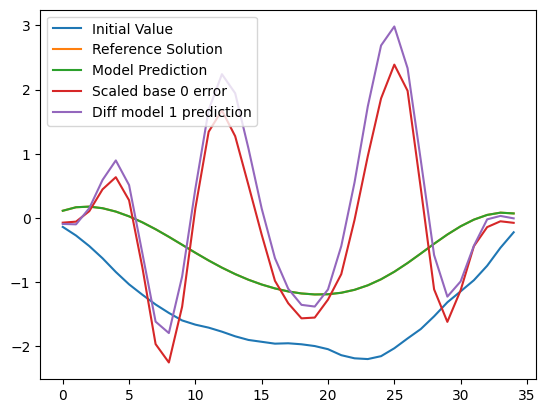

---------NEW RUN---------  i, j =  0 6
------ TRAINING BASE------
0  :  7.554e-06
10  :  2.146e-06
20  :  1.457e-06
30  :  1.275e-06
40  :  1.076e-06
50  :  8.946e-07
60  :  7.899e-07
70  :  6.624e-07
80  :  6.173e-07
90  :  5.39e-07
100  :  4.912e-07
110  :  4.436e-07
120  :  4.137e-07
130  :  3.747e-07
140  :  3.547e-07
150  :  3.255e-07
160  :  3.019e-07
170  :  2.837e-07
180  :  2.765e-07
190  :  2.552e-07
200  :  2.474e-07
210  :  2.243e-07
220  :  2.239e-07
230  :  2.285e-07
240  :  2.214e-07
250  :  2.168e-07
260  :  2.066e-07
270  :  2.029e-07
280  :  2.001e-07
290  :  1.901e-07
300  :  1.806e-07
310  :  1.893e-07
320  :  1.816e-07
330  :  1.81e-07
340  :  1.686e-07
350  :  1.709e-07
360  :  1.783e-07
370  :  1.729e-07
380  :  1.61e-07
390  :  1.629e-07
400  :  1.643e-07
410  :  1.618e-07
420  :  1.544e-07
430  :  1.562e-07
440  :  1.508e-07
450  :  1.44e-07
460  :  1.497e-07
470  :  1.436e-07
480  :  1.479e-07
490  :  1.303e-07
500  :  1.31e-07
510  :  1.343e-07
520  :  1.382e

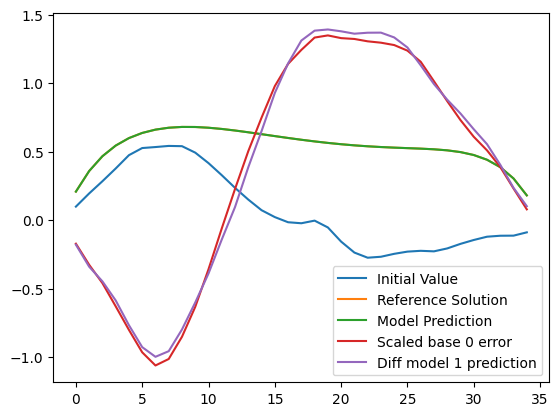

---------NEW RUN---------  i, j =  0 7
------ TRAINING BASE------
0  :  9.469e-06
10  :  3.139e-06
20  :  1.86e-06
30  :  1.753e-06
40  :  1.431e-06
50  :  1.198e-06
60  :  1.112e-06
70  :  9.435e-07
80  :  8.23e-07
90  :  7.495e-07
100  :  6.547e-07
110  :  5.858e-07
120  :  5.763e-07
130  :  4.917e-07
140  :  4.552e-07
150  :  4.352e-07
160  :  4.254e-07
170  :  3.942e-07
180  :  3.331e-07
190  :  3.395e-07
200  :  3.377e-07
210  :  2.79e-07
220  :  2.884e-07
230  :  2.609e-07
240  :  2.613e-07
250  :  2.628e-07
260  :  2.416e-07
270  :  2.32e-07
280  :  2.223e-07
290  :  2.197e-07
300  :  2.032e-07
310  :  2.099e-07
320  :  2.052e-07
330  :  1.956e-07
340  :  1.985e-07
350  :  1.871e-07
360  :  1.742e-07
370  :  1.758e-07
380  :  1.849e-07
390  :  1.783e-07
400  :  1.834e-07
410  :  1.665e-07
420  :  1.534e-07
430  :  1.587e-07
440  :  1.623e-07
450  :  1.508e-07
460  :  1.538e-07
470  :  1.647e-07
480  :  1.488e-07
490  :  1.443e-07
500  :  1.443e-07
510  :  1.424e-07
520  :  1.489

1510  :  0.01218
1520  :  0.01276
1530  :  0.01177
1540  :  0.01559
1550  :  0.01296
1560  :  0.0116
1570  :  0.01185
1580  :  0.01049
1590  :  0.01197
1600  :  0.01013
1610  :  0.01429
1620  :  0.01062
1630  :  0.01324
1640  :  0.01114
1650  :  0.011
1660  :  0.0109
1670  :  0.01302
1680  :  0.01323
1690  :  0.01543
1700  :  0.01155
1710  :  0.0117
1720  :  0.01241
1730  :  0.01217
1740  :  0.01404
1750  :  0.01447
1760  :  0.01042
1770  :  0.01086
1780  :  0.01027
1790  :  0.01531
1800  :  0.01047
1810  :  0.01217
1820  :  0.01091
1830  :  0.01108
1840  :  0.01194
1850  :  0.0108
1860  :  0.01078
1870  :  0.01309
1880  :  0.01249
1890  :  0.01048
1900  :  0.01249
1910  :  0.01284
1920  :  0.01062
1930  :  0.01172
1940  :  0.01102
1950  :  0.01036
1960  :  0.0105
1970  :  0.01132
1980  :  0.009375
1990  :  0.01042
2000  :  0.011
2010  :  0.009264
2020  :  0.01233
2030  :  0.009451
2040  :  0.01001
2050  :  0.01135
2060  :  0.0105
2070  :  0.01158
2080  :  0.0102
2090  :  0.01205
2100 

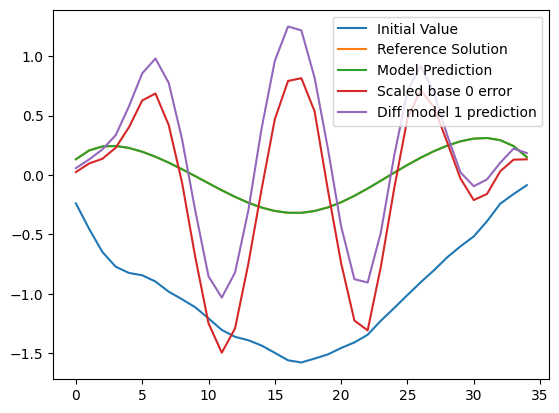

---------NEW RUN---------  i, j =  0 8
------ TRAINING BASE------
0  :  1.282e-05
10  :  4.862e-06
20  :  2.852e-06
30  :  2.482e-06
40  :  2.173e-06
50  :  1.815e-06
60  :  1.592e-06
70  :  1.387e-06
80  :  1.217e-06
90  :  1.174e-06
100  :  9.846e-07
110  :  9.901e-07
120  :  8.685e-07
130  :  7.668e-07
140  :  7.473e-07
150  :  6.804e-07
160  :  6.532e-07
170  :  5.949e-07
180  :  5.757e-07
190  :  5.326e-07
200  :  5.075e-07
210  :  5.146e-07
220  :  4.774e-07
230  :  4.716e-07
240  :  4.102e-07
250  :  4.114e-07
260  :  4.084e-07
270  :  3.63e-07
280  :  3.573e-07
290  :  3.24e-07
300  :  3.309e-07
310  :  3.229e-07
320  :  3.048e-07
330  :  3.057e-07
340  :  2.812e-07
350  :  3.21e-07
360  :  2.564e-07
370  :  2.734e-07
380  :  2.628e-07
390  :  2.502e-07
400  :  2.64e-07
410  :  2.526e-07
420  :  2.311e-07
430  :  2.532e-07
440  :  2.456e-07
450  :  2.209e-07
460  :  2.247e-07
470  :  2.062e-07
480  :  2.066e-07
490  :  1.953e-07
500  :  2.041e-07
510  :  1.888e-07
520  :  2.031

280  :  0.1125
290  :  0.1305
300  :  0.1317
310  :  0.1269
320  :  0.1087
330  :  0.07997
340  :  0.09902
350  :  0.1017
360  :  0.08372
370  :  0.07501
380  :  0.07146
390  :  0.08546
400  :  0.08851
410  :  0.1021
420  :  0.08895
430  :  0.08029
440  :  0.08829
450  :  0.06044
460  :  0.06544
470  :  0.06991
480  :  0.06172
490  :  0.05688
500  :  0.07074
510  :  0.06958
520  :  0.04554
530  :  0.04637
540  :  0.05007
550  :  0.04908
560  :  0.06323
570  :  0.05093
580  :  0.08399
590  :  0.05053
600  :  0.04687
610  :  0.05437
620  :  0.05942
630  :  0.03315
640  :  0.04988
650  :  0.03732
660  :  0.05724
670  :  0.0414
680  :  0.03902
690  :  0.04552
700  :  0.0503
710  :  0.03487
720  :  0.0354
730  :  0.03563
740  :  0.03628
750  :  0.03032
760  :  0.02516
770  :  0.03501
780  :  0.03467
790  :  0.03427
800  :  0.04234
810  :  0.06283
820  :  0.043
830  :  0.03448
840  :  0.04634
850  :  0.02696
860  :  0.02594
870  :  0.05126
880  :  0.0273
    New learning rate:  0.002
    New

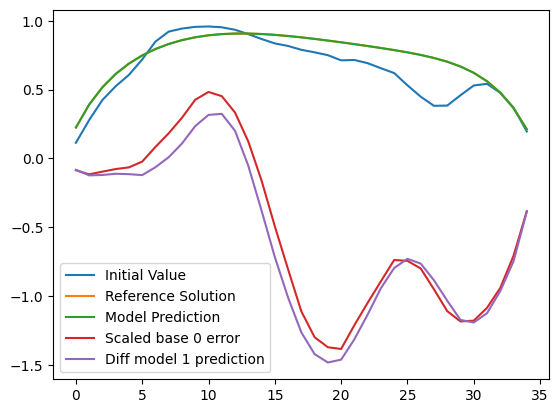

---------NEW RUN---------  i, j =  1 0
------ TRAINING BASE------
0  :  5.663e-06
10  :  3.769e-06
20  :  2.695e-06
30  :  2.185e-06
40  :  1.739e-06
50  :  1.647e-06
60  :  1.394e-06
70  :  1.301e-06
80  :  1.141e-06
90  :  1.176e-06
100  :  9.99e-07
110  :  9.6e-07
120  :  9.279e-07
130  :  9.409e-07
140  :  8.707e-07
150  :  7.965e-07
160  :  8.045e-07
170  :  7.202e-07
180  :  7.214e-07
190  :  6.465e-07
200  :  6.738e-07
210  :  7.335e-07
220  :  6.364e-07
230  :  6.134e-07
240  :  5.918e-07
250  :  5.508e-07
260  :  5.17e-07
270  :  5.216e-07
280  :  5.026e-07
290  :  5.616e-07
300  :  5.144e-07
310  :  5.114e-07
320  :  5.234e-07
330  :  5.194e-07
340  :  4.933e-07
350  :  4.679e-07
360  :  4.701e-07
370  :  4.543e-07
380  :  5.218e-07
390  :  4.322e-07
400  :  3.71e-07
410  :  4.189e-07
420  :  3.984e-07
430  :  4.33e-07
440  :  4.277e-07
450  :  3.914e-07
460  :  4.329e-07
470  :  4.206e-07
480  :  3.684e-07
490  :  3.769e-07
500  :  3.288e-07
510  :  3.872e-07
520  :  3.626e-

3170  :  0.2342
3180  :  0.2348
3190  :  0.2345
3200  :  0.235
3210  :  0.2316
3220  :  0.2324
3230  :  0.235
3240  :  0.2328
3250  :  0.2325
3260  :  0.2391
3270  :  0.2346
3280  :  0.2338
3290  :  0.2375
3300  :  0.2385
3310  :  0.238
    New learning rate:  1.6000000000000003e-05
3320  :  0.2348
3330  :  0.2349
3340  :  0.2349
3350  :  0.2353
3360  :  0.2353
3370  :  0.2365
3380  :  0.234
3390  :  0.237
3400  :  0.2357
3410  :  0.234
3420  :  0.2345
3430  :  0.2337
3440  :  0.2353
Training ended due to inssuficient improvement


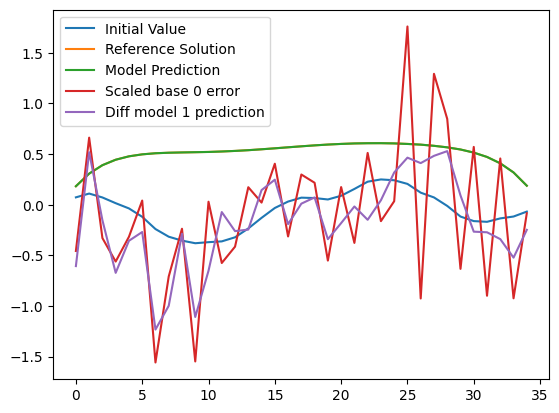

---------NEW RUN---------  i, j =  1 1
------ TRAINING BASE------
0  :  4.355e-06
10  :  3.161e-06
20  :  2.538e-06
30  :  1.974e-06
40  :  1.746e-06
50  :  1.566e-06
60  :  1.529e-06
70  :  1.139e-06
80  :  1.11e-06
90  :  1.145e-06
100  :  1.074e-06
110  :  9.861e-07
120  :  8.865e-07
130  :  8.967e-07
140  :  8.363e-07
150  :  7.943e-07
160  :  7.728e-07
170  :  7.076e-07
180  :  7.263e-07
190  :  7.076e-07
200  :  7.527e-07
210  :  6.16e-07
220  :  5.926e-07
230  :  6.419e-07
240  :  6.363e-07
250  :  5.956e-07
260  :  5.462e-07
270  :  5.509e-07
280  :  5.123e-07
290  :  4.321e-07
300  :  5.036e-07
310  :  4.891e-07
320  :  5.177e-07
330  :  4.589e-07
340  :  5.242e-07
350  :  4.503e-07
360  :  4.553e-07
370  :  4.259e-07
380  :  4.391e-07
390  :  4.06e-07
400  :  4.157e-07
410  :  4.142e-07
420  :  4.233e-07
430  :  4.208e-07
440  :  3.91e-07
450  :  3.748e-07
460  :  3.804e-07
470  :  3.645e-07
480  :  4.031e-07
490  :  3.854e-07
500  :  3.428e-07
510  :  3.241e-07
520  :  3.705

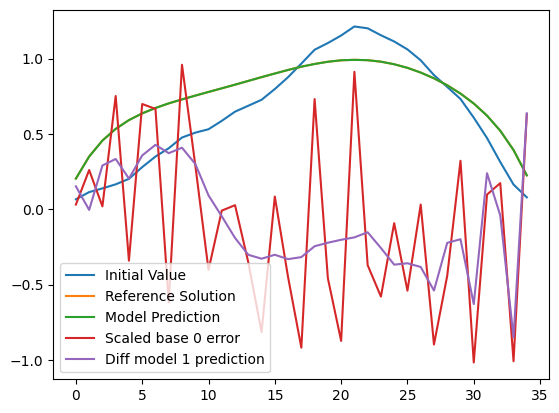

---------NEW RUN---------  i, j =  1 2
------ TRAINING BASE------
0  :  3.455e-06
10  :  2.254e-06
20  :  2.013e-06
30  :  1.602e-06
40  :  1.439e-06
50  :  1.28e-06
60  :  1.135e-06
70  :  9.368e-07
80  :  9.543e-07
90  :  8.547e-07
100  :  8.697e-07
110  :  8.36e-07
120  :  7.291e-07
130  :  7.48e-07
140  :  6.805e-07
150  :  6.375e-07
160  :  6.599e-07
170  :  5.93e-07
180  :  5.98e-07
190  :  6.303e-07
200  :  5.366e-07
210  :  5.378e-07
220  :  4.82e-07
230  :  4.9e-07
240  :  4.875e-07
250  :  4.406e-07
260  :  4.847e-07
270  :  4.659e-07
280  :  4.653e-07
290  :  4.309e-07
300  :  4.493e-07
310  :  4.066e-07
320  :  3.958e-07
330  :  3.817e-07
340  :  4.147e-07
350  :  3.527e-07
360  :  3.784e-07
370  :  3.581e-07
380  :  3.913e-07
390  :  3.769e-07
400  :  3.477e-07
410  :  3.437e-07
420  :  3.539e-07
430  :  3.506e-07
440  :  3.462e-07
450  :  3.215e-07
460  :  3.35e-07
470  :  3.302e-07
480  :  3.292e-07
490  :  2.934e-07
500  :  3.182e-07
510  :  3.1e-07
520  :  3.313e-07
53

2160  :  0.3855
2170  :  0.3805
2180  :  0.3832
2190  :  0.3774
2200  :  0.3823
2210  :  0.3671
2220  :  0.3636
2230  :  0.3659
2240  :  0.3678
2250  :  0.3665
2260  :  0.3649
2270  :  0.3648
2280  :  0.3628
2290  :  0.3472
2300  :  0.3544
2310  :  0.3607
2320  :  0.3672
2330  :  0.3638
2340  :  0.3623
2350  :  0.3539
2360  :  0.3496
2370  :  0.3459
2380  :  0.3495
2390  :  0.3532
2400  :  0.3477
2410  :  0.3439
2420  :  0.3539
2430  :  0.3526
2440  :  0.3497
2450  :  0.3338
2460  :  0.3489
2470  :  0.3473
2480  :  0.3384
2490  :  0.3537
2500  :  0.3326
2510  :  0.343
2520  :  0.337
2530  :  0.3459
2540  :  0.3408
2550  :  0.3321
2560  :  0.3389
2570  :  0.3356
2580  :  0.3393
2590  :  0.3395
2600  :  0.3394
2610  :  0.3389
2620  :  0.3337
2630  :  0.3474
2640  :  0.3282
2650  :  0.3308
2660  :  0.3208
2670  :  0.3201
2680  :  0.3376
2690  :  0.3238
2700  :  0.3268
2710  :  0.3339
2720  :  0.3191
2730  :  0.3153
2740  :  0.3241
2750  :  0.3169
2760  :  0.3267
2770  :  0.336
2780  :  0.

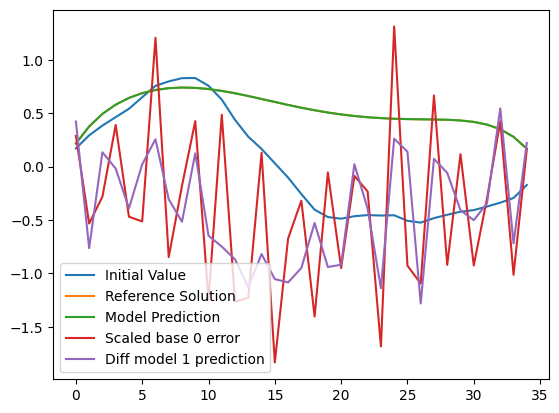

---------NEW RUN---------  i, j =  1 3
------ TRAINING BASE------
0  :  3.097e-06
10  :  1.759e-06
20  :  1.505e-06
30  :  1.302e-06
40  :  1.108e-06
50  :  9.584e-07
60  :  8.635e-07
70  :  8.304e-07
80  :  7.792e-07
90  :  7.179e-07
100  :  6.631e-07
110  :  6.432e-07
120  :  6.128e-07
130  :  5.566e-07
140  :  5.609e-07
150  :  5.14e-07
160  :  5.168e-07
170  :  4.785e-07
180  :  4.769e-07
190  :  4.552e-07
200  :  4.298e-07
210  :  4.246e-07
220  :  4.07e-07
230  :  4.187e-07
240  :  3.954e-07
250  :  3.896e-07
260  :  3.748e-07
270  :  3.645e-07
280  :  3.761e-07
290  :  3.511e-07
300  :  3.483e-07
310  :  3.593e-07
320  :  3.445e-07
330  :  3.247e-07
340  :  3.189e-07
350  :  3.161e-07
360  :  3.131e-07
370  :  2.999e-07
380  :  3.148e-07
390  :  2.957e-07
400  :  2.963e-07
410  :  3.103e-07
420  :  2.857e-07
430  :  2.765e-07
440  :  2.763e-07
450  :  2.724e-07
460  :  2.585e-07
470  :  2.604e-07
480  :  2.696e-07
490  :  2.524e-07
500  :  2.638e-07
510  :  2.458e-07
520  :  2.4

1640  :  0.4956
1650  :  0.484
1660  :  0.4797
1670  :  0.4984
1680  :  0.4855
1690  :  0.4929
1700  :  0.4842
1710  :  0.4783
1720  :  0.4828
1730  :  0.4771
1740  :  0.4762
1750  :  0.4809
1760  :  0.4799
1770  :  0.4785
1780  :  0.4819
1790  :  0.4789
1800  :  0.476
1810  :  0.4663
1820  :  0.4669
1830  :  0.4744
1840  :  0.4757
1850  :  0.4687
1860  :  0.4669
1870  :  0.4658
1880  :  0.4615
1890  :  0.4663
1900  :  0.473
1910  :  0.462
1920  :  0.4676
1930  :  0.4487
1940  :  0.4766
1950  :  0.4619
1960  :  0.4564
1970  :  0.4696
1980  :  0.4651
1990  :  0.4636
2000  :  0.4546
2010  :  0.459
2020  :  0.4625
2030  :  0.4592
2040  :  0.4556
2050  :  0.4602
2060  :  0.46
2070  :  0.4472
2080  :  0.4522
2090  :  0.4499
2100  :  0.4529
2110  :  0.4378
2120  :  0.442
2130  :  0.4447
2140  :  0.4454
2150  :  0.4403
2160  :  0.4401
2170  :  0.455
2180  :  0.4481
2190  :  0.4566
2200  :  0.4393
2210  :  0.4321
2220  :  0.4363
2230  :  0.4335
2240  :  0.4477
2250  :  0.4435
2260  :  0.4348
2

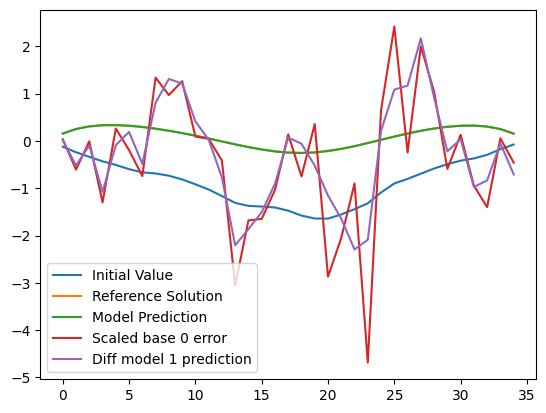

---------NEW RUN---------  i, j =  1 4
------ TRAINING BASE------
0  :  3.732e-06
10  :  1.273e-06
20  :  1.272e-06
30  :  1.035e-06
40  :  9.524e-07
50  :  8.07e-07
60  :  7.294e-07
70  :  6.567e-07
80  :  6.493e-07
90  :  5.22e-07
100  :  4.832e-07
110  :  5.187e-07
120  :  4.727e-07
130  :  4.397e-07
140  :  4.179e-07
150  :  4.33e-07
160  :  3.745e-07
170  :  4.111e-07
180  :  3.725e-07
190  :  3.657e-07
200  :  3.871e-07
210  :  3.329e-07
220  :  3.44e-07
230  :  3.396e-07
240  :  3.231e-07
250  :  3.308e-07
260  :  3.018e-07
270  :  3.234e-07
280  :  3.351e-07
290  :  2.92e-07
300  :  2.989e-07
310  :  2.858e-07
320  :  2.861e-07
330  :  2.686e-07
340  :  2.74e-07
350  :  2.648e-07
360  :  2.459e-07
370  :  2.57e-07
380  :  2.621e-07
390  :  2.459e-07
400  :  2.592e-07
410  :  2.564e-07
420  :  2.473e-07
430  :  2.322e-07
440  :  2.245e-07
450  :  2.167e-07
460  :  2.36e-07
470  :  2.379e-07
480  :  2.241e-07
490  :  2.252e-07
500  :  2.264e-07
510  :  2.295e-07
520  :  2.26e-07


1850  :  0.4135
1860  :  0.4334
1870  :  0.4154
1880  :  0.4352
1890  :  0.4076
1900  :  0.4193
1910  :  0.4097
1920  :  0.4062
1930  :  0.4274
1940  :  0.4075
1950  :  0.4093
1960  :  0.4067
1970  :  0.4616
1980  :  0.4157
1990  :  0.4092
2000  :  0.4047
2010  :  0.406
2020  :  0.3863
2030  :  0.398
2040  :  0.4076
2050  :  0.3902
2060  :  0.3999
2070  :  0.4138
2080  :  0.3987
2090  :  0.3947
2100  :  0.3769
2110  :  0.402
2120  :  0.3871
2130  :  0.3836
2140  :  0.3812
2150  :  0.4171
2160  :  0.3879
2170  :  0.3868
2180  :  0.3876
2190  :  0.3877
2200  :  0.3876
2210  :  0.3986
2220  :  0.3728
2230  :  0.3806
2240  :  0.3849
2250  :  0.3719
2260  :  0.3899
2270  :  0.3754
2280  :  0.3891
2290  :  0.3806
    New learning rate:  0.0004
    New Batch size:  2048
2300  :  0.375
2310  :  0.3682
2320  :  0.3719
2330  :  0.3765
2340  :  0.3679
2350  :  0.3728
2360  :  0.3726
2370  :  0.3761
2380  :  0.3643
2390  :  0.3637
2400  :  0.3692
2410  :  0.3687
2420  :  0.3665
2430  :  0.3728
244

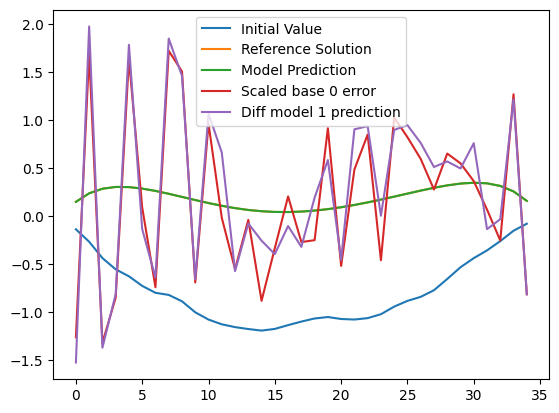

---------NEW RUN---------  i, j =  1 5
------ TRAINING BASE------
0  :  4.586e-06
10  :  1.301e-06
20  :  1.101e-06
30  :  9.076e-07
40  :  7.695e-07
50  :  6.711e-07
60  :  6.559e-07
70  :  5.616e-07
80  :  5.005e-07
90  :  4.692e-07
100  :  4.374e-07
110  :  4.216e-07
120  :  3.878e-07
130  :  3.529e-07
140  :  3.418e-07
150  :  3.214e-07
160  :  3.293e-07
170  :  3.076e-07
180  :  3.04e-07
190  :  2.834e-07
200  :  2.807e-07
210  :  2.859e-07
220  :  2.749e-07
230  :  2.711e-07
240  :  2.639e-07
250  :  2.589e-07
260  :  2.531e-07
270  :  2.649e-07
280  :  2.437e-07
290  :  2.41e-07
300  :  2.424e-07
310  :  2.332e-07
320  :  2.295e-07
330  :  2.337e-07
340  :  2.222e-07
350  :  2.124e-07
360  :  2.215e-07
370  :  2.013e-07
380  :  2.133e-07
390  :  2.055e-07
400  :  1.99e-07
410  :  2.009e-07
420  :  2.16e-07
430  :  1.939e-07
440  :  1.961e-07
450  :  1.943e-07
460  :  1.972e-07
470  :  1.985e-07
480  :  1.958e-07
490  :  1.803e-07
500  :  1.974e-07
510  :  1.86e-07
520  :  1.956e

2800  :  0.3269
2810  :  0.3071
2820  :  0.3115
2830  :  0.3186
2840  :  0.3273
2850  :  0.3101
2860  :  0.3628
2870  :  0.3154
2880  :  0.3048
2890  :  0.306
2900  :  0.3129
2910  :  0.3052
2920  :  0.2968
2930  :  0.3168
2940  :  0.31
2950  :  0.3132
2960  :  0.3013
2970  :  0.2968
2980  :  0.311
2990  :  0.3163
3000  :  0.2991
3010  :  0.3117
3020  :  0.3125
3030  :  0.3072
3040  :  0.3045
3050  :  0.2982
3060  :  0.2912
3070  :  0.2955
3080  :  0.2958
3090  :  0.304
3100  :  0.3048
3110  :  0.3003
    New learning rate:  0.0004
    New Batch size:  2048
3120  :  0.3054
3130  :  0.2977
3140  :  0.2918
3150  :  0.291
3160  :  0.2971
3170  :  0.2907
3180  :  0.292
3190  :  0.2954
3200  :  0.2892
3210  :  0.2948
3220  :  0.2866
3230  :  0.2911
3240  :  0.2933
3250  :  0.2953
3260  :  0.2911
3270  :  0.2941
3280  :  0.2934
3290  :  0.2916
3300  :  0.2853
3310  :  0.287
3320  :  0.2868
3330  :  0.2896
3340  :  0.2898
3350  :  0.2889
3360  :  0.2907
3370  :  0.2888
3380  :  0.2949
3390  :

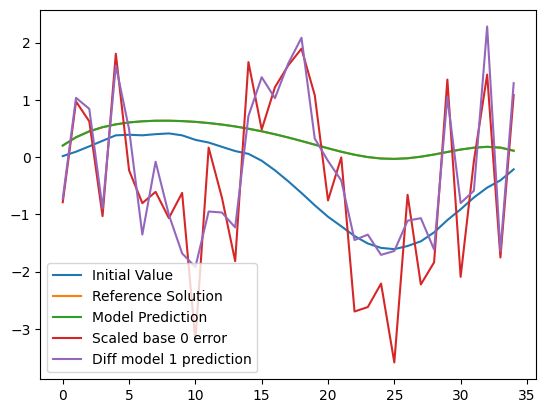

---------NEW RUN---------  i, j =  1 6
------ TRAINING BASE------
0  :  5.825e-06
10  :  1.527e-06
20  :  1.232e-06
30  :  1.031e-06
40  :  8.116e-07
50  :  7.174e-07
60  :  6.467e-07
70  :  5.906e-07
80  :  4.93e-07
90  :  4.363e-07
100  :  3.898e-07
110  :  3.636e-07
120  :  3.609e-07
130  :  3.256e-07
140  :  3.098e-07
150  :  2.949e-07
160  :  2.833e-07
170  :  2.739e-07
180  :  2.523e-07
190  :  2.458e-07
200  :  2.285e-07
210  :  2.288e-07
220  :  2.239e-07
230  :  2.155e-07
240  :  2.125e-07
250  :  2.243e-07
260  :  2.11e-07
270  :  2.072e-07
280  :  1.987e-07
290  :  2.002e-07
300  :  2.011e-07
310  :  1.922e-07
320  :  1.913e-07
330  :  1.832e-07
340  :  1.94e-07
350  :  1.866e-07
360  :  1.929e-07
370  :  1.983e-07
380  :  1.917e-07
390  :  1.804e-07
400  :  1.802e-07
410  :  1.809e-07
420  :  1.839e-07
430  :  1.737e-07
440  :  1.75e-07
450  :  1.62e-07
460  :  1.668e-07
470  :  1.723e-07
480  :  1.74e-07
490  :  1.703e-07
500  :  1.716e-07
510  :  1.664e-07
520  :  1.669e-

1730  :  0.5009
1740  :  0.4948
1750  :  0.4986
1760  :  0.5005
1770  :  0.4889
1780  :  0.4919
1790  :  0.4932
1800  :  0.4874
1810  :  0.5006
1820  :  0.5063
1830  :  0.5014
1840  :  0.4909
1850  :  0.4924
1860  :  0.4942
1870  :  0.4949
1880  :  0.4998
1890  :  0.4854
1900  :  0.477
1910  :  0.4801
1920  :  0.4836
1930  :  0.4785
1940  :  0.4779
1950  :  0.4727
1960  :  0.4766
1970  :  0.4853
1980  :  0.4744
1990  :  0.497
2000  :  0.4744
2010  :  0.4659
2020  :  0.478
2030  :  0.4731
2040  :  0.4694
2050  :  0.4698
2060  :  0.4701
2070  :  0.4644
2080  :  0.48
2090  :  0.4602
2100  :  0.4551
2110  :  0.4809
2120  :  0.4715
2130  :  0.467
2140  :  0.4594
2150  :  0.4695
2160  :  0.458
2170  :  0.4674
2180  :  0.4531
2190  :  0.4462
2200  :  0.4523
2210  :  0.4786
2220  :  0.4491
2230  :  0.4528
2240  :  0.4706
2250  :  0.4566
2260  :  0.4383
2270  :  0.4495
2280  :  0.4436
2290  :  0.4587
2300  :  0.4805
2310  :  0.4507
2320  :  0.4487
2330  :  0.4445
2340  :  0.4389
2350  :  0.4557

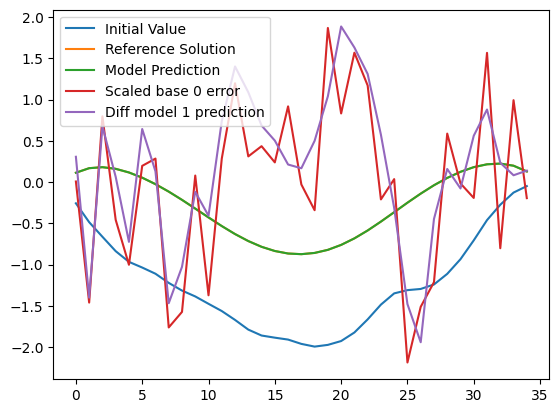

---------NEW RUN---------  i, j =  1 7
------ TRAINING BASE------
0  :  8.294e-06
10  :  2.37e-06
20  :  1.545e-06
30  :  1.491e-06
40  :  1.123e-06
50  :  1.051e-06
60  :  8.258e-07
70  :  7.539e-07
80  :  6.719e-07
90  :  5.879e-07
100  :  5.373e-07
110  :  4.949e-07
120  :  4.515e-07
130  :  4.207e-07
140  :  3.856e-07
150  :  3.51e-07
160  :  3.374e-07
170  :  3.152e-07
180  :  3.057e-07
190  :  2.812e-07
200  :  2.678e-07
210  :  2.638e-07
220  :  2.459e-07
230  :  2.448e-07
240  :  2.42e-07
250  :  2.373e-07
260  :  2.418e-07
270  :  2.239e-07
280  :  2.106e-07
290  :  2.23e-07
300  :  2.082e-07
310  :  2.045e-07
320  :  2.04e-07
330  :  2.091e-07
340  :  2.041e-07
350  :  1.895e-07
360  :  1.939e-07
370  :  1.891e-07
380  :  1.914e-07
390  :  1.91e-07
400  :  1.755e-07
410  :  1.807e-07
420  :  1.758e-07
430  :  1.89e-07
440  :  1.81e-07
450  :  1.778e-07
460  :  1.736e-07
470  :  1.708e-07
480  :  1.622e-07
490  :  1.689e-07
500  :  1.643e-07
510  :  1.675e-07
520  :  1.584e-07

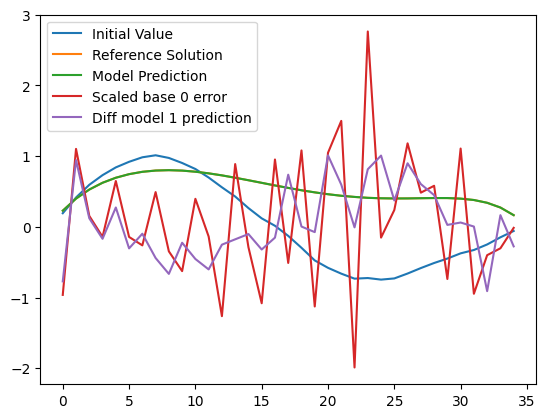

---------NEW RUN---------  i, j =  1 8
------ TRAINING BASE------
0  :  1.086e-05
10  :  3.914e-06
20  :  2.27e-06
30  :  2.107e-06
40  :  1.725e-06
50  :  1.619e-06
60  :  1.386e-06
70  :  1.211e-06
80  :  1.085e-06
90  :  9.539e-07
100  :  8.572e-07
110  :  8.169e-07
120  :  7.374e-07
130  :  6.527e-07
140  :  5.966e-07
150  :  5.703e-07
160  :  5.764e-07
170  :  5.042e-07
180  :  5.18e-07
190  :  4.827e-07
200  :  4.473e-07
210  :  4.001e-07
220  :  3.899e-07
230  :  3.787e-07
240  :  3.57e-07
250  :  3.497e-07
260  :  3.443e-07
270  :  3.146e-07
280  :  2.982e-07
290  :  3.076e-07
300  :  2.876e-07
310  :  3.065e-07
320  :  2.749e-07
330  :  2.988e-07
340  :  2.898e-07
350  :  2.768e-07
360  :  2.627e-07
370  :  2.522e-07
380  :  2.64e-07
390  :  2.587e-07
400  :  2.418e-07
410  :  2.411e-07
420  :  2.391e-07
430  :  2.427e-07
440  :  2.336e-07
450  :  2.119e-07
460  :  2.321e-07
470  :  2.116e-07
480  :  2.158e-07
490  :  2.065e-07
500  :  2.147e-07
510  :  2.206e-07
520  :  2.065

2070  :  0.4399
2080  :  0.4525
2090  :  0.4436
2100  :  0.4493
2110  :  0.445
2120  :  0.4385
2130  :  0.4373
2140  :  0.4312
2150  :  0.438
2160  :  0.4361
2170  :  0.4316
2180  :  0.4195
2190  :  0.425
2200  :  0.4307
2210  :  0.4156
2220  :  0.424
2230  :  0.4221
2240  :  0.4133
2250  :  0.4218
2260  :  0.4347
2270  :  0.4196
2280  :  0.419
2290  :  0.4156
2300  :  0.4271
2310  :  0.4964
2320  :  0.4533
2330  :  0.4156
2340  :  0.4144
2350  :  0.4127
2360  :  0.4042
2370  :  0.4169
2380  :  0.4195
2390  :  0.4149
2400  :  0.4028
2410  :  0.4393
2420  :  0.4167
2430  :  0.4054
2440  :  0.4033
2450  :  0.4008
2460  :  0.4176
2470  :  0.4206
2480  :  0.4031
2490  :  0.4066
2500  :  0.4128
2510  :  0.3933
2520  :  0.403
2530  :  0.4055
2540  :  0.396
2550  :  0.3845
2560  :  0.3833
2570  :  0.3976
2580  :  0.3908
2590  :  0.4051
2600  :  0.4037
2610  :  0.3784
2620  :  0.399
2630  :  0.3861
2640  :  0.3982
2650  :  0.3902
2660  :  0.3852
2670  :  0.4253
2680  :  0.3952
2690  :  0.3955


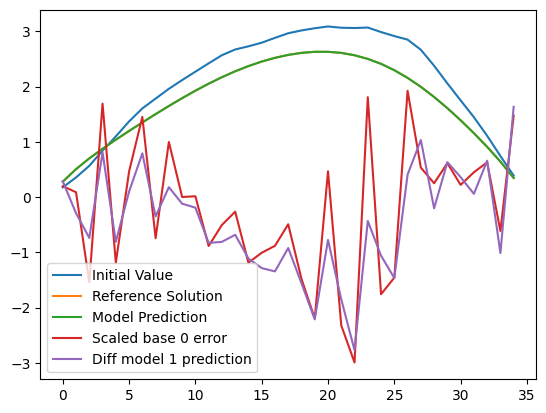

---------NEW RUN---------  i, j =  2 0
------ TRAINING BASE------
0  :  5.338e-06
10  :  3.713e-06
20  :  3.029e-06
30  :  2.281e-06
40  :  1.903e-06
50  :  1.593e-06
60  :  1.498e-06
70  :  1.537e-06
80  :  1.315e-06
90  :  1.272e-06
100  :  1.185e-06
110  :  1.141e-06
120  :  1.248e-06
130  :  1.072e-06
140  :  1.088e-06
150  :  9.224e-07
160  :  9.61e-07
170  :  8.842e-07
180  :  8.253e-07
190  :  8.479e-07
200  :  8.551e-07
210  :  8.37e-07
220  :  7.841e-07
230  :  8.152e-07
240  :  6.968e-07
250  :  7.21e-07
260  :  7.256e-07
270  :  7.429e-07
280  :  6.969e-07
290  :  7.366e-07
300  :  6.595e-07
310  :  6.501e-07
320  :  6.915e-07
330  :  6.374e-07
340  :  6.653e-07
350  :  6.587e-07
360  :  6.398e-07
370  :  6.541e-07
380  :  5.967e-07
390  :  6.199e-07
400  :  5.72e-07
410  :  5.529e-07
420  :  5.898e-07
430  :  5.89e-07
440  :  6.232e-07
450  :  5.51e-07
460  :  5.605e-07
470  :  5.291e-07
480  :  5.535e-07
490  :  5.428e-07
500  :  5.309e-07
510  :  5.564e-07
520  :  5.275e-

2970  :  0.4006
Training ended due to inssuficient improvement


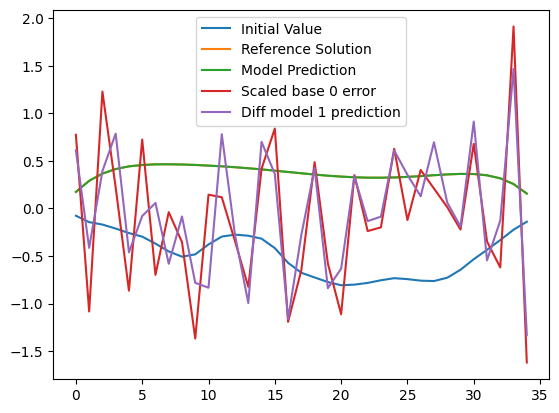

---------NEW RUN---------  i, j =  2 1
------ TRAINING BASE------
0  :  4.182e-06
10  :  3.21e-06
20  :  2.598e-06
30  :  2.152e-06
40  :  1.85e-06
50  :  1.756e-06
60  :  1.596e-06
70  :  1.385e-06
80  :  1.339e-06
90  :  1.171e-06
100  :  1.043e-06
110  :  1.135e-06
120  :  1.067e-06
130  :  1.061e-06
140  :  1.002e-06
150  :  1.025e-06
160  :  9.406e-07
170  :  9.206e-07
180  :  9.451e-07
190  :  8.645e-07
200  :  8.225e-07
210  :  8.167e-07
220  :  7.858e-07
230  :  8.05e-07
240  :  7.276e-07
250  :  7.095e-07
260  :  7.109e-07
270  :  6.815e-07
280  :  6.609e-07
290  :  7.213e-07
300  :  6.682e-07
310  :  6.691e-07
320  :  6.076e-07
330  :  6.06e-07
340  :  6.133e-07
350  :  6.295e-07
360  :  5.866e-07
370  :  6.523e-07
380  :  6.07e-07
390  :  5.896e-07
400  :  5.656e-07
410  :  5.167e-07
420  :  6.147e-07
430  :  5.463e-07
440  :  5.719e-07
450  :  5.533e-07
460  :  5.087e-07
470  :  5.26e-07
480  :  5.212e-07
490  :  5.185e-07
500  :  5.105e-07
510  :  5.112e-07
520  :  5.481e-

3280  :  0.4764
3290  :  0.4748
3300  :  0.4872
3310  :  0.4666
    New learning rate:  6.400000000000001e-07
3320  :  0.4754
3330  :  0.481
3340  :  0.4772
3350  :  0.4803
3360  :  0.4813
3370  :  0.4797
3380  :  0.4734
3390  :  0.4767
3400  :  0.4811
3410  :  0.4695
3420  :  0.4794
3430  :  0.4777
3440  :  0.4766
3450  :  0.4717
3460  :  0.4767
3470  :  0.4768
3480  :  0.4813
3490  :  0.4812
3500  :  0.4812
3510  :  0.4834
3520  :  0.4781
3530  :  0.4772
3540  :  0.4743
    New learning rate:  1.2800000000000003e-07
3550  :  0.473
3560  :  0.4782
3570  :  0.4775
3580  :  0.4693
3590  :  0.4685
3600  :  0.4744
3610  :  0.4795
3620  :  0.4799
3630  :  0.4721
3640  :  0.4722
3650  :  0.4773
3660  :  0.4829
Training ended due to inssuficient improvement


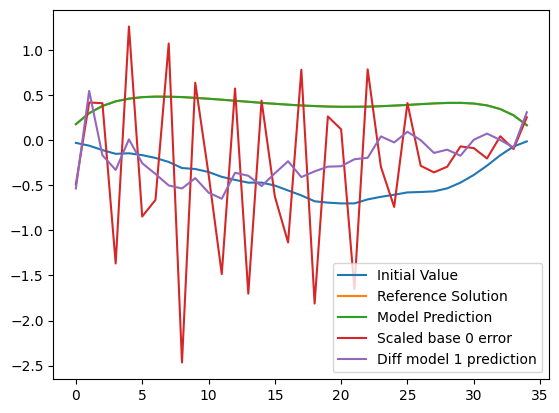

---------NEW RUN---------  i, j =  2 2
------ TRAINING BASE------
0  :  3.261e-06
10  :  2.45e-06
20  :  2.183e-06
30  :  1.687e-06
40  :  1.448e-06
50  :  1.45e-06
60  :  1.283e-06
70  :  1.23e-06
80  :  1.166e-06
90  :  1.132e-06
100  :  1.042e-06
110  :  1.027e-06
120  :  9.533e-07
130  :  9.468e-07
140  :  8.892e-07
150  :  8.606e-07
160  :  8.239e-07
170  :  7.671e-07
180  :  8.028e-07
190  :  7.951e-07
200  :  7.773e-07
210  :  7.722e-07
220  :  7.031e-07
230  :  6.543e-07
240  :  6.706e-07
250  :  6.393e-07
260  :  6.627e-07
270  :  5.976e-07
280  :  6.275e-07
290  :  5.919e-07
300  :  6.046e-07
310  :  6.445e-07
320  :  5.568e-07
330  :  5.491e-07
340  :  5.478e-07
350  :  5.794e-07
360  :  5.3e-07
370  :  5.443e-07
380  :  5.15e-07
390  :  5.344e-07
400  :  5.095e-07
410  :  5.159e-07
420  :  4.951e-07
430  :  5.032e-07
440  :  4.663e-07
450  :  5.159e-07
460  :  4.912e-07
470  :  4.648e-07
480  :  4.798e-07
490  :  4.814e-07
500  :  4.819e-07
510  :  4.529e-07
520  :  4.491e-

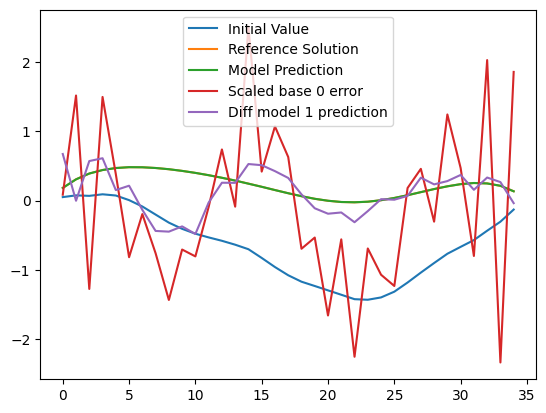

---------NEW RUN---------  i, j =  2 3
------ TRAINING BASE------
0  :  3.05e-06
10  :  1.974e-06
20  :  1.6e-06
30  :  1.486e-06
40  :  1.281e-06
50  :  1.159e-06
60  :  1.034e-06
70  :  9.281e-07
80  :  9.105e-07
90  :  8.695e-07
100  :  8.393e-07
110  :  8.51e-07
120  :  7.789e-07
130  :  7.415e-07
140  :  7.234e-07
150  :  7.067e-07
160  :  6.939e-07
170  :  6.745e-07
180  :  6.094e-07
190  :  5.933e-07
200  :  6.459e-07
210  :  6.013e-07
220  :  5.945e-07
230  :  5.798e-07
240  :  5.729e-07
250  :  5.689e-07
260  :  5.24e-07
270  :  5.257e-07
280  :  5.077e-07
290  :  5.282e-07
300  :  5.007e-07
310  :  5.15e-07
320  :  5.103e-07
330  :  4.874e-07
340  :  4.778e-07
350  :  4.911e-07
360  :  4.759e-07
370  :  4.549e-07
380  :  4.697e-07
390  :  4.612e-07
400  :  4.424e-07
410  :  4.369e-07
420  :  4.331e-07
430  :  4.485e-07
440  :  4.249e-07
450  :  4.257e-07
460  :  4.517e-07
470  :  4.163e-07
480  :  4.145e-07
490  :  4.276e-07
500  :  4.35e-07
510  :  4.242e-07
520  :  4.278e-0

3390  :  0.3191
3400  :  0.3092
3410  :  0.3127
3420  :  0.31
3430  :  0.3092
3440  :  0.3047
3450  :  0.3121
3460  :  0.31
3470  :  0.3145
3480  :  0.3131
3490  :  0.3024
3500  :  0.3065
3510  :  0.3137
3520  :  0.3085
3530  :  0.3102
3540  :  0.3074
3550  :  0.3073
3560  :  0.3075
3570  :  0.3057
3580  :  0.3085
3590  :  0.3052
3600  :  0.3061
3610  :  0.2991
3620  :  0.3017
3630  :  0.2992
3640  :  0.304
3650  :  0.304
3660  :  0.3042
3670  :  0.3017
3680  :  0.3096
3690  :  0.3077
3700  :  0.2921
3710  :  0.3052
3720  :  0.3026
3730  :  0.3097
3740  :  0.3015
3750  :  0.3077
3760  :  0.3011
3770  :  0.304
3780  :  0.3092
3790  :  0.3035
3800  :  0.3015
3810  :  0.3014
3820  :  0.3095
3830  :  0.2998
3840  :  0.2986
3850  :  0.2993
3860  :  0.3053
3870  :  0.304
3880  :  0.3007
3890  :  0.2997
3900  :  0.2974
3910  :  0.3027
3920  :  0.3015
3930  :  0.3021
3940  :  0.2971
3950  :  0.2993
    New learning rate:  8e-05
3960  :  0.2969
3970  :  0.2958
3980  :  0.2952
3990  :  0.2976
40

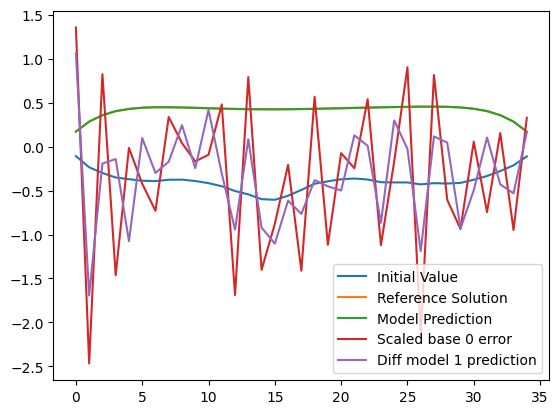

---------NEW RUN---------  i, j =  2 4
------ TRAINING BASE------
0  :  3.23e-06
10  :  1.44e-06
20  :  1.412e-06
30  :  1.076e-06
40  :  1.02e-06
50  :  9.416e-07
60  :  8.547e-07
70  :  7.733e-07
80  :  7.403e-07
90  :  7.451e-07
100  :  6.729e-07
110  :  6.839e-07
120  :  6.349e-07
130  :  6.217e-07
140  :  6.093e-07
150  :  5.865e-07
160  :  5.603e-07
170  :  5.598e-07
180  :  5.304e-07
190  :  5.51e-07
200  :  5.134e-07
210  :  5.38e-07
220  :  4.946e-07
230  :  4.786e-07
240  :  4.992e-07
250  :  4.771e-07
260  :  5.143e-07
270  :  4.858e-07
280  :  4.673e-07
290  :  4.693e-07
300  :  4.474e-07
310  :  4.507e-07
320  :  4.427e-07
330  :  4.33e-07
340  :  4.331e-07
350  :  4.368e-07
360  :  4.273e-07
370  :  4.249e-07
380  :  4.247e-07
390  :  4.144e-07
400  :  4.185e-07
410  :  3.982e-07
420  :  4.144e-07
430  :  3.96e-07
440  :  3.921e-07
450  :  3.938e-07
460  :  3.839e-07
470  :  3.82e-07
480  :  4.015e-07
490  :  3.884e-07
500  :  3.843e-07
510  :  3.911e-07
520  :  3.775e-07

2900  :  0.3081
2910  :  0.3086
2920  :  0.3241
2930  :  0.3093
2940  :  0.3142
2950  :  0.3247
2960  :  0.3367
2970  :  0.3303
2980  :  0.3167
2990  :  0.2921
3000  :  0.3297
3010  :  0.298
3020  :  0.3012
3030  :  0.3208
3040  :  0.2964
3050  :  0.2918
3060  :  0.3051
3070  :  0.3057
3080  :  0.3713
3090  :  0.3134
3100  :  0.294
3110  :  0.3055
3120  :  0.3029
3130  :  0.2964
3140  :  0.2874
3150  :  0.3026
3160  :  0.2954
3170  :  0.2901
3180  :  0.3313
3190  :  0.3159
3200  :  0.2915
3210  :  0.3057
3220  :  0.2982
3230  :  0.2844
3240  :  0.2954
3250  :  0.2868
3260  :  0.3181
3270  :  0.2904
3280  :  0.2957
3290  :  0.3093
3300  :  0.2987
3310  :  0.2894
3320  :  0.2732
3330  :  0.2977
3340  :  0.2933
3350  :  0.314
3360  :  0.295
3370  :  0.3207
3380  :  0.28
3390  :  0.3286
3400  :  0.3013
3410  :  0.2833
3420  :  0.2826
3430  :  0.3771
3440  :  0.2931
    New learning rate:  0.0004
    New Batch size:  2048
3450  :  0.2783
3460  :  0.2758
3470  :  0.2739
3480  :  0.2691
3490 

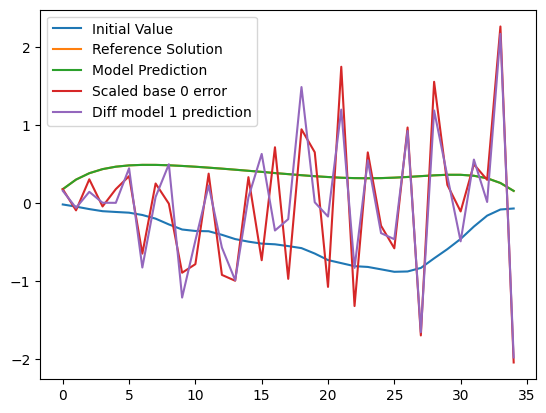

---------NEW RUN---------  i, j =  2 5
------ TRAINING BASE------
0  :  3.908e-06
10  :  1.206e-06
20  :  1.209e-06
30  :  9.641e-07
40  :  8.657e-07
50  :  7.74e-07
60  :  7.286e-07
70  :  6.623e-07
80  :  6.229e-07
90  :  5.682e-07
100  :  5.738e-07
110  :  5.722e-07
120  :  4.988e-07
130  :  5.226e-07
140  :  4.99e-07
150  :  4.955e-07
160  :  4.855e-07
170  :  4.553e-07
180  :  4.673e-07
190  :  4.6e-07
200  :  4.391e-07
210  :  4.43e-07
220  :  4.445e-07
230  :  4.285e-07
240  :  4.226e-07
250  :  4.254e-07
260  :  4.183e-07
270  :  4.06e-07
280  :  4.061e-07
290  :  4.102e-07
300  :  4.207e-07
310  :  3.863e-07
320  :  4.077e-07
330  :  3.81e-07
340  :  4.078e-07
350  :  3.891e-07
360  :  3.788e-07
370  :  3.859e-07
380  :  3.965e-07
390  :  3.811e-07
400  :  3.859e-07
410  :  3.703e-07
420  :  3.582e-07
430  :  3.639e-07
440  :  3.614e-07
450  :  3.621e-07
460  :  3.624e-07
470  :  3.557e-07
480  :  3.525e-07
490  :  3.44e-07
500  :  3.452e-07
510  :  3.616e-07
520  :  3.593e-07

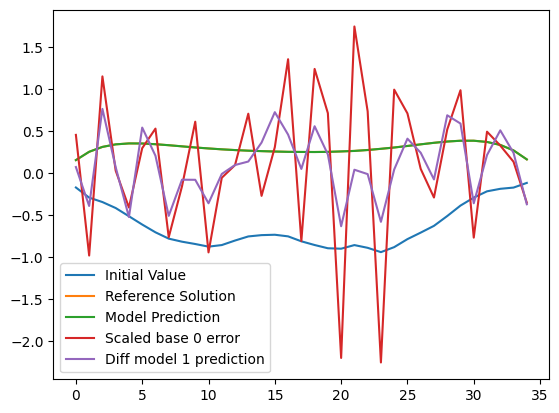

---------NEW RUN---------  i, j =  2 6
------ TRAINING BASE------
0  :  5.461e-06
10  :  1.397e-06
20  :  1.231e-06
30  :  1.046e-06
40  :  8.72e-07
50  :  8.12e-07
60  :  7.152e-07
70  :  6.474e-07
80  :  5.925e-07
90  :  5.439e-07
100  :  5.333e-07
110  :  4.904e-07
120  :  4.759e-07
130  :  4.599e-07
140  :  4.582e-07
150  :  4.303e-07
160  :  4.312e-07
170  :  4.198e-07
180  :  4.106e-07
190  :  3.988e-07
200  :  4.051e-07
210  :  4.112e-07
220  :  3.911e-07
230  :  3.868e-07
240  :  3.929e-07
250  :  3.957e-07
260  :  3.765e-07
270  :  3.686e-07
280  :  3.706e-07
290  :  3.77e-07
300  :  3.753e-07
310  :  3.636e-07
320  :  3.539e-07
330  :  3.551e-07
340  :  3.626e-07
350  :  3.632e-07
360  :  3.66e-07
370  :  3.529e-07
380  :  3.609e-07
390  :  3.518e-07
400  :  3.468e-07
410  :  3.555e-07
420  :  3.45e-07
430  :  3.476e-07
440  :  3.536e-07
450  :  3.402e-07
460  :  3.48e-07
470  :  3.455e-07
480  :  3.316e-07
490  :  3.43e-07
500  :  3.266e-07
510  :  3.395e-07
520  :  3.201e-0

3310  :  0.4407
3320  :  0.4486
3330  :  0.4298
3340  :  0.4228
3350  :  0.4254
3360  :  0.419
3370  :  0.4063
3380  :  0.4257
3390  :  0.4284
3400  :  0.4137
3410  :  0.4246
3420  :  0.4084
3430  :  0.4087
3440  :  0.4252
3450  :  0.4197
3460  :  0.4113
3470  :  0.4086
3480  :  0.4027
3490  :  0.4289
3500  :  0.4297
3510  :  0.4322
3520  :  0.4013
3530  :  0.4045
3540  :  0.4237
3550  :  0.3976
3560  :  0.4565
3570  :  0.4109
3580  :  0.3977
3590  :  0.413
3600  :  0.4038
3610  :  0.4034
3620  :  0.4193
3630  :  0.409
3640  :  0.3986
3650  :  0.3984
3660  :  0.3882
3670  :  0.3804
3680  :  0.3956
3690  :  0.4039
3700  :  0.4031
3710  :  0.3906
3720  :  0.3958
3730  :  0.3891
3740  :  0.3987
3750  :  0.3694
3760  :  0.385
3770  :  0.398
3780  :  0.4065
3790  :  0.4027
3800  :  0.4045
3810  :  0.4071
3820  :  0.4026
3830  :  0.3961
3840  :  0.3814
3850  :  0.3787
3860  :  0.398
3870  :  0.4043
3880  :  0.3824
3890  :  0.3781
3900  :  0.3918
3910  :  0.3785
3920  :  0.3965
3930  :  0.400

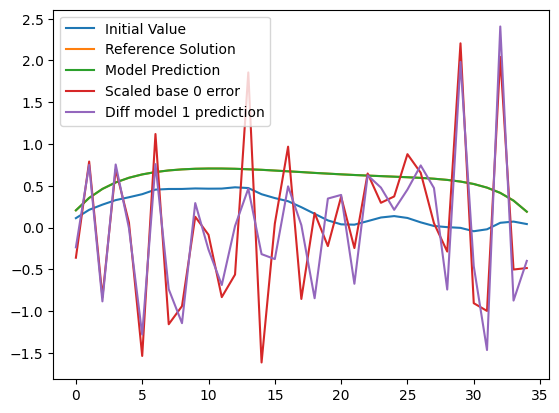

---------NEW RUN---------  i, j =  2 7
------ TRAINING BASE------
0  :  7.419e-06
10  :  2.269e-06
20  :  1.497e-06
30  :  1.483e-06
40  :  1.145e-06
50  :  1.006e-06
60  :  8.963e-07
70  :  8.205e-07
80  :  7.328e-07
90  :  6.69e-07
100  :  6.257e-07
110  :  5.948e-07
120  :  5.385e-07
130  :  4.93e-07
140  :  4.935e-07
150  :  4.835e-07
160  :  4.612e-07
170  :  4.765e-07
180  :  4.437e-07
190  :  4.264e-07
200  :  4.033e-07
210  :  4.171e-07
220  :  4.138e-07
230  :  4.004e-07
240  :  4.006e-07
250  :  3.942e-07
260  :  3.827e-07
270  :  3.739e-07
280  :  3.774e-07
290  :  3.704e-07
300  :  3.735e-07
310  :  3.825e-07
320  :  3.729e-07
330  :  3.669e-07
340  :  3.53e-07
350  :  3.688e-07
360  :  3.692e-07
370  :  3.516e-07
380  :  3.656e-07
390  :  3.529e-07
400  :  3.529e-07
410  :  3.46e-07
420  :  3.525e-07
430  :  3.474e-07
440  :  3.456e-07
450  :  3.454e-07
460  :  3.388e-07
470  :  3.361e-07
480  :  3.589e-07
490  :  3.32e-07
500  :  3.336e-07
510  :  3.414e-07
520  :  3.371e

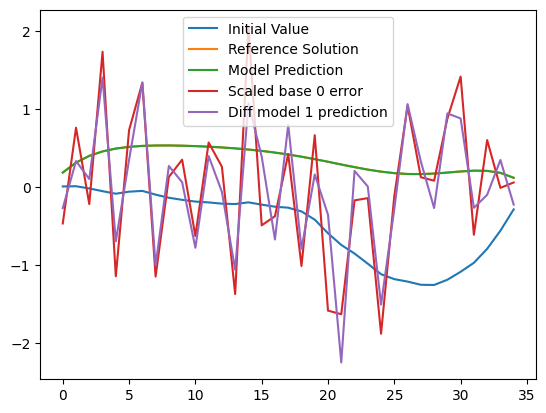

---------NEW RUN---------  i, j =  2 8
------ TRAINING BASE------
0  :  1.025e-05
10  :  3.482e-06
20  :  2.148e-06
30  :  2.157e-06
40  :  1.722e-06
50  :  1.504e-06
60  :  1.319e-06
70  :  1.182e-06
80  :  1.118e-06
90  :  9.435e-07
100  :  9.555e-07
110  :  8.231e-07
120  :  7.752e-07
130  :  7.531e-07
140  :  6.476e-07
150  :  6.592e-07
160  :  6.504e-07
170  :  6.049e-07
180  :  5.974e-07
190  :  5.796e-07
200  :  5.347e-07
210  :  5.377e-07
220  :  5.413e-07
230  :  5.019e-07
240  :  5.002e-07
250  :  4.734e-07
260  :  4.782e-07
270  :  4.865e-07
280  :  4.619e-07
290  :  4.572e-07
300  :  4.494e-07
310  :  4.565e-07
320  :  4.383e-07
330  :  4.258e-07
340  :  4.284e-07
350  :  4.37e-07
360  :  4.3e-07
370  :  4.401e-07
380  :  4.05e-07
390  :  4.143e-07
400  :  4.181e-07
410  :  4.003e-07
420  :  4.09e-07
430  :  3.95e-07
440  :  3.844e-07
450  :  3.928e-07
460  :  4.009e-07
470  :  3.964e-07
480  :  3.814e-07
490  :  3.659e-07
500  :  3.806e-07
510  :  3.82e-07
520  :  3.827e-0

3490  :  0.3302
3500  :  0.3296
3510  :  0.3414
3520  :  0.3281
3530  :  0.3353
3540  :  0.3317
3550  :  0.3289
3560  :  0.3328
3570  :  0.336
3580  :  0.3248
3590  :  0.3315
3600  :  0.3308
3610  :  0.3358
3620  :  0.3296
3630  :  0.3337
3640  :  0.3318
3650  :  0.3244
    New learning rate:  3.2000000000000007e-06
3660  :  0.3251
3670  :  0.3365
3680  :  0.3327
3690  :  0.3272
3700  :  0.3343
3710  :  0.3306
3720  :  0.3285
3730  :  0.325
3740  :  0.3346
3750  :  0.3269
3760  :  0.3326
3770  :  0.3291
3780  :  0.3219
3790  :  0.3302
3800  :  0.3339
3810  :  0.3314
3820  :  0.3306
3830  :  0.3313
3840  :  0.3343
3850  :  0.3362
3860  :  0.3305
3870  :  0.3349
3880  :  0.3349
3890  :  0.3398
3900  :  0.3308
    New learning rate:  6.400000000000001e-07
3910  :  0.3291
3920  :  0.3307
3930  :  0.3276
3940  :  0.335
3950  :  0.3355
3960  :  0.3311
3970  :  0.3323
3980  :  0.3324
3990  :  0.3287
4000  :  0.3323
4010  :  0.3255
4020  :  0.33
Training ended due to inssuficient improvement


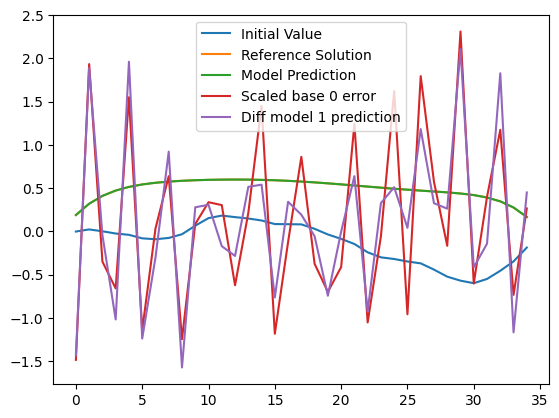

---------NEW RUN---------  i, j =  3 0
------ TRAINING BASE------
0  :  5.822e-06
10  :  4.21e-06
20  :  2.496e-06
30  :  2.412e-06
40  :  2.027e-06
50  :  1.696e-06
60  :  1.478e-06
70  :  1.37e-06
80  :  1.205e-06
90  :  1.23e-06
100  :  1.223e-06
110  :  1.026e-06
120  :  1.017e-06
130  :  9.711e-07
140  :  9.024e-07
150  :  9.132e-07
160  :  7.694e-07
170  :  8.87e-07
180  :  7.751e-07
190  :  7.866e-07
200  :  7.343e-07
210  :  6.567e-07
220  :  6.745e-07
230  :  6.445e-07
240  :  6.237e-07
250  :  6.963e-07
260  :  6.211e-07
270  :  5.955e-07
280  :  6.162e-07
290  :  6.03e-07
300  :  6.186e-07
310  :  6.068e-07
320  :  6.215e-07
330  :  6.232e-07
340  :  5.107e-07
350  :  5.108e-07
360  :  5.341e-07
370  :  6.068e-07
380  :  5.216e-07
390  :  5.174e-07
400  :  4.918e-07
410  :  5.017e-07
420  :  5.232e-07
430  :  4.869e-07
440  :  5.062e-07
450  :  4.848e-07
460  :  4.79e-07
470  :  4.714e-07
480  :  4.986e-07
490  :  4.36e-07
500  :  4.873e-07
510  :  4.296e-07
520  :  4.806e-0

2290  :  0.4134
2300  :  0.4156
2310  :  0.4285
2320  :  0.4152
Training ended due to inssuficient improvement


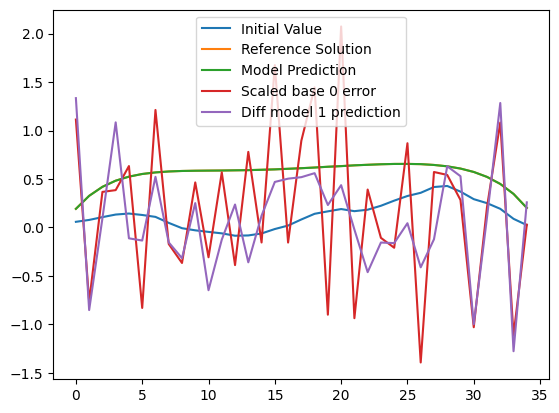

---------NEW RUN---------  i, j =  3 1
------ TRAINING BASE------
0  :  4.033e-06
10  :  3.107e-06
20  :  2.562e-06
30  :  1.943e-06
40  :  1.706e-06
50  :  1.62e-06
60  :  1.436e-06
70  :  1.327e-06
80  :  1.273e-06
90  :  1.33e-06
100  :  1.102e-06
110  :  1.011e-06
120  :  9.113e-07
130  :  1.068e-06
140  :  8.778e-07
150  :  9.366e-07
160  :  8.6e-07
170  :  7.656e-07
180  :  7.75e-07
190  :  7.577e-07
200  :  8.174e-07
210  :  6.839e-07
220  :  7.233e-07
230  :  6.75e-07
240  :  7.385e-07
250  :  6.688e-07
260  :  6.054e-07
270  :  6.277e-07
280  :  6.054e-07
290  :  5.809e-07
300  :  6.209e-07
310  :  6.03e-07
320  :  5.097e-07
330  :  5.068e-07
340  :  5.115e-07
350  :  5.193e-07
360  :  4.839e-07
370  :  5.498e-07
380  :  4.958e-07
390  :  4.993e-07
400  :  4.53e-07
410  :  5.138e-07
420  :  4.787e-07
430  :  4.771e-07
440  :  4.52e-07
450  :  4.282e-07
460  :  4.292e-07
470  :  4.471e-07
480  :  4.389e-07
490  :  4.579e-07
500  :  4.19e-07
510  :  4.545e-07
520  :  4.36e-07
53

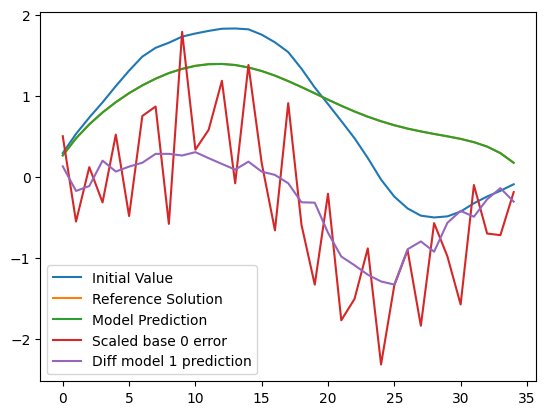

---------NEW RUN---------  i, j =  3 2
------ TRAINING BASE------
0  :  3.39e-06
10  :  2.512e-06
20  :  1.993e-06
30  :  1.697e-06
40  :  1.48e-06
50  :  1.289e-06
60  :  1.249e-06
70  :  1.115e-06
80  :  1.137e-06
90  :  1.087e-06
100  :  9.551e-07
110  :  8.749e-07
120  :  8.388e-07
130  :  8.117e-07
140  :  8.409e-07
150  :  8.299e-07
160  :  7.537e-07
170  :  7.464e-07
180  :  7.348e-07
190  :  6.626e-07
200  :  6.639e-07
210  :  6.752e-07
220  :  5.685e-07
230  :  6.036e-07
240  :  6.039e-07
250  :  5.514e-07
260  :  5.777e-07
270  :  5.728e-07
280  :  5.396e-07
290  :  5.639e-07
300  :  4.704e-07
310  :  5.138e-07
320  :  4.704e-07
330  :  4.885e-07
340  :  4.685e-07
350  :  4.526e-07
360  :  4.417e-07
370  :  4.632e-07
380  :  5.027e-07
390  :  4.567e-07
400  :  4.207e-07
410  :  4.524e-07
420  :  4.281e-07
430  :  4.234e-07
440  :  3.784e-07
450  :  4.01e-07
460  :  3.923e-07
470  :  3.862e-07
480  :  4.061e-07
490  :  3.901e-07
500  :  3.996e-07
510  :  3.992e-07
520  :  4.00

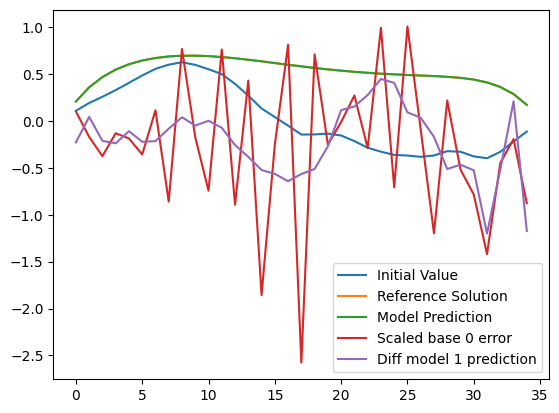

---------NEW RUN---------  i, j =  3 3
------ TRAINING BASE------
0  :  2.831e-06
10  :  1.735e-06
20  :  1.542e-06
30  :  1.329e-06
40  :  1.244e-06
50  :  1.099e-06
60  :  1.045e-06
70  :  9.372e-07
80  :  9.134e-07
90  :  8.469e-07
100  :  7.668e-07
110  :  7.377e-07
120  :  7.265e-07
130  :  7.038e-07
140  :  6.7e-07
150  :  6.414e-07
160  :  6.562e-07
170  :  6.476e-07
180  :  5.924e-07
190  :  5.646e-07
200  :  5.853e-07
210  :  5.317e-07
220  :  5.388e-07
230  :  5.092e-07
240  :  5.202e-07
250  :  4.905e-07
260  :  4.885e-07
270  :  4.602e-07
280  :  4.56e-07
290  :  4.689e-07
300  :  4.31e-07
310  :  4.177e-07
320  :  4.441e-07
330  :  4.36e-07
340  :  4.059e-07
350  :  4.273e-07
360  :  3.957e-07
370  :  4.002e-07
380  :  3.681e-07
390  :  3.955e-07
400  :  3.848e-07
410  :  3.659e-07
420  :  3.731e-07
430  :  3.749e-07
440  :  3.682e-07
450  :  3.704e-07
460  :  3.554e-07
470  :  3.511e-07
480  :  3.392e-07
490  :  3.652e-07
500  :  3.461e-07
510  :  3.397e-07
520  :  3.453e

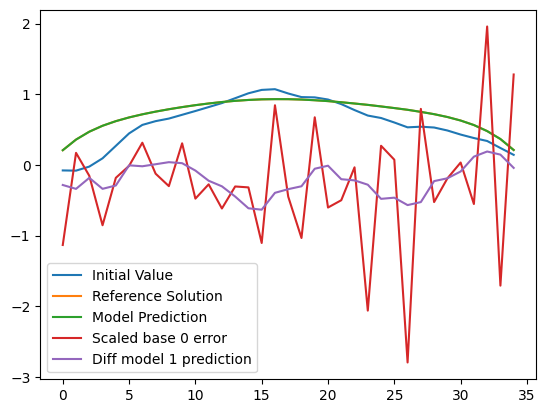

---------NEW RUN---------  i, j =  3 4
------ TRAINING BASE------
0  :  3.039e-06
10  :  1.308e-06
20  :  1.243e-06
30  :  1.087e-06
40  :  9.001e-07
50  :  8.077e-07
60  :  8.525e-07
70  :  7.104e-07
80  :  7.054e-07
90  :  6.183e-07
100  :  6.09e-07
110  :  5.744e-07
120  :  5.953e-07
130  :  5.582e-07
140  :  5.418e-07
150  :  5.413e-07
160  :  5.128e-07
170  :  5.036e-07
180  :  5.056e-07
190  :  5.112e-07
200  :  4.808e-07
210  :  4.847e-07
220  :  4.767e-07
230  :  4.348e-07
240  :  4.541e-07
250  :  4.439e-07
260  :  4.332e-07
270  :  4.305e-07
280  :  4.13e-07
290  :  4.052e-07
300  :  3.768e-07
310  :  3.764e-07
320  :  3.628e-07
330  :  3.687e-07
340  :  3.764e-07
350  :  3.638e-07
360  :  3.554e-07
370  :  3.556e-07
380  :  3.537e-07
390  :  3.454e-07
400  :  3.322e-07
410  :  3.533e-07
420  :  3.471e-07
430  :  3.428e-07
440  :  3.137e-07
450  :  3.373e-07
460  :  3.207e-07
470  :  3.202e-07
480  :  3.298e-07
490  :  3.174e-07
500  :  3.134e-07
510  :  3.019e-07
520  :  3.1

2660  :  0.4913
2670  :  0.4888
2680  :  0.488
2690  :  0.4942
2700  :  0.5061
2710  :  0.4954
2720  :  0.5075
2730  :  0.4982
2740  :  0.4933
2750  :  0.5181
2760  :  0.5058
2770  :  0.4831
2780  :  0.4866
2790  :  0.4856
2800  :  0.4896
2810  :  0.4696
2820  :  0.4879
2830  :  0.4936
2840  :  0.4937
2850  :  0.4716
2860  :  0.4903
2870  :  0.4812
2880  :  0.5084
2890  :  0.4786
2900  :  0.4651
2910  :  0.4915
2920  :  0.483
2930  :  0.4989
2940  :  0.4767
2950  :  0.4763
2960  :  0.4821
2970  :  0.4694
2980  :  0.4664
2990  :  0.4812
3000  :  0.4729
3010  :  0.4632
3020  :  0.4821
3030  :  0.4693
3040  :  0.4747
3050  :  0.4659
3060  :  0.4723
3070  :  0.4739
3080  :  0.4608
3090  :  0.4639
3100  :  0.4693
3110  :  0.4717
3120  :  0.522
3130  :  0.4825
3140  :  0.4514
3150  :  0.4611
3160  :  0.4606
3170  :  0.4577
3180  :  0.4562
3190  :  0.4676
3200  :  0.4684
3210  :  0.459
3220  :  0.4679
3230  :  0.4696
3240  :  0.4506
3250  :  0.4481
3260  :  0.4635
3270  :  0.4534
3280  :  0.4

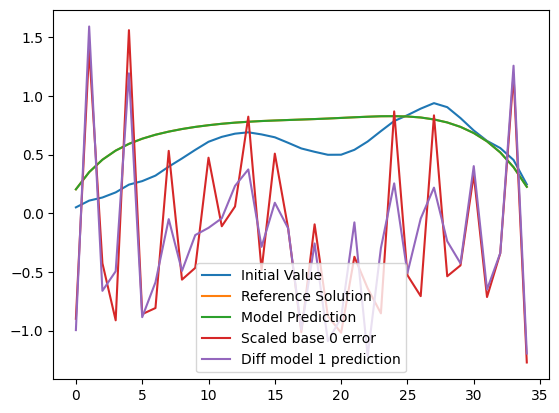

---------NEW RUN---------  i, j =  3 5
------ TRAINING BASE------
0  :  3.947e-06
10  :  1.065e-06
20  :  1.134e-06
30  :  8.157e-07
40  :  7.836e-07
50  :  6.526e-07
60  :  6.192e-07
70  :  5.907e-07
80  :  5.799e-07
90  :  5.392e-07
100  :  5.202e-07
110  :  4.567e-07
120  :  4.752e-07
130  :  4.422e-07
140  :  4.551e-07
150  :  4.475e-07
160  :  3.956e-07
170  :  4.303e-07
180  :  4.303e-07
190  :  4.044e-07
200  :  4.037e-07
210  :  3.933e-07
220  :  3.702e-07
230  :  4.07e-07
240  :  3.732e-07
250  :  3.955e-07
260  :  3.647e-07
270  :  3.705e-07
280  :  3.512e-07
290  :  3.589e-07
300  :  3.459e-07
310  :  3.456e-07
320  :  3.47e-07
330  :  3.394e-07
340  :  3.309e-07
350  :  3.198e-07
360  :  3.392e-07
370  :  3.274e-07
380  :  3.176e-07
390  :  3.287e-07
400  :  3.154e-07
410  :  3.08e-07
420  :  3.075e-07
430  :  3.196e-07
440  :  3.048e-07
450  :  2.978e-07
460  :  2.921e-07
470  :  3.036e-07
480  :  2.956e-07
490  :  3.07e-07
500  :  3.023e-07
510  :  2.818e-07
520  :  2.886

2410  :  0.3074
2420  :  0.3151
2430  :  0.2962
2440  :  0.3301
2450  :  0.3061
2460  :  0.3278
    New learning rate:  0.0004
    New Batch size:  2048
2470  :  0.292
2480  :  0.283
2490  :  0.2811
2500  :  0.2848
2510  :  0.2834
2520  :  0.2774
2530  :  0.2837
2540  :  0.2746
2550  :  0.2785
2560  :  0.2842
2570  :  0.2722
2580  :  0.2823
2590  :  0.281
2600  :  0.278
2610  :  0.2776
2620  :  0.2735
2630  :  0.2788
2640  :  0.2686
2650  :  0.2696
2660  :  0.274
2670  :  0.2732
2680  :  0.2772
2690  :  0.2798
2700  :  0.2702
2710  :  0.2707
2720  :  0.269
2730  :  0.2737
2740  :  0.2741
2750  :  0.2743
2760  :  0.272
2770  :  0.2765
2780  :  0.2803
2790  :  0.2755
2800  :  0.2665
2810  :  0.2709
2820  :  0.2681
2830  :  0.276
2840  :  0.2681
2850  :  0.2756
2860  :  0.2726
2870  :  0.2692
2880  :  0.2737
2890  :  0.2705
2900  :  0.2698
2910  :  0.2725
2920  :  0.2662
2930  :  0.2708
2940  :  0.2629
2950  :  0.2723
2960  :  0.2667
    New learning rate:  8e-05
2970  :  0.2716
2980  :  

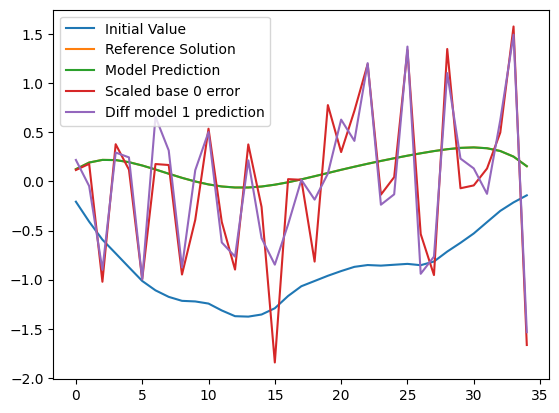

---------NEW RUN---------  i, j =  3 6
------ TRAINING BASE------
0  :  5.277e-06
10  :  1.256e-06
20  :  1.072e-06
30  :  9.118e-07
40  :  7.864e-07
50  :  7.099e-07
60  :  6.095e-07
70  :  5.607e-07
80  :  5.25e-07
90  :  4.851e-07
100  :  4.37e-07
110  :  4.446e-07
120  :  4.287e-07
130  :  4.088e-07
140  :  4.075e-07
150  :  3.948e-07
160  :  3.937e-07
170  :  3.722e-07
180  :  3.765e-07
190  :  3.467e-07
200  :  3.609e-07
210  :  3.546e-07
220  :  3.561e-07
230  :  3.565e-07
240  :  3.301e-07
250  :  3.288e-07
260  :  3.411e-07
270  :  3.221e-07
280  :  3.305e-07
290  :  3.202e-07
300  :  3.189e-07
310  :  3.242e-07
320  :  3.262e-07
330  :  3.176e-07
340  :  3.156e-07
350  :  3.079e-07
360  :  2.992e-07
370  :  3.084e-07
380  :  3.179e-07
390  :  2.852e-07
400  :  3.042e-07
410  :  3.043e-07
420  :  2.895e-07
430  :  2.897e-07
440  :  2.982e-07
450  :  2.895e-07
460  :  2.9e-07
470  :  2.888e-07
480  :  2.727e-07
490  :  2.802e-07
500  :  2.801e-07
510  :  2.84e-07
520  :  2.782e

3050  :  0.3041
3060  :  0.2808
3070  :  0.2971
3080  :  0.2987
3090  :  0.3091
3100  :  0.3138
3110  :  0.3053
3120  :  0.2896
3130  :  0.2819
3140  :  0.2889
3150  :  0.2889
3160  :  0.284
3170  :  0.2809
3180  :  0.2885
3190  :  0.2723
3200  :  0.2818
3210  :  0.2915
3220  :  0.4158
3230  :  0.3422
3240  :  0.318
3250  :  0.2948
3260  :  0.2806
3270  :  0.2778
3280  :  0.2814
3290  :  0.2748
3300  :  0.2784
3310  :  0.2954
3320  :  0.2737
3330  :  0.2813
3340  :  0.2717
3350  :  0.2869
3360  :  0.2808
3370  :  0.2731
3380  :  0.2688
3390  :  0.2863
3400  :  0.3441
3410  :  0.2773
3420  :  0.292
3430  :  0.2759
3440  :  0.2767
3450  :  0.2683
3460  :  0.2577
3470  :  0.2601
3480  :  0.2649
3490  :  0.293
3500  :  0.311
3510  :  0.2764
3520  :  0.2622
3530  :  0.2672
3540  :  0.2625
3550  :  0.2603
3560  :  0.2814
3570  :  0.2663
3580  :  0.2588
3590  :  0.2581
3600  :  0.2575
3610  :  0.2654
3620  :  0.2844
3630  :  0.2621
3640  :  0.2738
3650  :  0.2751
3660  :  0.2553
3670  :  0.25

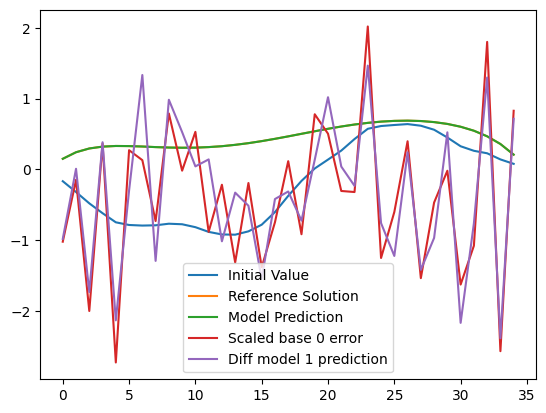

---------NEW RUN---------  i, j =  3 7
------ TRAINING BASE------
0  :  7.336e-06
10  :  1.997e-06
20  :  1.292e-06
30  :  1.285e-06
40  :  9.678e-07
50  :  9.108e-07
60  :  8.023e-07
70  :  7.207e-07
80  :  6.548e-07
90  :  5.714e-07
100  :  5.527e-07
110  :  5.099e-07
120  :  4.833e-07
130  :  4.656e-07
140  :  4.387e-07
150  :  4.049e-07
160  :  4.123e-07
170  :  3.835e-07
180  :  4.019e-07
190  :  3.628e-07
200  :  3.707e-07
210  :  3.57e-07
220  :  3.716e-07
230  :  3.627e-07
240  :  3.453e-07
250  :  3.454e-07
260  :  3.432e-07
270  :  3.332e-07
280  :  3.2e-07
290  :  3.32e-07
300  :  3.255e-07
310  :  3.344e-07
320  :  3.199e-07
330  :  3.303e-07
340  :  3.217e-07
350  :  3.102e-07
360  :  3.191e-07
370  :  3.284e-07
380  :  3.274e-07
390  :  3.016e-07
400  :  3.027e-07
410  :  2.999e-07
420  :  3.049e-07
430  :  2.966e-07
440  :  2.992e-07
450  :  2.921e-07
460  :  2.843e-07
470  :  2.868e-07
480  :  2.912e-07
490  :  2.92e-07
500  :  2.793e-07
510  :  2.801e-07
520  :  2.819e

3060  :  0.3466
3070  :  0.3213
3080  :  0.3312
3090  :  0.311
3100  :  0.317
3110  :  0.3136
3120  :  0.3017
3130  :  0.3385
3140  :  0.3091
3150  :  0.3117
3160  :  0.3212
3170  :  0.3167
3180  :  0.3163
3190  :  0.3457
3200  :  0.3192
3210  :  0.3122
3220  :  0.3209
3230  :  0.3285
3240  :  0.3194
3250  :  0.3044
3260  :  0.3211
3270  :  0.3137
3280  :  0.3194
3290  :  0.3176
3300  :  0.3078
3310  :  0.3167
3320  :  0.3045
3330  :  0.2989
3340  :  0.3059
3350  :  0.3171
3360  :  0.3165
3370  :  0.3083
3380  :  0.307
3390  :  0.3074
3400  :  0.3059
3410  :  0.3087
3420  :  0.2987
3430  :  0.3044
3440  :  0.3121
3450  :  0.3114
3460  :  0.3003
3470  :  0.3014
3480  :  0.3097
3490  :  0.3057
3500  :  0.3112
3510  :  0.3021
3520  :  0.3054
    New learning rate:  0.0004
    New Batch size:  2048
3530  :  0.2925
3540  :  0.2982
3550  :  0.2947
3560  :  0.2863
3570  :  0.2963
3580  :  0.2923
3590  :  0.296
3600  :  0.2948
3610  :  0.299
3620  :  0.2957
3630  :  0.2916
3640  :  0.2967
3650

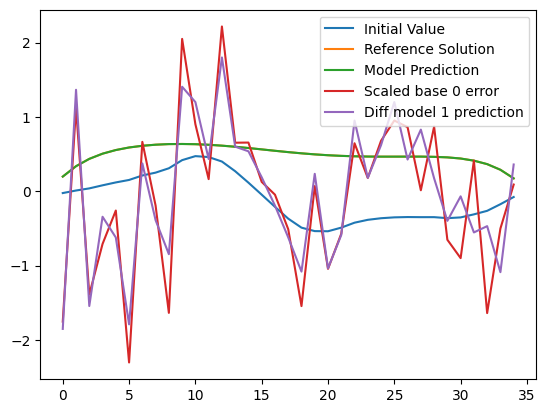

---------NEW RUN---------  i, j =  3 8
------ TRAINING BASE------
0  :  1.074e-05
10  :  3.079e-06
20  :  1.885e-06
30  :  1.869e-06
40  :  1.644e-06
50  :  1.392e-06
60  :  1.115e-06
70  :  1.12e-06
80  :  1.005e-06
90  :  8.325e-07
100  :  7.967e-07
110  :  7.233e-07
120  :  6.97e-07
130  :  6.019e-07
140  :  6.538e-07
150  :  5.947e-07
160  :  5.609e-07
170  :  5.252e-07
180  :  5.219e-07
190  :  5.086e-07
200  :  5.051e-07
210  :  4.822e-07
220  :  4.821e-07
230  :  4.649e-07
240  :  4.641e-07
250  :  4.47e-07
260  :  4.461e-07
270  :  4.294e-07
280  :  4.379e-07
290  :  4.06e-07
300  :  4.209e-07
310  :  3.766e-07
320  :  3.94e-07
330  :  3.807e-07
340  :  3.951e-07
350  :  3.811e-07
360  :  3.692e-07
370  :  3.924e-07
380  :  3.63e-07
390  :  3.66e-07
400  :  3.459e-07
410  :  3.681e-07
420  :  3.437e-07
430  :  3.415e-07
440  :  3.469e-07
450  :  3.391e-07
460  :  3.341e-07
470  :  3.317e-07
480  :  3.266e-07
490  :  3.333e-07
500  :  3.3e-07
510  :  3.278e-07
520  :  3.178e-07


2770  :  0.3233
2780  :  0.3263
2790  :  0.3311
2800  :  0.3288
2810  :  0.3274
2820  :  0.3241
2830  :  0.3248
2840  :  0.3347
2850  :  0.3212
2860  :  0.3269
2870  :  0.3211
2880  :  0.3255
2890  :  0.3261
2900  :  0.3303
2910  :  0.3295
2920  :  0.3286
2930  :  0.3318
2940  :  0.3195
2950  :  0.3225
2960  :  0.3254
2970  :  0.3262
2980  :  0.3259
2990  :  0.3238
3000  :  0.3237
3010  :  0.3258
3020  :  0.3229
    New learning rate:  8e-05
3030  :  0.3196
3040  :  0.3238
3050  :  0.3208
3060  :  0.3196
3070  :  0.3229
3080  :  0.3194
3090  :  0.3217
3100  :  0.3211
3110  :  0.3247
3120  :  0.329
3130  :  0.3263
3140  :  0.3283
3150  :  0.3303
    New learning rate:  1.6000000000000003e-05
3160  :  0.321
3170  :  0.3166
3180  :  0.323
3190  :  0.3194
3200  :  0.3257
3210  :  0.3223
3220  :  0.3218
3230  :  0.3214
3240  :  0.3252
3250  :  0.3203
3260  :  0.3231
3270  :  0.3218
3280  :  0.3236
3290  :  0.3191
3300  :  0.3226
3310  :  0.3265
    New learning rate:  3.2000000000000007e-06

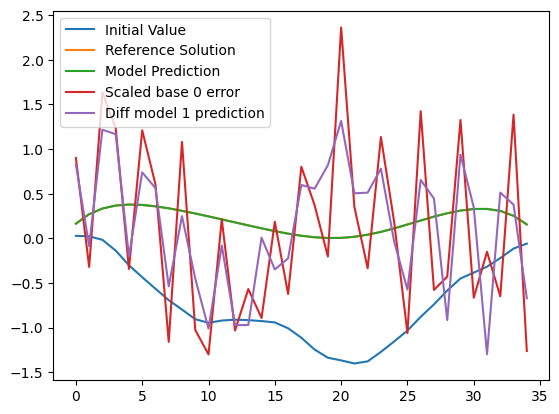

---------NEW RUN---------  i, j =  4 0
------ TRAINING BASE------
0  :  5.306e-06
10  :  3.712e-06
20  :  2.614e-06
30  :  1.92e-06
40  :  1.911e-06
50  :  1.675e-06
60  :  1.522e-06
70  :  1.254e-06
80  :  1.235e-06
90  :  1.096e-06
100  :  1.024e-06
110  :  8.871e-07
120  :  8.726e-07
130  :  9.037e-07
140  :  8.785e-07
150  :  7.462e-07
160  :  8.74e-07
170  :  7.402e-07
180  :  6.712e-07
190  :  6.714e-07
200  :  6.211e-07
210  :  6.296e-07
220  :  5.569e-07
230  :  5.428e-07
240  :  5.368e-07
250  :  5.489e-07
260  :  5.15e-07
270  :  5.761e-07
280  :  5.134e-07
290  :  5.054e-07
300  :  4.574e-07
310  :  4.716e-07
320  :  4.551e-07
330  :  4.59e-07
340  :  4.028e-07
350  :  4.61e-07
360  :  4.615e-07
370  :  4.538e-07
380  :  4.533e-07
390  :  3.874e-07
400  :  4.476e-07
410  :  3.924e-07
420  :  4.414e-07
430  :  3.544e-07
440  :  3.953e-07
450  :  3.667e-07
460  :  3.985e-07
470  :  3.662e-07
480  :  3.464e-07
490  :  3.563e-07
500  :  3.391e-07
510  :  3.383e-07
520  :  3.51e-

1700  :  0.3449
1710  :  0.3465
1720  :  0.3451
1730  :  0.3422
1740  :  0.3481
1750  :  0.3443
1760  :  0.3526
1770  :  0.3481
1780  :  0.3448
1790  :  0.3464
1800  :  0.3432
Training ended due to inssuficient improvement


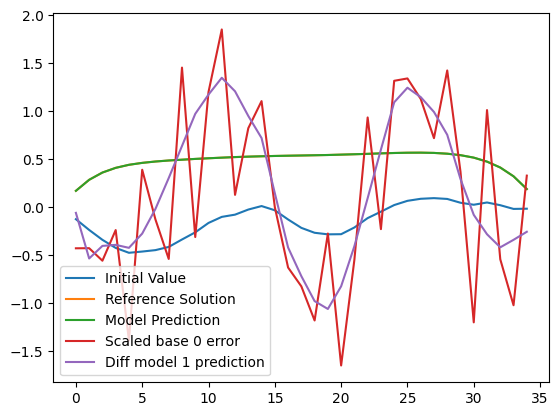

---------NEW RUN---------  i, j =  4 1
------ TRAINING BASE------
0  :  4.385e-06
10  :  2.991e-06
20  :  2.202e-06
30  :  1.835e-06
40  :  1.626e-06
50  :  1.446e-06
60  :  1.295e-06
70  :  1.311e-06
80  :  1.226e-06
90  :  1.075e-06
100  :  1.068e-06
110  :  9.506e-07
120  :  9.22e-07
130  :  9.806e-07
140  :  8.141e-07
150  :  7.901e-07
160  :  7.269e-07
170  :  7.311e-07
180  :  6.792e-07
190  :  6.169e-07
200  :  6.514e-07
210  :  6.523e-07
220  :  6.15e-07
230  :  5.996e-07
240  :  5.695e-07
250  :  5.606e-07
260  :  5.295e-07
270  :  5.584e-07
280  :  4.658e-07
290  :  4.784e-07
300  :  5.03e-07
310  :  4.413e-07
320  :  4.781e-07
330  :  4.579e-07
340  :  4.395e-07
350  :  4.188e-07
360  :  4.135e-07
370  :  4.018e-07
380  :  4.125e-07
390  :  3.948e-07
400  :  3.482e-07
410  :  3.847e-07
420  :  3.757e-07
430  :  3.787e-07
440  :  3.541e-07
450  :  3.474e-07
460  :  3.791e-07
470  :  3.304e-07
480  :  3.509e-07
490  :  3.509e-07
500  :  3.315e-07
510  :  3.09e-07
520  :  2.986

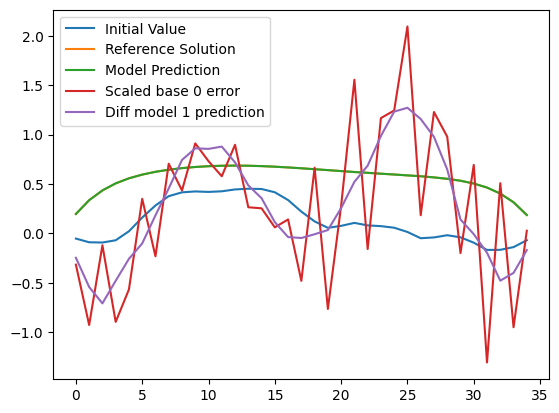

---------NEW RUN---------  i, j =  4 2
------ TRAINING BASE------
0  :  3.009e-06
10  :  2.293e-06
20  :  2.021e-06
30  :  1.717e-06
40  :  1.442e-06
50  :  1.283e-06
60  :  1.175e-06
70  :  1.012e-06
80  :  9.954e-07
90  :  9.099e-07
100  :  8.577e-07
110  :  8.634e-07
120  :  8.117e-07
130  :  7.399e-07
140  :  6.472e-07
150  :  6.617e-07
160  :  6.564e-07
170  :  6.69e-07
180  :  7.062e-07
190  :  5.745e-07
200  :  5.914e-07
210  :  5.373e-07
220  :  5.177e-07
230  :  5.543e-07
240  :  5.177e-07
250  :  4.976e-07
260  :  4.753e-07
270  :  4.497e-07
280  :  4.851e-07
290  :  4.132e-07
300  :  4.033e-07
310  :  3.731e-07
320  :  4.029e-07
330  :  3.681e-07
340  :  3.579e-07
350  :  4.023e-07
360  :  3.816e-07
370  :  3.756e-07
380  :  3.436e-07
390  :  3.319e-07
400  :  3.144e-07
410  :  3.522e-07
420  :  3.053e-07
430  :  3.178e-07
440  :  3.05e-07
450  :  3.051e-07
460  :  3.02e-07
470  :  2.884e-07
480  :  2.976e-07
490  :  2.788e-07
500  :  2.854e-07
510  :  3.029e-07
520  :  2.90

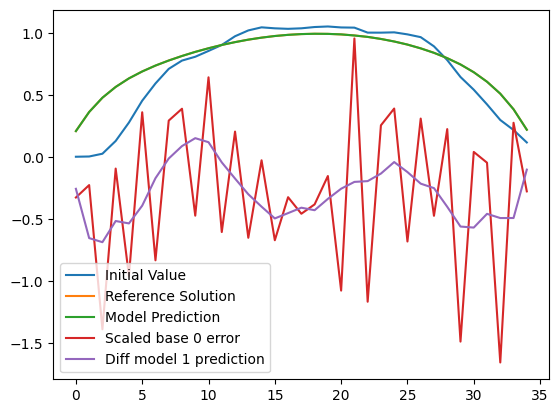

---------NEW RUN---------  i, j =  4 3
------ TRAINING BASE------
0  :  2.681e-06
10  :  1.577e-06
20  :  1.391e-06
30  :  1.319e-06
40  :  1.086e-06
50  :  1.06e-06
60  :  9.151e-07
70  :  8.252e-07
80  :  8.199e-07
90  :  7.69e-07
100  :  7.13e-07
110  :  6.515e-07
120  :  6.543e-07
130  :  6.622e-07
140  :  5.752e-07
150  :  5.849e-07
160  :  5.668e-07
170  :  5.245e-07
180  :  4.885e-07
190  :  5.258e-07
200  :  4.891e-07
210  :  4.868e-07
220  :  4.546e-07
230  :  4.261e-07
240  :  4.271e-07
250  :  3.927e-07
260  :  3.926e-07
270  :  3.984e-07
280  :  3.617e-07
290  :  3.484e-07
300  :  3.595e-07
310  :  3.582e-07
320  :  3.29e-07
330  :  3.465e-07
340  :  3.164e-07
350  :  3.237e-07
360  :  3.215e-07
370  :  3.249e-07
380  :  3.091e-07
390  :  2.868e-07
400  :  2.892e-07
410  :  2.903e-07
420  :  2.675e-07
430  :  2.678e-07
440  :  2.673e-07
450  :  2.786e-07
460  :  2.63e-07
470  :  2.436e-07
480  :  2.531e-07
490  :  2.703e-07
500  :  2.807e-07
510  :  2.678e-07
520  :  2.546e

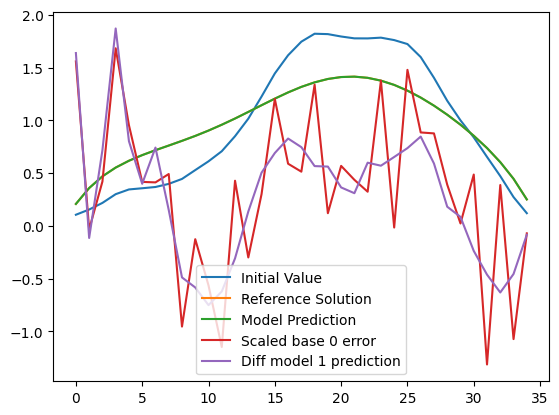

---------NEW RUN---------  i, j =  4 4
------ TRAINING BASE------
0  :  2.914e-06
10  :  1.359e-06
20  :  1.043e-06
30  :  1.028e-06
40  :  9.562e-07
50  :  7.872e-07
60  :  7.406e-07
70  :  6.699e-07
80  :  6.462e-07
90  :  6.159e-07
100  :  6.937e-07
110  :  5.779e-07
120  :  5.26e-07
130  :  4.967e-07
140  :  4.524e-07
150  :  4.447e-07
160  :  4.602e-07
170  :  4.806e-07
180  :  4.35e-07
190  :  3.88e-07
200  :  4.102e-07
210  :  4.238e-07
220  :  4.192e-07
230  :  3.676e-07
240  :  3.381e-07
250  :  3.68e-07
260  :  3.719e-07
270  :  3.618e-07
280  :  3.404e-07
290  :  3.467e-07
300  :  3.203e-07
310  :  3.323e-07
320  :  2.938e-07
330  :  2.917e-07
340  :  2.791e-07
350  :  2.813e-07
360  :  2.884e-07
370  :  2.775e-07
380  :  2.657e-07
390  :  2.689e-07
400  :  2.837e-07
410  :  2.641e-07
420  :  2.819e-07
430  :  2.555e-07
440  :  2.734e-07
450  :  2.612e-07
460  :  2.27e-07
470  :  2.331e-07
480  :  2.475e-07
490  :  2.419e-07
500  :  2.47e-07
510  :  2.322e-07
520  :  2.277e-

3420  :  0.2487
3430  :  0.247
3440  :  0.2484
3450  :  0.2416
3460  :  0.2467
3470  :  0.2484
3480  :  0.2391
3490  :  0.2406
3500  :  0.2367
3510  :  0.2475
3520  :  0.2456
3530  :  0.2497
3540  :  0.241
3550  :  0.2462
3560  :  0.2385
3570  :  0.2414
3580  :  0.2426
3590  :  0.2419
3600  :  0.2507
3610  :  0.2499
3620  :  0.2528
3630  :  0.2425
3640  :  0.2377
3650  :  0.2455
3660  :  0.2312
3670  :  0.2318
3680  :  0.2394
3690  :  0.2327
3700  :  0.2398
3710  :  0.2401
3720  :  0.2341
3730  :  0.2396
3740  :  0.2471
3750  :  0.2361
3760  :  0.2281
3770  :  0.2339
3780  :  0.2307
3790  :  0.2391
3800  :  0.2303
3810  :  0.2428
3820  :  0.2433
3830  :  0.2384
3840  :  0.2318
3850  :  0.2291
3860  :  0.2343
3870  :  0.2319
3880  :  0.2324
3890  :  0.2339
3900  :  0.2284
3910  :  0.2352
3920  :  0.2286
3930  :  0.2343
3940  :  0.2305
3950  :  0.2252
3960  :  0.2354
3970  :  0.2317
3980  :  0.2263
3990  :  0.2281
4000  :  0.2234
4010  :  0.2264
    New learning rate:  0.0004
    New Bat

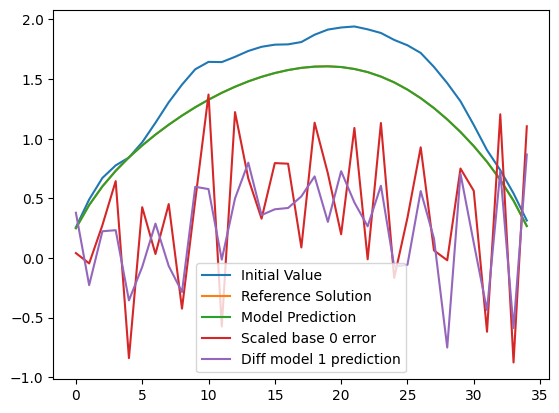

---------NEW RUN---------  i, j =  4 5
------ TRAINING BASE------
0  :  3.586e-06
10  :  9.99e-07
20  :  9.911e-07
30  :  8.264e-07
40  :  7.221e-07
50  :  6.51e-07
60  :  5.793e-07
70  :  5.993e-07
80  :  5.005e-07
90  :  4.417e-07
100  :  4.399e-07
110  :  4.613e-07
120  :  4.286e-07
130  :  3.942e-07
140  :  4.143e-07
150  :  3.943e-07
160  :  3.944e-07
170  :  3.77e-07
180  :  3.526e-07
190  :  3.53e-07
200  :  3.508e-07
210  :  3.275e-07
220  :  3.453e-07
230  :  3.227e-07
240  :  3.321e-07
250  :  3.183e-07
260  :  3.111e-07
270  :  3.22e-07
280  :  2.97e-07
290  :  2.818e-07
300  :  2.786e-07
310  :  2.939e-07
320  :  2.789e-07
330  :  2.83e-07
340  :  2.677e-07
350  :  2.696e-07
360  :  2.479e-07
370  :  2.654e-07
380  :  2.485e-07
390  :  2.521e-07
400  :  2.668e-07
410  :  2.594e-07
420  :  2.34e-07
430  :  2.389e-07
440  :  2.229e-07
450  :  2.259e-07
460  :  2.148e-07
470  :  2.252e-07
480  :  2.181e-07
490  :  2.087e-07
500  :  2.182e-07
510  :  2.113e-07
520  :  2.089e-07

3210  :  0.2723
3220  :  0.3744
3230  :  0.3089
3240  :  0.2845
3250  :  0.2733
3260  :  0.2519
3270  :  0.3669
3280  :  0.3143
3290  :  0.2847
3300  :  0.2957
3310  :  0.2717
3320  :  0.2797
3330  :  0.3103
    New learning rate:  0.002
    New Batch size:  1024
3340  :  0.2739
3350  :  0.2569
3360  :  0.2475
3370  :  0.2436
3380  :  0.243
3390  :  0.2386
3400  :  0.2398
3410  :  0.2328
3420  :  0.2291
3430  :  0.2325
3440  :  0.2362
3450  :  0.2304
3460  :  0.2217
3470  :  0.2265
3480  :  0.2256
3490  :  0.2255
3500  :  0.2198
3510  :  0.2244
3520  :  0.2234
3530  :  0.2163
3540  :  0.2175
3550  :  0.2133
3560  :  0.2161
3570  :  0.2155
3580  :  0.2172
3590  :  0.2078
3600  :  0.211
3610  :  0.2086
3620  :  0.2121
3630  :  0.2064
3640  :  0.2087
3650  :  0.2167
3660  :  0.2092
3670  :  0.2097
3680  :  0.2021
3690  :  0.2024
3700  :  0.2084
3710  :  0.2067
3720  :  0.2058
3730  :  0.2034
3740  :  0.2079
3750  :  0.2096
3760  :  0.2044
3770  :  0.1983
3780  :  0.2015
3790  :  0.1958
38

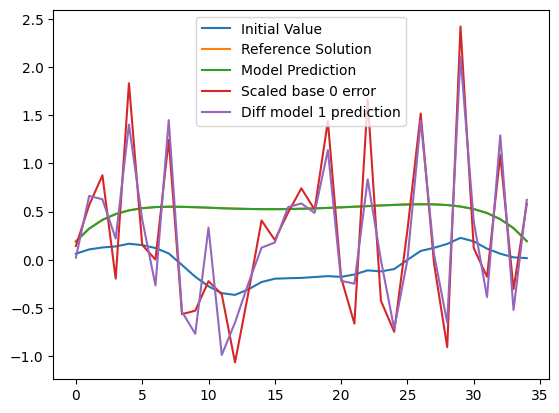

---------NEW RUN---------  i, j =  4 6
------ TRAINING BASE------
0  :  4.561e-06
10  :  1.12e-06
20  :  9.947e-07
30  :  7.717e-07
40  :  6.678e-07
50  :  6.895e-07
60  :  5.58e-07
70  :  5.151e-07
80  :  4.634e-07
90  :  4.49e-07
100  :  3.938e-07
110  :  3.931e-07
120  :  3.562e-07
130  :  3.463e-07
140  :  3.553e-07
150  :  3.5e-07
160  :  3.047e-07
170  :  3.103e-07
180  :  3.166e-07
190  :  3.225e-07
200  :  3.164e-07
210  :  3.152e-07
220  :  2.991e-07
230  :  2.955e-07
240  :  2.769e-07
250  :  2.607e-07
260  :  3.007e-07
270  :  2.814e-07
280  :  2.882e-07
290  :  2.847e-07
300  :  2.566e-07
310  :  2.675e-07
320  :  2.564e-07
330  :  2.547e-07
340  :  2.515e-07
350  :  2.305e-07
360  :  2.479e-07
370  :  2.533e-07
380  :  2.403e-07
390  :  2.405e-07
400  :  2.531e-07
410  :  2.279e-07
420  :  2.359e-07
430  :  2.257e-07
440  :  2.172e-07
450  :  2.427e-07
460  :  2.166e-07
470  :  2.255e-07
480  :  2.307e-07
490  :  2.101e-07
500  :  2.031e-07
510  :  2.047e-07
520  :  2.045e

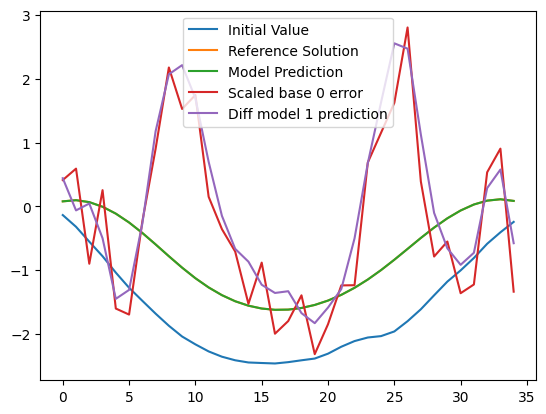

---------NEW RUN---------  i, j =  4 7
------ TRAINING BASE------
0  :  6.975e-06
10  :  1.775e-06
20  :  1.199e-06
30  :  1.229e-06
40  :  9.12e-07
50  :  8.103e-07
60  :  7.109e-07
70  :  6.105e-07
80  :  5.795e-07
90  :  5.06e-07
100  :  4.651e-07
110  :  4.627e-07
120  :  4.305e-07
130  :  3.922e-07
140  :  4.104e-07
150  :  3.79e-07
160  :  3.589e-07
170  :  3.484e-07
180  :  3.32e-07
190  :  3.518e-07
200  :  3.271e-07
210  :  3.341e-07
220  :  3.415e-07
230  :  3.232e-07
240  :  3.205e-07
250  :  3.107e-07
260  :  2.912e-07
270  :  3.148e-07
280  :  2.809e-07
290  :  3.032e-07
300  :  2.94e-07
310  :  2.967e-07
320  :  2.66e-07
330  :  2.883e-07
340  :  2.81e-07
350  :  2.749e-07
360  :  2.676e-07
370  :  2.493e-07
380  :  2.397e-07
390  :  2.632e-07
400  :  2.53e-07
410  :  2.55e-07
420  :  2.369e-07
430  :  2.493e-07
440  :  2.419e-07
450  :  2.265e-07
460  :  2.436e-07
470  :  2.339e-07
480  :  2.211e-07
490  :  2.409e-07
500  :  2.099e-07
510  :  2.364e-07
520  :  2.137e-07


2640  :  0.3547
2650  :  0.3592
2660  :  0.3581
2670  :  0.3491
2680  :  0.3503
2690  :  0.349
2700  :  0.3534
2710  :  0.3547
2720  :  0.356
2730  :  0.3568
2740  :  0.3536
2750  :  0.3532
2760  :  0.348
2770  :  0.3571
2780  :  0.3487
2790  :  0.3539
2800  :  0.355
2810  :  0.3552
2820  :  0.3563
2830  :  0.3517
2840  :  0.3578
2850  :  0.3512
2860  :  0.357
2870  :  0.3553
2880  :  0.3551
2890  :  0.3474
2900  :  0.3529
2910  :  0.3508
2920  :  0.3541
2930  :  0.3551
2940  :  0.3477
2950  :  0.3498
2960  :  0.3535
2970  :  0.353
2980  :  0.3582
    New learning rate:  8e-05
2990  :  0.3475
3000  :  0.3536
3010  :  0.3524
3020  :  0.3473
3030  :  0.3509
3040  :  0.3542
3050  :  0.354
3060  :  0.3525
3070  :  0.3498
3080  :  0.3526
3090  :  0.3488
3100  :  0.358
3110  :  0.3498
3120  :  0.3525
3130  :  0.3512
3140  :  0.354
3150  :  0.3552
    New learning rate:  1.6000000000000003e-05
3160  :  0.3474
3170  :  0.3509
3180  :  0.3486
3190  :  0.3479
3200  :  0.3519
3210  :  0.3542
3220

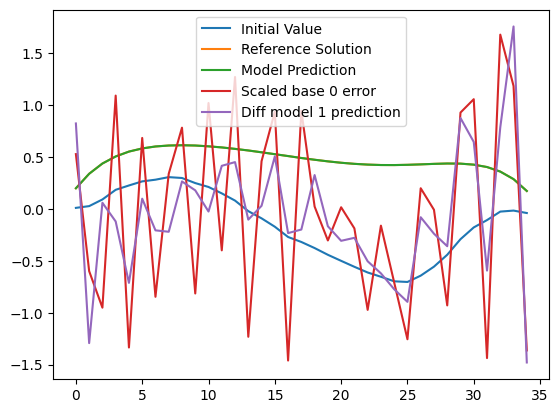

---------NEW RUN---------  i, j =  4 8
------ TRAINING BASE------
0  :  9.458e-06
10  :  3.074e-06
20  :  1.825e-06
30  :  1.776e-06
40  :  1.404e-06
50  :  1.227e-06
60  :  1.182e-06
70  :  1.053e-06
80  :  9.541e-07
90  :  8.049e-07
100  :  7.912e-07
110  :  6.455e-07
120  :  5.918e-07
130  :  5.852e-07
140  :  5.261e-07
150  :  5.453e-07
160  :  5.504e-07
170  :  5.411e-07
180  :  4.58e-07
190  :  4.918e-07
200  :  4.204e-07
210  :  4.473e-07
220  :  4.367e-07
230  :  4.335e-07
240  :  4.324e-07
250  :  3.845e-07
260  :  3.686e-07
270  :  3.943e-07
280  :  3.989e-07
290  :  3.641e-07
300  :  3.54e-07
310  :  3.599e-07
320  :  3.549e-07
330  :  3.489e-07
340  :  3.545e-07
350  :  3.243e-07
360  :  3.122e-07
370  :  3.219e-07
380  :  3.054e-07
390  :  3.264e-07
400  :  3.174e-07
410  :  3.238e-07
420  :  3.137e-07
430  :  2.943e-07
440  :  2.876e-07
450  :  3.073e-07
460  :  2.676e-07
470  :  2.965e-07
480  :  2.952e-07
490  :  2.833e-07
500  :  2.829e-07
510  :  2.65e-07
520  :  2.76

2300  :  0.3359
2310  :  0.3374
2320  :  0.3369
2330  :  0.332
2340  :  0.3344
2350  :  0.3266
2360  :  0.3351
2370  :  0.3359
2380  :  0.3354
2390  :  0.334
2400  :  0.3267
2410  :  0.3307
2420  :  0.3314
2430  :  0.3288
2440  :  0.3288
2450  :  0.3289
2460  :  0.3354
2470  :  0.3291
2480  :  0.3268
2490  :  0.3322
2500  :  0.3223
2510  :  0.3268
2520  :  0.3317
2530  :  0.3257
2540  :  0.3259
2550  :  0.3224
2560  :  0.326
2570  :  0.3302
2580  :  0.3247
2590  :  0.3295
2600  :  0.3219
2610  :  0.3204
2620  :  0.3264
2630  :  0.3185
2640  :  0.3184
2650  :  0.3134
2660  :  0.3118
2670  :  0.3159
2680  :  0.3118
2690  :  0.3217
2700  :  0.3151
2710  :  0.317
2720  :  0.3106
2730  :  0.3145
2740  :  0.3179
2750  :  0.3104
2760  :  0.3204
2770  :  0.3159
2780  :  0.3119
2790  :  0.3151
2800  :  0.3215
2810  :  0.3125
2820  :  0.3158
2830  :  0.3133
2840  :  0.3164
2850  :  0.3166
2860  :  0.3091
2870  :  0.3121
2880  :  0.3011
2890  :  0.3062
2900  :  0.311
2910  :  0.316
2920  :  0.308

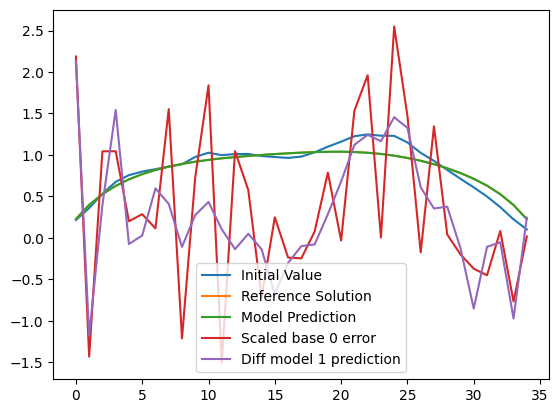

---------NEW RUN---------  i, j =  5 0
------ TRAINING BASE------
0  :  5.18e-06
10  :  3.724e-06
20  :  2.682e-06
30  :  2.15e-06
40  :  1.986e-06
50  :  1.594e-06
60  :  1.578e-06
70  :  1.264e-06
80  :  1.178e-06
90  :  1.217e-06
100  :  1.118e-06
110  :  9.754e-07
120  :  9.556e-07
130  :  8.607e-07
140  :  8.055e-07
150  :  7.991e-07
160  :  8.026e-07
170  :  6.404e-07
180  :  6.738e-07
190  :  6.828e-07
200  :  5.496e-07
210  :  5.561e-07
220  :  5.383e-07
230  :  5.531e-07
240  :  4.956e-07
250  :  5.422e-07
260  :  5.127e-07
270  :  4.972e-07
280  :  4.22e-07
290  :  4.894e-07
300  :  4.77e-07
310  :  4.329e-07
320  :  4.46e-07
330  :  3.75e-07
340  :  3.703e-07
350  :  4.194e-07
360  :  4.525e-07
370  :  3.726e-07
380  :  3.557e-07
390  :  3.972e-07
400  :  3.433e-07
410  :  3.812e-07
420  :  3.506e-07
430  :  3.664e-07
440  :  3.701e-07
450  :  3.275e-07
460  :  3.36e-07
470  :  3.361e-07
480  :  3.504e-07
490  :  3.599e-07
500  :  3.308e-07
510  :  3.173e-07
520  :  3.303e-0

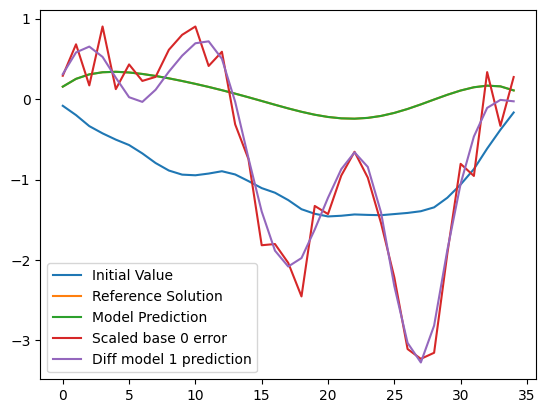

---------NEW RUN---------  i, j =  5 1
------ TRAINING BASE------
0  :  3.961e-06
10  :  2.907e-06
20  :  2.602e-06
30  :  2.192e-06
40  :  1.707e-06
50  :  1.574e-06
60  :  1.414e-06
70  :  1.347e-06
80  :  1.113e-06
90  :  1.13e-06
100  :  1.082e-06
110  :  1.057e-06
120  :  9.792e-07
130  :  9.268e-07
140  :  8.798e-07
150  :  7.869e-07
160  :  7.806e-07
170  :  6.462e-07
180  :  7.708e-07
190  :  6.246e-07
200  :  6.978e-07
210  :  6.306e-07
220  :  5.911e-07
230  :  5.607e-07
240  :  5.399e-07
250  :  5.058e-07
260  :  5.335e-07
270  :  5.03e-07
280  :  4.964e-07
290  :  4.584e-07
300  :  4.38e-07
310  :  4.578e-07
320  :  4.122e-07
330  :  4.084e-07
340  :  4.234e-07
350  :  3.955e-07
360  :  4.06e-07
370  :  3.914e-07
380  :  3.55e-07
390  :  3.83e-07
400  :  3.327e-07
410  :  3.871e-07
420  :  3.618e-07
430  :  3.514e-07
440  :  3.534e-07
450  :  3.464e-07
460  :  3.435e-07
470  :  3.206e-07
480  :  2.945e-07
490  :  3.413e-07
500  :  3.288e-07
510  :  3.089e-07
520  :  2.958e-

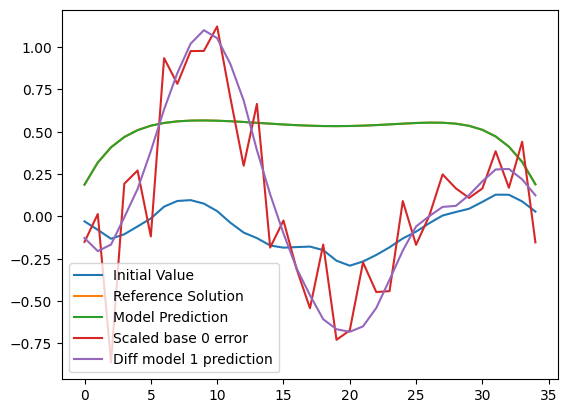

---------NEW RUN---------  i, j =  5 2
------ TRAINING BASE------
0  :  3.052e-06
10  :  2.364e-06
20  :  1.997e-06
30  :  1.648e-06
40  :  1.535e-06
50  :  1.246e-06
60  :  1.11e-06
70  :  1.145e-06
80  :  9.929e-07
90  :  1.036e-06
100  :  9.274e-07
110  :  8.739e-07
120  :  8.372e-07
130  :  7.705e-07
140  :  7.527e-07
150  :  6.336e-07
160  :  6.031e-07
170  :  6.453e-07
180  :  6.538e-07
190  :  6.371e-07
200  :  5.35e-07
210  :  5.773e-07
220  :  4.945e-07
230  :  5.019e-07
240  :  5.138e-07
250  :  4.67e-07
260  :  4.395e-07
270  :  4.247e-07
280  :  4.831e-07
290  :  4.18e-07
300  :  4.401e-07
310  :  3.94e-07
320  :  4.318e-07
330  :  3.623e-07
340  :  3.755e-07
350  :  4.188e-07
360  :  3.705e-07
370  :  3.655e-07
380  :  3.221e-07
390  :  3.239e-07
400  :  3.725e-07
410  :  3.187e-07
420  :  3.107e-07
430  :  3.046e-07
440  :  3.232e-07
450  :  3.014e-07
460  :  2.831e-07
470  :  3.14e-07
480  :  3.142e-07
490  :  2.78e-07
500  :  2.679e-07
510  :  2.595e-07
520  :  2.807e-0

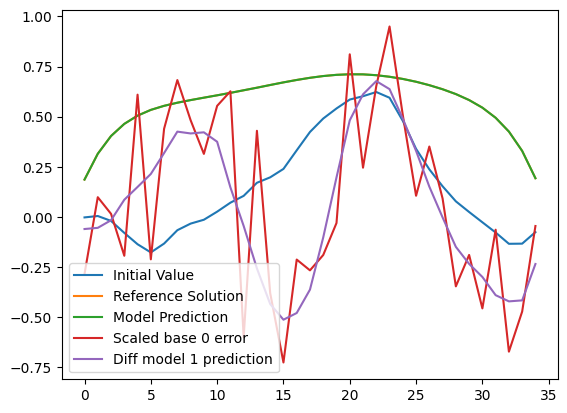

---------NEW RUN---------  i, j =  5 3
------ TRAINING BASE------
0  :  2.836e-06
10  :  1.836e-06
20  :  1.585e-06
30  :  1.401e-06
40  :  1.133e-06
50  :  1.049e-06
60  :  1.022e-06
70  :  8.732e-07
80  :  8.051e-07
90  :  7.49e-07
100  :  7.587e-07
110  :  7.102e-07
120  :  6.567e-07
130  :  6.683e-07
140  :  6.315e-07
150  :  6.345e-07
160  :  5.544e-07
170  :  5.393e-07
180  :  5.622e-07
190  :  5.275e-07
200  :  5.038e-07
210  :  4.677e-07
220  :  4.557e-07
230  :  4.565e-07
240  :  4.528e-07
250  :  4.411e-07
260  :  4.511e-07
270  :  4.085e-07
280  :  3.935e-07
290  :  4.059e-07
300  :  3.401e-07
310  :  3.203e-07
320  :  3.463e-07
330  :  3.156e-07
340  :  3.485e-07
350  :  3.496e-07
360  :  2.856e-07
370  :  3.124e-07
380  :  2.972e-07
390  :  2.96e-07
400  :  2.821e-07
410  :  2.944e-07
420  :  2.567e-07
430  :  2.872e-07
440  :  2.572e-07
450  :  2.608e-07
460  :  2.873e-07
470  :  2.387e-07
480  :  2.559e-07
490  :  2.427e-07
500  :  2.587e-07
510  :  2.631e-07
520  :  2.2

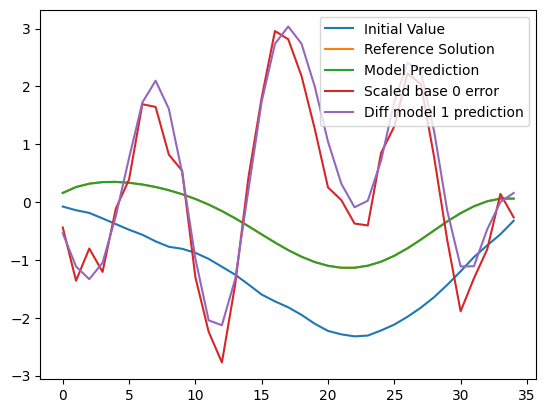

---------NEW RUN---------  i, j =  5 4
------ TRAINING BASE------
0  :  2.926e-06
10  :  1.269e-06
20  :  1.189e-06
30  :  1.031e-06
40  :  9.426e-07
50  :  9.14e-07
60  :  7.634e-07
70  :  7.12e-07
80  :  6.878e-07
90  :  6.56e-07
100  :  5.846e-07
110  :  6.226e-07
120  :  5.911e-07
130  :  5.44e-07
140  :  5.34e-07
150  :  5.049e-07
160  :  5.063e-07
170  :  5.039e-07
180  :  4.548e-07
190  :  4.351e-07
200  :  4.194e-07
210  :  4.361e-07
220  :  3.927e-07
230  :  3.924e-07
240  :  3.763e-07
250  :  3.602e-07
260  :  3.784e-07
270  :  3.756e-07
280  :  3.591e-07
290  :  3.195e-07
300  :  3.319e-07
310  :  3.603e-07
320  :  3.102e-07
330  :  3.276e-07
340  :  2.77e-07
350  :  3.335e-07
360  :  2.625e-07
370  :  2.84e-07
380  :  2.63e-07
390  :  2.789e-07
400  :  2.802e-07
410  :  2.308e-07
420  :  2.756e-07
430  :  2.674e-07
440  :  2.58e-07
450  :  2.522e-07
460  :  2.326e-07
470  :  2.428e-07
480  :  2.506e-07
490  :  2.167e-07
500  :  2.192e-07
510  :  2.279e-07
520  :  2.215e-07


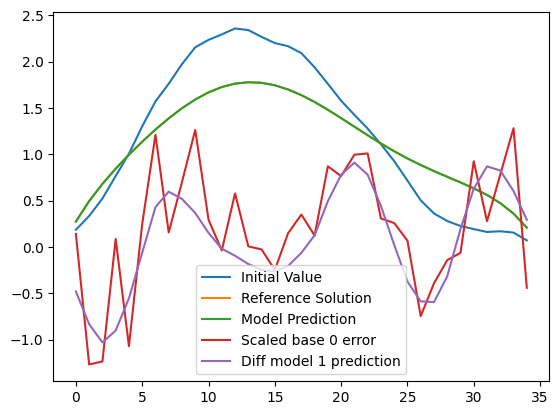

---------NEW RUN---------  i, j =  5 5
------ TRAINING BASE------
0  :  3.295e-06
10  :  1.106e-06
20  :  1.014e-06
30  :  7.592e-07
40  :  7.342e-07
50  :  6.824e-07
60  :  5.807e-07
70  :  5.367e-07
80  :  5.887e-07
90  :  5.429e-07
100  :  5.109e-07
110  :  4.591e-07
120  :  4.636e-07
130  :  4.587e-07
140  :  4.098e-07
150  :  4.437e-07
160  :  4.023e-07
170  :  4.147e-07
180  :  3.962e-07
190  :  3.855e-07
200  :  3.565e-07
210  :  3.925e-07
220  :  3.636e-07
230  :  3.811e-07
240  :  3.514e-07
250  :  3.737e-07
260  :  3.492e-07
270  :  3.332e-07
280  :  3.124e-07
290  :  3.2e-07
300  :  3.25e-07
310  :  2.823e-07
320  :  3.081e-07
330  :  2.535e-07
340  :  2.774e-07
350  :  2.774e-07
360  :  2.679e-07
370  :  2.822e-07
380  :  2.873e-07
390  :  2.694e-07
400  :  2.62e-07
410  :  2.683e-07
420  :  2.192e-07
430  :  2.428e-07
440  :  2.256e-07
450  :  2.117e-07
460  :  2.122e-07
470  :  2.194e-07
480  :  2.198e-07
490  :  1.964e-07
500  :  2.404e-07
510  :  2.269e-07
520  :  2.236

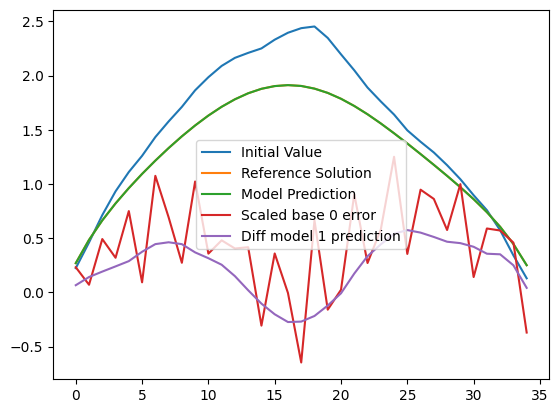

---------NEW RUN---------  i, j =  5 6
------ TRAINING BASE------
0  :  4.799e-06
10  :  1.121e-06
20  :  9.276e-07
30  :  8.266e-07
40  :  7.396e-07
50  :  7.084e-07
60  :  6.105e-07
70  :  5.458e-07
80  :  5.32e-07
90  :  5.346e-07
100  :  4.721e-07
110  :  5.206e-07
120  :  3.983e-07
130  :  4.004e-07
140  :  4.062e-07
150  :  3.615e-07
160  :  3.81e-07
170  :  3.526e-07
180  :  4.037e-07
190  :  3.327e-07
200  :  3.706e-07
210  :  3.388e-07
220  :  3.668e-07
230  :  3.618e-07
240  :  3.123e-07
250  :  3.132e-07
260  :  3.103e-07
270  :  3.33e-07
280  :  3.274e-07
290  :  3.105e-07
300  :  3.147e-07
310  :  2.926e-07
320  :  2.787e-07
330  :  2.603e-07
340  :  2.712e-07
350  :  2.722e-07
360  :  2.714e-07
370  :  2.949e-07
380  :  2.609e-07
390  :  2.466e-07
400  :  2.526e-07
410  :  2.752e-07
420  :  2.509e-07
430  :  2.461e-07
440  :  2.398e-07
450  :  2.372e-07
460  :  2.4e-07
470  :  2.26e-07
480  :  2.25e-07
490  :  2.039e-07
500  :  2.312e-07
510  :  2.496e-07
520  :  1.98e-07

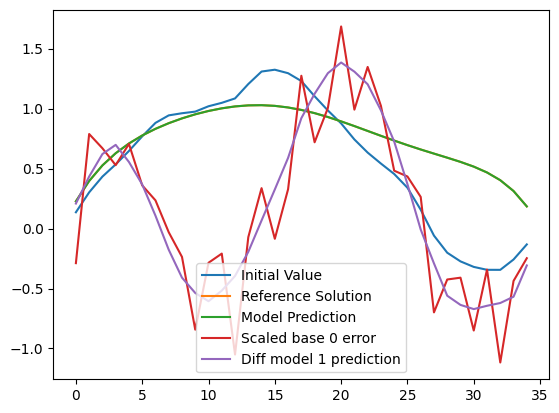

---------NEW RUN---------  i, j =  5 7
------ TRAINING BASE------
0  :  6.536e-06
10  :  1.696e-06
20  :  1.278e-06
30  :  1.199e-06
40  :  9.618e-07
50  :  8.915e-07
60  :  7.823e-07
70  :  7.06e-07
80  :  6.549e-07
90  :  6.091e-07
100  :  5.055e-07
110  :  5.182e-07
120  :  5.284e-07
130  :  4.438e-07
140  :  4.478e-07
150  :  4.204e-07
160  :  4.428e-07
170  :  4.392e-07
180  :  4.011e-07
190  :  3.582e-07
200  :  3.867e-07
210  :  3.752e-07
220  :  3.58e-07
230  :  4.003e-07
240  :  3.308e-07
250  :  3.44e-07
260  :  3.674e-07
270  :  3.632e-07
280  :  3.076e-07
290  :  3.424e-07
300  :  3.351e-07
310  :  3.031e-07
320  :  3.365e-07
330  :  3.112e-07
340  :  3.068e-07
350  :  3.274e-07
360  :  2.921e-07
370  :  3e-07
380  :  2.84e-07
390  :  2.836e-07
400  :  2.761e-07
410  :  3.026e-07
420  :  2.825e-07
430  :  2.622e-07
440  :  2.873e-07
450  :  2.725e-07
460  :  2.609e-07
470  :  2.745e-07
480  :  2.487e-07
490  :  2.382e-07
500  :  2.546e-07
510  :  2.31e-07
520  :  2.437e-07


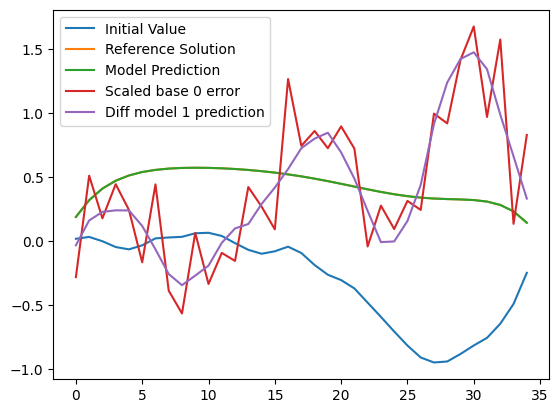

---------NEW RUN---------  i, j =  5 8
------ TRAINING BASE------
0  :  9.825e-06
10  :  2.818e-06
20  :  2.002e-06
30  :  1.796e-06
40  :  1.519e-06
50  :  1.327e-06
60  :  1.094e-06
70  :  1.007e-06
80  :  9.557e-07
90  :  8.351e-07
100  :  7.856e-07
110  :  7.741e-07
120  :  6.726e-07
130  :  6.113e-07
140  :  6.119e-07
150  :  5.594e-07
160  :  5.719e-07
170  :  5.667e-07
180  :  4.924e-07
190  :  5.23e-07
200  :  5.258e-07
210  :  5.016e-07
220  :  5.273e-07
230  :  4.86e-07
240  :  4.845e-07
250  :  4.501e-07
260  :  4.863e-07
270  :  4.349e-07
280  :  4.549e-07
290  :  4.077e-07
300  :  3.906e-07
310  :  4.368e-07
320  :  4.011e-07
330  :  4.15e-07
340  :  3.601e-07
350  :  3.875e-07
360  :  3.877e-07
370  :  3.692e-07
380  :  3.765e-07
390  :  3.431e-07
400  :  3.362e-07
410  :  3.361e-07
420  :  3.172e-07
430  :  3.727e-07
440  :  3.468e-07
450  :  3.172e-07
460  :  3.179e-07
470  :  3.227e-07
480  :  2.922e-07
490  :  3.054e-07
500  :  3.16e-07
510  :  3.203e-07
520  :  3.11e

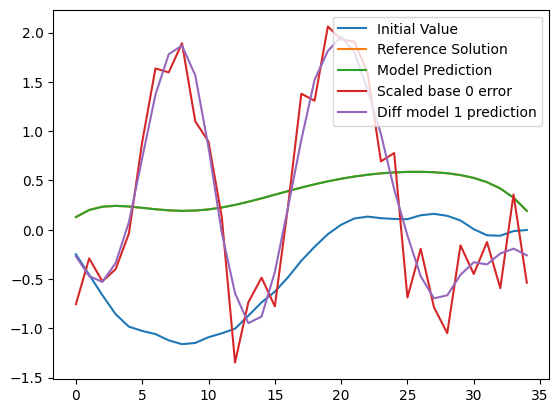

---------NEW RUN---------  i, j =  6 0
------ TRAINING BASE------
0  :  5.763e-06
10  :  4.112e-06
20  :  2.987e-06
30  :  2.44e-06
40  :  2.113e-06
50  :  1.743e-06
60  :  1.507e-06
70  :  1.285e-06
80  :  1.314e-06
90  :  1.324e-06
100  :  9.582e-07
110  :  8.523e-07
120  :  9.106e-07
130  :  9.02e-07
140  :  8.115e-07
150  :  7.591e-07
160  :  7.442e-07
170  :  8.168e-07
180  :  6.951e-07
190  :  7.355e-07
200  :  6.265e-07
210  :  5.755e-07
220  :  5.837e-07
230  :  6.427e-07
240  :  6.03e-07
250  :  5.532e-07
260  :  5.155e-07
270  :  5.026e-07
280  :  5.275e-07
290  :  4.409e-07
300  :  4.29e-07
310  :  4.349e-07
320  :  4.582e-07
330  :  3.968e-07
340  :  4.534e-07
350  :  4.106e-07
360  :  3.832e-07
370  :  4.325e-07
380  :  4.032e-07
390  :  3.72e-07
400  :  3.642e-07
410  :  4.041e-07
420  :  4.218e-07
430  :  3.963e-07
440  :  3.997e-07
450  :  3.69e-07
460  :  3.942e-07
470  :  3.738e-07
480  :  3.481e-07
490  :  3.526e-07
500  :  3.227e-07
510  :  3.606e-07
520  :  3.581e-

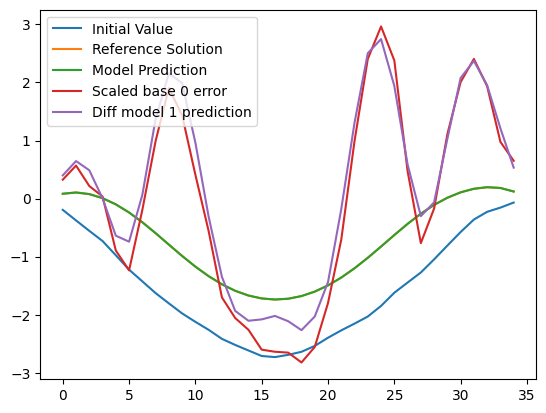

---------NEW RUN---------  i, j =  6 1
------ TRAINING BASE------
0  :  4.168e-06
10  :  3.204e-06
20  :  2.49e-06
30  :  2.18e-06
40  :  1.826e-06
50  :  1.678e-06
60  :  1.669e-06
70  :  1.499e-06
80  :  1.184e-06
90  :  1.188e-06
100  :  1.145e-06
110  :  1.025e-06
120  :  9.357e-07
130  :  9.737e-07
140  :  8.699e-07
150  :  8.754e-07
160  :  8.768e-07
170  :  7.736e-07
180  :  6.979e-07
190  :  7.429e-07
200  :  6.361e-07
210  :  6.487e-07
220  :  6.25e-07
230  :  5.264e-07
240  :  5.768e-07
250  :  5.274e-07
260  :  5.422e-07
270  :  5.599e-07
280  :  5.921e-07
290  :  4.894e-07
300  :  4.95e-07
310  :  5.073e-07
320  :  4.277e-07
330  :  5.024e-07
340  :  4.592e-07
350  :  4.085e-07
360  :  4.15e-07
370  :  4.45e-07
380  :  4.195e-07
390  :  4.05e-07
400  :  3.838e-07
410  :  4.499e-07
420  :  3.863e-07
430  :  3.754e-07
440  :  4.253e-07
450  :  3.315e-07
460  :  3.647e-07
470  :  3.494e-07
480  :  3.644e-07
490  :  3.349e-07
500  :  3.305e-07
510  :  3.661e-07
520  :  3.289e-0

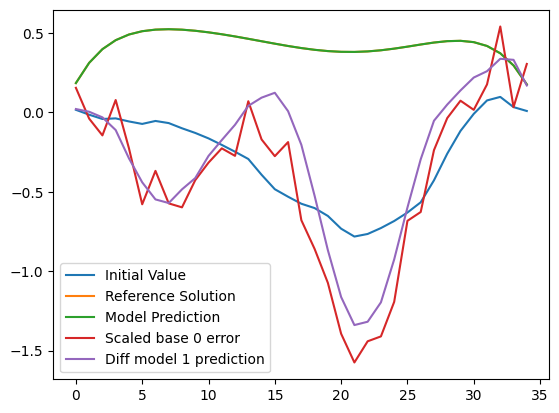

---------NEW RUN---------  i, j =  6 2
------ TRAINING BASE------
0  :  3.264e-06
10  :  2.487e-06
20  :  2.032e-06
30  :  1.701e-06
40  :  1.587e-06
50  :  1.406e-06
60  :  1.218e-06
70  :  1.125e-06
80  :  1.089e-06
90  :  1.116e-06
100  :  1.05e-06
110  :  8.836e-07
120  :  8.67e-07
130  :  8.657e-07
140  :  7.942e-07
150  :  7.597e-07
160  :  7.029e-07
170  :  7.07e-07
180  :  6.967e-07
190  :  6.107e-07
200  :  6.245e-07
210  :  6.156e-07
220  :  6.081e-07
230  :  5.936e-07
240  :  5.289e-07
250  :  5.011e-07
260  :  4.883e-07
270  :  4.951e-07
280  :  4.865e-07
290  :  4.661e-07
300  :  5.278e-07
310  :  4.464e-07
320  :  4.63e-07
330  :  4.339e-07
340  :  4.113e-07
350  :  4.15e-07
360  :  4.309e-07
370  :  4.218e-07
380  :  3.597e-07
390  :  3.604e-07
400  :  3.424e-07
410  :  2.853e-07
420  :  3.792e-07
430  :  3.191e-07
440  :  3.437e-07
450  :  2.768e-07
460  :  3.259e-07
470  :  3.244e-07
480  :  3.348e-07
490  :  2.713e-07
500  :  3.062e-07
510  :  2.735e-07
520  :  2.768e

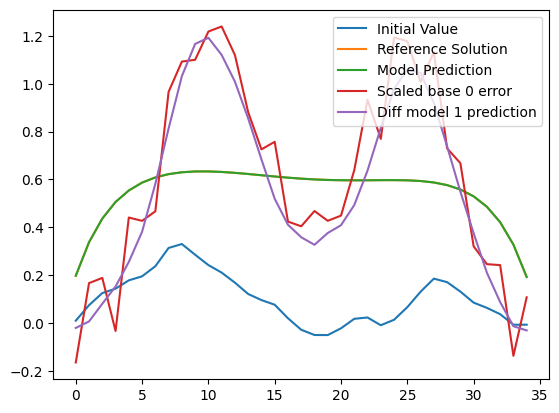

---------NEW RUN---------  i, j =  6 3
------ TRAINING BASE------
0  :  2.79e-06
10  :  1.943e-06
20  :  1.755e-06
30  :  1.388e-06
40  :  1.225e-06
50  :  1.312e-06
60  :  1.095e-06
70  :  1.008e-06
80  :  9.673e-07
90  :  8.581e-07
100  :  8.369e-07
110  :  8.034e-07
120  :  8.021e-07
130  :  7.363e-07
140  :  7.457e-07
150  :  6.842e-07
160  :  7.15e-07
170  :  5.707e-07
180  :  6.589e-07
190  :  5.987e-07
200  :  5.459e-07
210  :  5.208e-07
220  :  5.848e-07
230  :  5.471e-07
240  :  5.022e-07
250  :  5.135e-07
260  :  4.62e-07
270  :  4.41e-07
280  :  4.826e-07
290  :  4.135e-07
300  :  4.496e-07
310  :  4.177e-07
320  :  3.908e-07
330  :  4.381e-07
340  :  4.151e-07
350  :  3.446e-07
360  :  3.482e-07
370  :  3.327e-07
380  :  3.559e-07
390  :  3.142e-07
400  :  3.488e-07
410  :  3.212e-07
420  :  3.149e-07
430  :  3.3e-07
440  :  2.948e-07
450  :  3.011e-07
460  :  3.131e-07
470  :  3.33e-07
480  :  2.931e-07
490  :  2.95e-07
500  :  2.748e-07
510  :  2.478e-07
520  :  2.789e-07

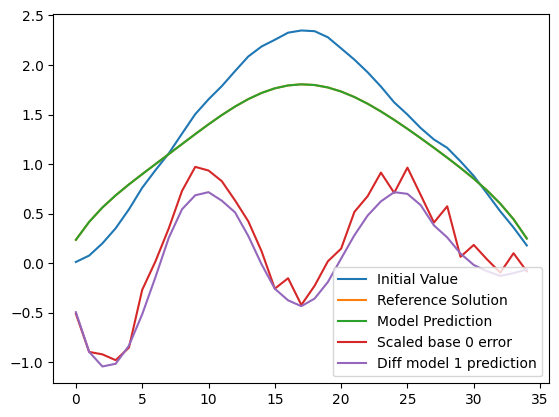

---------NEW RUN---------  i, j =  6 4
------ TRAINING BASE------
0  :  2.931e-06
10  :  1.547e-06
20  :  1.351e-06
30  :  1.245e-06
40  :  1.071e-06
50  :  9.366e-07
60  :  9.464e-07
70  :  8.83e-07
80  :  8.239e-07
90  :  7.808e-07
100  :  7.894e-07
110  :  6.573e-07
120  :  6.447e-07
130  :  6.7e-07
140  :  5.412e-07
150  :  5.931e-07
160  :  6.161e-07
170  :  5.485e-07
180  :  5.339e-07
190  :  5.151e-07
200  :  4.648e-07
210  :  5.293e-07
220  :  5.661e-07
230  :  4.935e-07
240  :  4.437e-07
250  :  4.183e-07
260  :  4.415e-07
270  :  3.988e-07
280  :  4.494e-07
290  :  4.26e-07
300  :  4.175e-07
310  :  3.669e-07
320  :  3.853e-07
330  :  3.653e-07
340  :  3.611e-07
350  :  3.23e-07
360  :  3.504e-07
370  :  3.147e-07
380  :  3.769e-07
390  :  3.141e-07
400  :  3.564e-07
410  :  3.174e-07
420  :  3.129e-07
430  :  2.848e-07
440  :  2.809e-07
450  :  3.078e-07
460  :  2.97e-07
470  :  2.681e-07
480  :  2.942e-07
490  :  2.778e-07
500  :  2.807e-07
510  :  2.786e-07
520  :  2.471e-

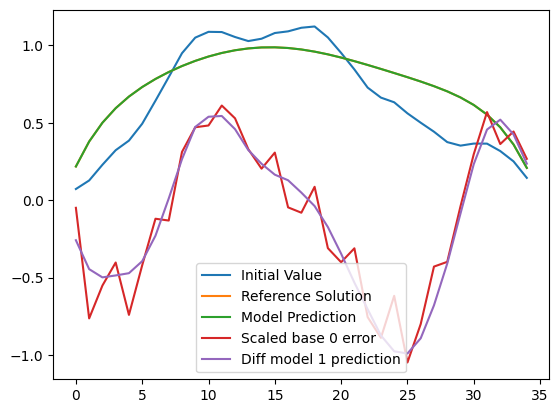

---------NEW RUN---------  i, j =  6 5
------ TRAINING BASE------
0  :  3.417e-06
10  :  1.248e-06
20  :  1.193e-06
30  :  9.528e-07
40  :  9.136e-07
50  :  8.308e-07
60  :  7.424e-07
70  :  7.629e-07
80  :  6.914e-07
90  :  6.437e-07
100  :  6.599e-07
110  :  5.867e-07
120  :  5.782e-07
130  :  5.733e-07
140  :  6.044e-07
150  :  5.038e-07
160  :  4.997e-07
170  :  5.917e-07
180  :  4.431e-07
190  :  4.789e-07
200  :  5.245e-07
210  :  4.03e-07
220  :  4.865e-07
230  :  4.888e-07
240  :  4.331e-07
250  :  4.066e-07
260  :  4.419e-07
270  :  4.266e-07
280  :  4.27e-07
290  :  3.894e-07
300  :  4.131e-07
310  :  3.937e-07
320  :  3.572e-07
330  :  3.739e-07
340  :  3.85e-07
350  :  3.328e-07
360  :  3.446e-07
370  :  3.553e-07
380  :  3.347e-07
390  :  3.235e-07
400  :  3.057e-07
410  :  3.26e-07
420  :  2.901e-07
430  :  2.961e-07
440  :  2.884e-07
450  :  2.628e-07
460  :  3.121e-07
470  :  2.866e-07
480  :  2.977e-07
490  :  2.687e-07
500  :  2.845e-07
510  :  2.893e-07
520  :  2.426

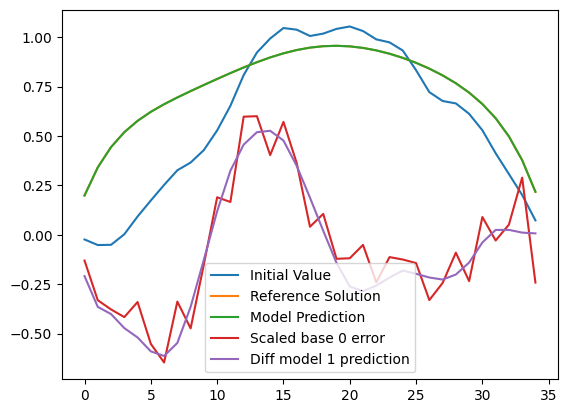

---------NEW RUN---------  i, j =  6 6
------ TRAINING BASE------
0  :  4.947e-06
10  :  1.305e-06
20  :  1.162e-06
30  :  1.011e-06
40  :  9.092e-07
50  :  8.121e-07
60  :  7.138e-07
70  :  6.953e-07
80  :  7.028e-07
90  :  6.887e-07
100  :  6.312e-07
110  :  5.587e-07
120  :  5.522e-07
130  :  5.46e-07
140  :  5.56e-07
150  :  4.575e-07
160  :  4.992e-07
170  :  5.097e-07
180  :  5.352e-07
190  :  4.676e-07
200  :  4.549e-07
210  :  5.101e-07
220  :  4.791e-07
230  :  4.615e-07
240  :  4.137e-07
250  :  4.264e-07
260  :  3.682e-07
270  :  4.251e-07
280  :  3.941e-07
290  :  3.495e-07
300  :  4.056e-07
310  :  3.624e-07
320  :  3.849e-07
330  :  4.11e-07
340  :  3.24e-07
350  :  3.937e-07
360  :  3.271e-07
370  :  3.207e-07
380  :  3.363e-07
390  :  3.393e-07
400  :  3.105e-07
410  :  2.765e-07
420  :  3.068e-07
430  :  3.468e-07
440  :  3.415e-07
450  :  2.989e-07
460  :  3.147e-07
470  :  2.926e-07
480  :  2.93e-07
490  :  3.195e-07
500  :  3.017e-07
510  :  2.562e-07
520  :  2.823e

2320  :  0.04164
2330  :  0.04067
2340  :  0.04315
2350  :  0.0424
2360  :  0.03972
Training ended due to inssuficient improvement


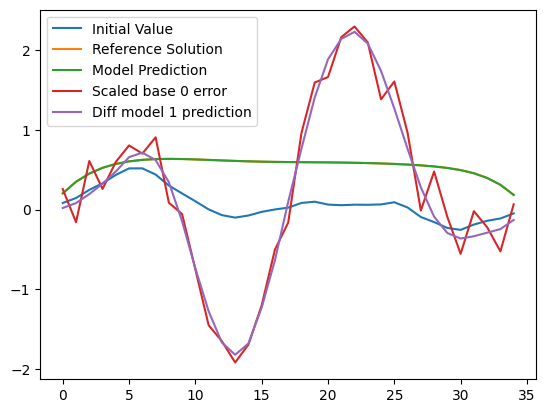

---------NEW RUN---------  i, j =  6 7
------ TRAINING BASE------
0  :  6.602e-06
10  :  1.9e-06
20  :  1.487e-06
30  :  1.45e-06
40  :  1.045e-06
50  :  1.078e-06
60  :  9.345e-07
70  :  8.474e-07
80  :  6.975e-07
90  :  7.176e-07
100  :  6.332e-07
110  :  6.589e-07
120  :  6.688e-07
130  :  5.711e-07
140  :  6.482e-07
150  :  5.744e-07
160  :  5.243e-07
170  :  6.003e-07
180  :  4.805e-07
190  :  4.82e-07
200  :  4.722e-07
210  :  5.59e-07
220  :  4.653e-07
230  :  4.386e-07
240  :  4.785e-07
250  :  4.912e-07
260  :  4.579e-07
270  :  4.413e-07
280  :  4.734e-07
290  :  4.423e-07
300  :  4.465e-07
310  :  4.058e-07
320  :  3.869e-07
330  :  4.245e-07
340  :  3.908e-07
350  :  4.248e-07
360  :  4.196e-07
370  :  4.013e-07
380  :  3.911e-07
390  :  3.67e-07
400  :  4.026e-07
410  :  3.524e-07
420  :  3.563e-07
430  :  3.592e-07
440  :  3.317e-07
450  :  3.334e-07
460  :  3.406e-07
470  :  3.217e-07
480  :  3.394e-07
490  :  3.219e-07
500  :  3.044e-07
510  :  2.77e-07
520  :  3.601e-0

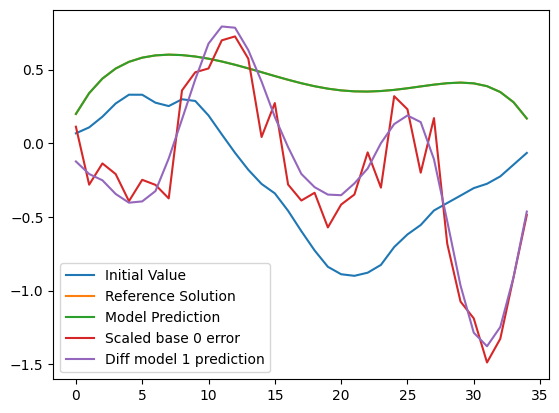

---------NEW RUN---------  i, j =  6 8
------ TRAINING BASE------
0  :  8.884e-06
10  :  2.694e-06
20  :  2.059e-06
30  :  1.967e-06
40  :  1.666e-06
50  :  1.376e-06
60  :  1.188e-06
70  :  1.176e-06
80  :  1.175e-06
90  :  1.017e-06
100  :  9.501e-07
110  :  8.705e-07
120  :  8.489e-07
130  :  8.379e-07
140  :  7.38e-07
150  :  7.696e-07
160  :  6.926e-07
170  :  7.159e-07
180  :  6.351e-07
190  :  7.316e-07
200  :  6.073e-07
210  :  6.619e-07
220  :  5.991e-07
230  :  5.568e-07
240  :  6.137e-07
250  :  5.919e-07
260  :  5.212e-07
270  :  5.28e-07
280  :  5.399e-07
290  :  5.37e-07
300  :  5.239e-07
310  :  5.485e-07
320  :  5.747e-07
330  :  4.967e-07
340  :  5.419e-07
350  :  5.003e-07
360  :  4.742e-07
370  :  4.671e-07
380  :  4.271e-07
390  :  4.994e-07
400  :  4.275e-07
410  :  4.148e-07
420  :  4.478e-07
430  :  4.325e-07
440  :  4.295e-07
450  :  3.908e-07
460  :  3.901e-07
470  :  4.086e-07
480  :  3.879e-07
490  :  4.373e-07
500  :  4.097e-07
510  :  4.032e-07
520  :  3.68

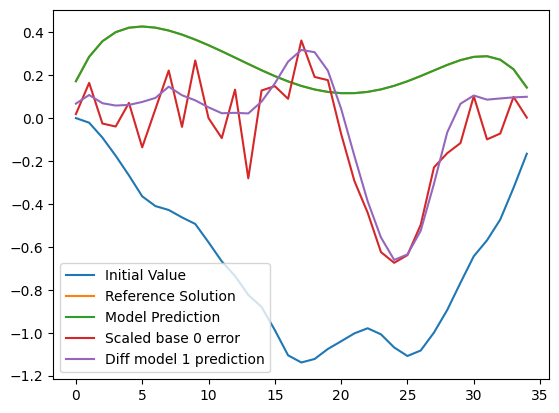

In [7]:
p1_values = np.linspace(grid_p1_low, grid_p1_high, grid_nr_p1_steps)
p2_values = np.linspace(grid_p2_low, grid_p2_high, grid_nr_p2_steps)
grid_p1s, grid_p2s = np.meshgrid(p1_values, p2_values)

#Prepare placeholders for errors
grid_start_errors = np.zeros_like(grid_p1s)
grid_end_errors_base = np.zeros_like(grid_p1s)
grid_end_errors = np.zeros_like(grid_p1s)

#Prepare placeholders for training times
base_traintimes = np.zeros_like(grid_p1s)
diff_traintimes = np.zeros_like(grid_p1s)


#Store the results
surface_foldername = "Results_surface"
surface_foldername_full = os.getcwd() + "/" + surface_foldername #for shutil.copyfile
if not os.path.exists(surface_foldername):
        os.makedirs(surface_foldername)

with open(surface_foldername + '/surface_simulation_results.txt', 'w+') as f:
    start_time = time.perf_counter()
    for i in range(grid_nr_p2_steps):
        for j in range(grid_nr_p1_steps):
            print("---------NEW RUN---------  i, j = ", i, j)
            print("--------------------------------------RUN (" + str(i) + "," + str(j) + ") : [" + str(grid_p1s[i,j]) + "," + str(grid_p2s[i,j]) + "]--------------------------------------", file = f)

            difference_learning_model = Difference_learning_model(T, 
                                                                  pde,
                                                                  nr_spacediscr,
                                                                  base = Second_order_LIRK_model, 
                                                                  nr_timesteps_base = nr_timesteps, 
                                                                  params_base = [[grid_p1s[i,j]], [grid_p2s[i,j]]], 
                                                                  diff_classes = [diff_model_class], 
                                                                  diff_params = [diff_model_params], 
                                                                  training_samples_generator = training_samples_generator,
                                                                  learning_rate = base_initial_lr)


            grid_start_errors[i,j] = evaluate(difference_learning_model.base_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model.base_model, surface_foldername + "/Z_start_error_" + str(i) + str(j))
                  
            base_traintimes[i,j], diff_traintimes[i,j] = \
                            multi_difference_model_training(difference_learning_model, 
                                initial_learning_rates = [base_initial_lr, diff_initial_lr], 
                                initial_batch_sizes = [base_initial_batchsize, diff_initial_batchsize], 
                                tolerances = [base_tolerance, diff_tolerance], 
                                max_trainsteps = [base_max_trainsteps, diff_max_trainsteps], 
                                evaluate_steps = eval_steps, 
                                estimate_samples = est_samples,
                                evaluate_samples = eval_samples)
            
            grid_end_errors_base[i,j] = evaluate(difference_learning_model.base_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model.base_model, surface_foldername + "/Z_end_error_base_" + str(i) + str(j))

            grid_end_errors[i,j] = evaluate(difference_learning_model, evaluate_samples = end_eval_samples)
            csv_summary(difference_learning_model, surface_foldername + "/Z_end_error_" + str(i) + str(j))
                  
            summary(difference_learning_model, multidiff_model = True, write_file = f, plot_file_name = surface_foldername + "/Z_plot_" + str(i) + str(j))
            print("\n\n", file = f)
    
    
    
    best_start = np.unravel_index(grid_start_errors.argmin(), grid_start_errors.shape)
    best_trained_base = np.unravel_index(grid_end_errors_base.argmin(), grid_end_errors_base.shape)
    best_full_adann = np.unravel_index(grid_end_errors.argmin(), grid_end_errors.shape) 
    
    total_time = time.perf_counter() - start_time 
    
    #Copy best error files
    shutil.copyfile(surface_foldername_full + "/Z_start_error_" + str(best_start[0]) + str(best_start[1]) + ".csv", surface_foldername_full + "/grid_best_start_error_" + str(best_start[0]) + str(best_start[1]) + ".csv")
    shutil.copyfile(surface_foldername_full + "/Z_end_error_base_" + str(best_trained_base[0]) + str(best_trained_base[1]) + ".csv", surface_foldername_full + "/grid_best_end_error_base_" + str(best_trained_base[0]) + str(best_trained_base[1]) + ".csv")
    shutil.copyfile(surface_foldername_full + "/Z_end_error_" + str(best_full_adann[0]) + str(best_full_adann[1]) + ".csv", surface_foldername_full + "/grid_best_end_error_" + str(best_full_adann[0]) + str(best_full_adann[1]) + ".csv")

    
    #Print some summary values
    
    print("\n\n\n--------------------------------------", file = f)
    
    print("Best errors:", file = f)
    print("    Best start: ", grid_start_errors[best_start], best_start, file = f)
    print("    Best trained base: ", grid_end_errors_base[best_trained_base], best_trained_base, file = f)
    print("    Best full ADANN: ", grid_end_errors[best_full_adann], best_full_adann, file = f)
    
    
    print("\nTrain times:", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", np.sum(base_traintimes) + np.sum(diff_traintimes), file = f)
    print("    Total base train time: ", np.sum(base_traintimes), file = f)
    print("    Total diff train time: ", np.sum(diff_traintimes), file = f)
    print("\n    Average train time: ", np.mean(base_traintimes) + np.mean(diff_traintimes), file = f)
    print("    Average base train time: ", np.mean(base_traintimes), file = f)
    print("    Average diff train time: ", np.mean(diff_traintimes), file = f)
    

#Save error data
with open(surface_foldername + "/Y_grid_start_errors.txt", 'w+') as f:
    print(grid_start_errors, file = f)
with open(surface_foldername + "/Y_grid_end_errors_base.txt", 'w+') as f:
    print(grid_end_errors_base, file = f)
with open(surface_foldername + "/Y_end_errors.txt", 'w+') as f:
    print(grid_end_errors, file = f)
with open(surface_foldername + "/Y_grid_p1s.txt", 'w+') as f:
    print(grid_p1s, file = f)
with open(surface_foldername + "/Y_grid_p2s.txt", 'w+') as f:
    print(grid_p2s, file = f)

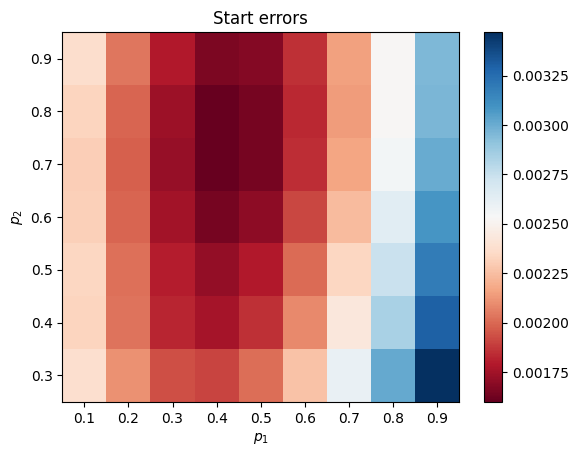

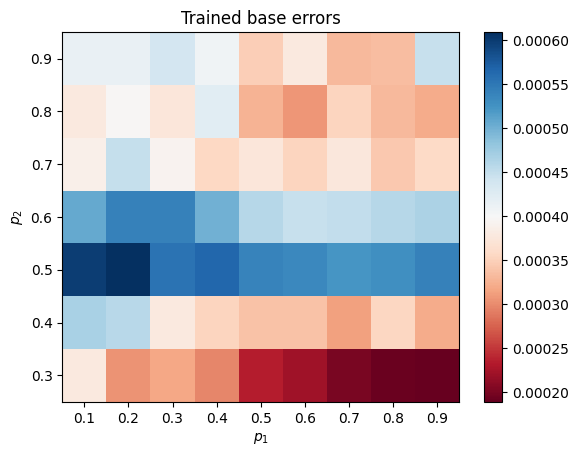

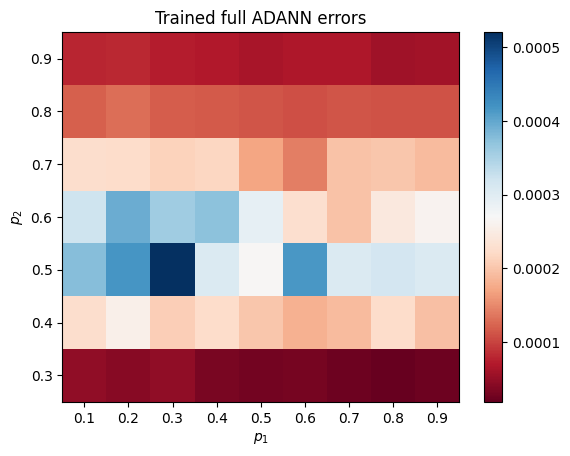

In [8]:
# start_errors = np.loadtxt("Y_start_errors.txt")
# end_errors_base = np.loadtxt("Y_end_errors_base.txt")
# end_errors = np.loadtxt("Y_end_errors.txt")

#Create heat maps to show the errors
start_errors_masked = np.ma.masked_invalid(grid_start_errors)
err_min, err_max = start_errors_masked[:].min(), start_errors_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], start_errors_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Start errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_start_errors.pdf")
plt.show()
##############################


end_errors_base_masked = np.ma.masked_invalid(grid_end_errors_base)
err_min, err_max = end_errors_base_masked[:].min(), end_errors_base_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], end_errors_base_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Trained base errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_end_errors_base.pdf")
plt.show()
##############################


end_errors_masked = np.ma.masked_invalid(grid_end_errors)
err_min, err_max = end_errors_masked[:].min(), end_errors_masked[:].max()

fig, ax = plt.subplots()

c = ax.pcolormesh(grid_p1s[:], grid_p2s[:], end_errors_masked[:], cmap='RdBu', vmin=err_min, vmax=err_max)
ax.set_title('Trained full ADANN errors')
ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
fig.colorbar(c, ax=ax)
fig.savefig(surface_foldername + "/grid_end_errors.pdf")
plt.show()

#### ADANN Experiment 2: Optimization based approach

--------------------------------------RUN 0 --------------------------------------
Generated opt_params  0
0  :  3.155e-06
10  :  1.164e-06
20  :  1.099e-06
30  :  8.497e-07
40  :  8.353e-07
50  :  7.685e-07
60  :  6.023e-07
70  :  5.822e-07
80  :  5.858e-07
90  :  5.356e-07
100  :  5.074e-07
110  :  5.063e-07
120  :  4.973e-07
130  :  4.494e-07
140  :  4.891e-07
150  :  4.858e-07
160  :  4.24e-07
170  :  3.973e-07
180  :  4.249e-07
190  :  3.983e-07
200  :  3.967e-07
210  :  3.583e-07
220  :  3.751e-07
230  :  3.753e-07
240  :  3.293e-07
250  :  3.763e-07
260  :  2.996e-07
270  :  3.247e-07
280  :  3.098e-07
290  :  2.993e-07
300  :  3.034e-07
310  :  2.954e-07
320  :  3.021e-07
330  :  2.731e-07
340  :  2.713e-07
350  :  2.825e-07
360  :  2.526e-07
370  :  2.539e-07
380  :  2.56e-07
390  :  2.706e-07
400  :  2.508e-07
410  :  2.544e-07
420  :  2.389e-07
430  :  2.527e-07
440  :  2.273e-07
450  :  2.359e-07
460  :  2.16e-07
470  :  2.185e-07
480  :  2.129e-07
490  :  2.098e-07
500  : 

1920  :  0.2985
1930  :  0.5144
1940  :  0.3868
1950  :  0.3479
1960  :  0.3315
1970  :  0.3108
1980  :  0.3102
1990  :  0.3195
2000  :  0.3272
2010  :  0.3311
2020  :  0.3112
2030  :  0.3908
    New learning rate:  0.002
    New Batch size:  1024
2040  :  0.3352
2050  :  0.3059
2060  :  0.297
2070  :  0.3013
2080  :  0.2855
2090  :  0.2903
2100  :  0.2878
2110  :  0.2952
2120  :  0.2898
2130  :  0.2873
2140  :  0.2865
2150  :  0.2847
2160  :  0.2752
2170  :  0.292
2180  :  0.2863
2190  :  0.2811
2200  :  0.2856
2210  :  0.2873
2220  :  0.2831
2230  :  0.2845
2240  :  0.2837
2250  :  0.2803
2260  :  0.2761
2270  :  0.2739
2280  :  0.2816
2290  :  0.2699
2300  :  0.2705
2310  :  0.2776
2320  :  0.2785
2330  :  0.2724
2340  :  0.2647
2350  :  0.2739
2360  :  0.2656
2370  :  0.2774
2380  :  0.279
2390  :  0.275
2400  :  0.2714
2410  :  0.2788
2420  :  0.2784
2430  :  0.2628
2440  :  0.2709
2450  :  0.2662
2460  :  0.273
2470  :  0.2688
2480  :  0.2679
2490  :  0.266
2500  :  0.2716
2510  

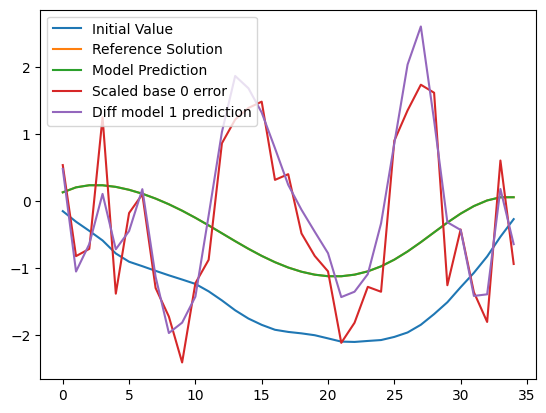

--------------------------------------RUN 1 --------------------------------------
Generated opt_params  1
0  :  3.496e-06
10  :  1.046e-06
20  :  1.052e-06
30  :  8.628e-07
40  :  7.909e-07
50  :  6.664e-07
60  :  6.441e-07
70  :  5.891e-07
80  :  5.472e-07
90  :  5.534e-07
100  :  5.16e-07
110  :  4.622e-07
120  :  4.921e-07
130  :  4.404e-07
140  :  4.347e-07
150  :  4.299e-07
160  :  4.491e-07
170  :  4.341e-07
180  :  4.021e-07
190  :  4.093e-07
200  :  3.802e-07
210  :  3.738e-07
220  :  3.822e-07
230  :  3.583e-07
240  :  3.698e-07
250  :  3.476e-07
260  :  3.482e-07
270  :  3.248e-07
280  :  3.277e-07
290  :  3.413e-07
300  :  3.479e-07
310  :  3.451e-07
320  :  3.273e-07
330  :  3.197e-07
340  :  3.277e-07
350  :  3.259e-07
360  :  2.955e-07
370  :  3.033e-07
380  :  3.163e-07
390  :  3.129e-07
400  :  2.951e-07
410  :  2.986e-07
420  :  2.881e-07
430  :  2.751e-07
440  :  2.712e-07
450  :  2.744e-07
460  :  2.673e-07
470  :  2.81e-07
480  :  2.662e-07
490  :  2.714e-07
500  :

3430  :  0.3
3440  :  0.2983
3450  :  0.2934
3460  :  0.2885
3470  :  0.3034
3480  :  0.2958
3490  :  0.3023
3500  :  0.2918
3510  :  0.3017
3520  :  0.2907
3530  :  0.2807
3540  :  0.2943
3550  :  0.2793
3560  :  0.2794
3570  :  0.2904
3580  :  0.2828
3590  :  0.285
3600  :  0.2893
3610  :  0.291
3620  :  0.288
3630  :  0.2733
3640  :  0.278
3650  :  0.2937
3660  :  0.2928
3670  :  0.3791
3680  :  0.2837
3690  :  0.2824
3700  :  0.2823
3710  :  0.2774
3720  :  0.2835
3730  :  0.3155
3740  :  0.2838
3750  :  0.2964
3760  :  0.28
3770  :  0.283
3780  :  0.2871
3790  :  0.2795
3800  :  0.2915
3810  :  0.2737
3820  :  0.2918
3830  :  0.2713
    New learning rate:  0.0004
    New Batch size:  2048
3840  :  0.2798
3850  :  0.2647
3860  :  0.2665
3870  :  0.2701
3880  :  0.2714
3890  :  0.2643
3900  :  0.2595
3910  :  0.262
3920  :  0.2649
3930  :  0.2601
3940  :  0.267
3950  :  0.2609
3960  :  0.2681
3970  :  0.2704
3980  :  0.2699
3990  :  0.2719
4000  :  0.2654
4010  :  0.2602
4020  :  0.

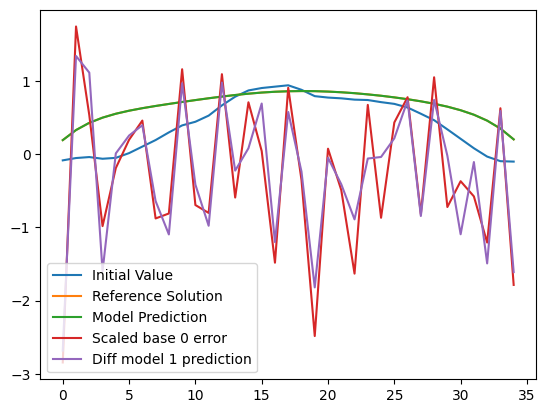

--------------------------------------RUN 2 --------------------------------------
Generated opt_params  2
0  :  2.803e-06
10  :  1.606e-06
20  :  1.362e-06
30  :  1.168e-06
40  :  1.004e-06
50  :  9.108e-07
60  :  9.789e-07
70  :  8.113e-07
80  :  7.522e-07
90  :  6.523e-07
100  :  6.501e-07
110  :  6.514e-07
120  :  5.998e-07
130  :  5.72e-07
140  :  5.535e-07
150  :  5.646e-07
160  :  5.165e-07
170  :  5.067e-07
180  :  4.87e-07
190  :  4.389e-07
200  :  4.727e-07
210  :  4.267e-07
220  :  4.354e-07
230  :  4.309e-07
240  :  4.067e-07
250  :  4.284e-07
260  :  3.863e-07
270  :  4.106e-07
280  :  3.699e-07
290  :  4.062e-07
300  :  3.599e-07
310  :  3.61e-07
320  :  3.571e-07
330  :  3.464e-07
340  :  3.315e-07
350  :  3.101e-07
360  :  3.202e-07
370  :  2.931e-07
380  :  2.977e-07
390  :  3.077e-07
400  :  3.033e-07
410  :  2.791e-07
420  :  2.876e-07
430  :  2.729e-07
440  :  2.618e-07
450  :  2.871e-07
460  :  2.635e-07
470  :  2.558e-07
480  :  2.607e-07
490  :  2.631e-07
500  : 

2210  :  0.3839
2220  :  0.3168
2230  :  0.3161
2240  :  0.4128
2250  :  0.3356
2260  :  0.3194
2270  :  0.3831
2280  :  0.3331
2290  :  0.3458
2300  :  0.3835
2310  :  0.3371
2320  :  0.3236
2330  :  0.3595
2340  :  0.3468
2350  :  0.3364
    New learning rate:  0.002
    New Batch size:  1024
2360  :  0.3182
2370  :  0.3066
2380  :  0.3012
2390  :  0.3029
2400  :  0.3023
2410  :  0.2996
2420  :  0.2946
2430  :  0.2953
2440  :  0.287
2450  :  0.2891
2460  :  0.2916
2470  :  0.2903
2480  :  0.2897
2490  :  0.286
2500  :  0.283
2510  :  0.2823
2520  :  0.282
2530  :  0.2913
2540  :  0.2811
2550  :  0.2924
2560  :  0.2842
2570  :  0.2868
2580  :  0.2804
2590  :  0.2789
2600  :  0.2896
2610  :  0.2833
2620  :  0.2848
2630  :  0.2792
2640  :  0.2728
2650  :  0.2802
2660  :  0.279
2670  :  0.2849
2680  :  0.2784
2690  :  0.2798
2700  :  0.2713
2710  :  0.28
2720  :  0.2757
2730  :  0.2704
2740  :  0.2835
2750  :  0.2696
2760  :  0.2753
2770  :  0.2759
2780  :  0.2779
2790  :  0.2728
2800  :

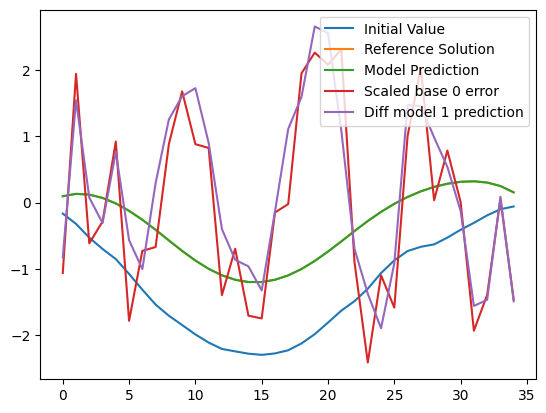

--------------------------------------RUN 3 --------------------------------------
Generated opt_params  3
0  :  2.733e-06
10  :  1.47e-06
20  :  1.466e-06
30  :  1.264e-06
40  :  1.084e-06
50  :  9.535e-07
60  :  9.062e-07
70  :  7.688e-07
80  :  7.587e-07
90  :  7.287e-07
100  :  7.02e-07
110  :  6.987e-07
120  :  6.008e-07
130  :  6.337e-07
140  :  6.142e-07
150  :  5.532e-07
160  :  5.325e-07
170  :  5.656e-07
180  :  4.932e-07
190  :  4.841e-07
200  :  5.118e-07
210  :  4.404e-07
220  :  4.098e-07
230  :  4.423e-07
240  :  4.057e-07
250  :  4.299e-07
260  :  4.417e-07
270  :  4.047e-07
280  :  4.209e-07
290  :  3.595e-07
300  :  3.61e-07
310  :  3.948e-07
320  :  3.532e-07
330  :  3.594e-07
340  :  3.251e-07
350  :  3.213e-07
360  :  3.517e-07
370  :  3.065e-07
380  :  2.8e-07
390  :  3.086e-07
400  :  3.099e-07
410  :  2.921e-07
420  :  2.869e-07
430  :  3.159e-07
440  :  2.318e-07
450  :  2.696e-07
460  :  2.765e-07
470  :  2.608e-07
480  :  2.33e-07
490  :  2.423e-07
500  :  2.

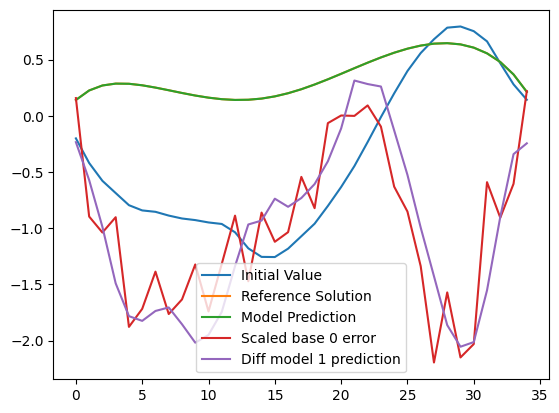

--------------------------------------RUN 4 --------------------------------------
Use opt_params  1  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00043825451963616283
0  :  1.162
10  :  1.004
20  :  0.9684
30  :  0.9607
40  :  0.9195
50  :  0.9026
60  :  0.8837
70  :  0.9077
80  :  0.9046
90  :  0.8931
100  :  0.8482
110  :  0.8778
120  :  0.8796
130  :  0.8451
140  :  0.8494
150  :  0.8154
160  :  0.8497
170  :  0.8182
180  :  0.8241
190  :  0.8371
200  :  0.8158
210  :  0.8146
220  :  0.7741
230  :  0.7881
240  :  0.7669
250  :  0.7874
260  :  0.7834
270  :  0.768
280  :  0.7521
290  :  0.7353
300  :  0.7398
310  :  0.7412
320  :  0.7219
330  :  0.7333
340  :  0.7231
350  :  0.706
360  :  0.7041
370  :  0.6843
380  :  0.6824
390  :  0.6864
400  :  0.7196
410  :  0.675
420  :  0.7033
430  :  0.6594
440  :  0.6671
450  :  0.6627
460  :  0.6633
470  :  0.6905
480  :  0.685
490  :  0.6727
500  :  0.6558
510  :  0.6579
520  :  0.6279
530  

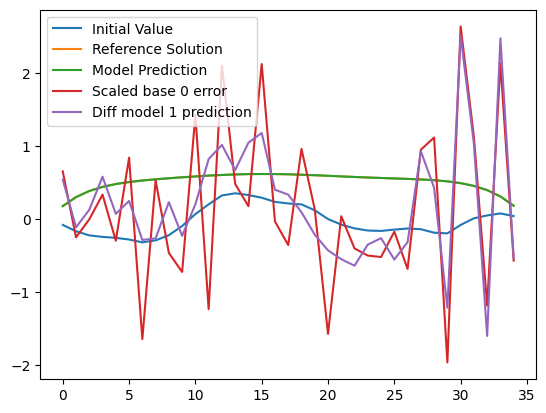

--------------------------------------RUN 5 --------------------------------------
Use opt_params  1  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.00043825451963616283
0  :  1.148
10  :  1.003
20  :  0.9317
30  :  0.9093
40  :  0.9569
50  :  0.9374
60  :  0.911
70  :  0.9018
80  :  0.9119
90  :  0.878
100  :  0.8862
110  :  0.8548
120  :  0.8466
130  :  0.888
140  :  0.8555
150  :  0.856
160  :  0.8482
170  :  0.8381
180  :  0.8282
190  :  0.8295
200  :  0.823
210  :  0.8097
220  :  0.8126
230  :  0.8155
240  :  0.8128
250  :  0.8037
260  :  0.8344
270  :  0.7769
280  :  0.7894
290  :  0.7987
300  :  0.7823
310  :  0.7818
320  :  0.7817
330  :  0.7825
340  :  0.7457
350  :  0.7576
360  :  0.7525
370  :  0.7724
380  :  0.74
390  :  0.7484
400  :  0.8007
410  :  0.7469
420  :  0.7672
430  :  0.7082
440  :  0.7109
450  :  0.735
460  :  0.7236
470  :  0.7128
480  :  0.7311
490  :  0.7085
500  :  0.7056
510  :  0.6965
520  :  0.7141
530  :  0

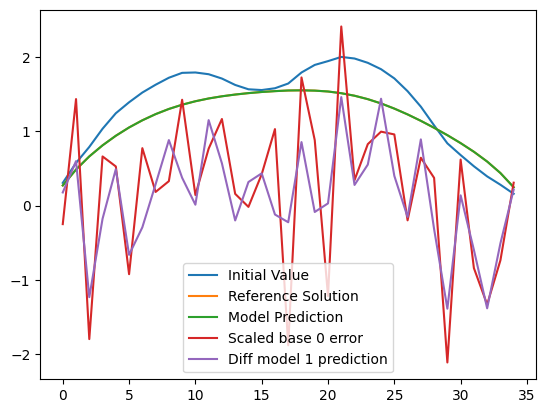

--------------------------------------RUN 6 --------------------------------------
Generated opt_params  4
0  :  5.355e-06
10  :  1.592e-06
20  :  1.202e-06
30  :  9.861e-07
40  :  8.305e-07
50  :  7.217e-07
60  :  6.344e-07
70  :  5.544e-07
80  :  5.055e-07
90  :  4.539e-07
100  :  4.392e-07
110  :  3.883e-07
120  :  3.656e-07
130  :  3.586e-07
140  :  3.492e-07
150  :  3.327e-07
160  :  3.332e-07
170  :  3.159e-07
180  :  2.981e-07
190  :  2.8e-07
200  :  2.766e-07
210  :  2.704e-07
220  :  2.786e-07
230  :  2.76e-07
240  :  2.662e-07
250  :  2.543e-07
260  :  2.692e-07
270  :  2.576e-07
280  :  2.383e-07
290  :  2.454e-07
300  :  2.535e-07
310  :  2.459e-07
320  :  2.442e-07
330  :  2.45e-07
340  :  2.364e-07
350  :  2.395e-07
360  :  2.314e-07
370  :  2.298e-07
380  :  2.3e-07
390  :  2.224e-07
400  :  2.391e-07
410  :  2.26e-07
420  :  2.249e-07
430  :  2.218e-07
440  :  2.119e-07
450  :  2.225e-07
460  :  2.219e-07
470  :  2.177e-07
480  :  2.189e-07
490  :  2.171e-07
500  :  2.1

2330  :  0.3976
2340  :  0.3976
2350  :  0.4014
2360  :  0.3992
2370  :  0.3972
2380  :  0.3918
2390  :  0.3903
2400  :  0.3921
2410  :  0.396
2420  :  0.3945
2430  :  0.3886
2440  :  0.4049
2450  :  0.3952
2460  :  0.3972
2470  :  0.3965
2480  :  0.3935
2490  :  0.3929
2500  :  0.3931
2510  :  0.3939
2520  :  0.3973
2530  :  0.3896
2540  :  0.3877
2550  :  0.3897
2560  :  0.3888
    New learning rate:  8e-05
2570  :  0.3938
2580  :  0.3969
2590  :  0.393
2600  :  0.3877
2610  :  0.3947
2620  :  0.3902
2630  :  0.3915
2640  :  0.3895
2650  :  0.3951
2660  :  0.3942
2670  :  0.386
2680  :  0.3858
2690  :  0.3907
2700  :  0.394
2710  :  0.3943
2720  :  0.3862
2730  :  0.3916
2740  :  0.3892
2750  :  0.3874
2760  :  0.381
2770  :  0.3957
    New learning rate:  1.6000000000000003e-05
2780  :  0.3808
2790  :  0.3941
2800  :  0.3828
2810  :  0.3895
2820  :  0.3823
2830  :  0.3883
2840  :  0.3911
2850  :  0.3887
2860  :  0.3919
2870  :  0.3962
2880  :  0.3877
2890  :  0.3886
2900  :  0.3886


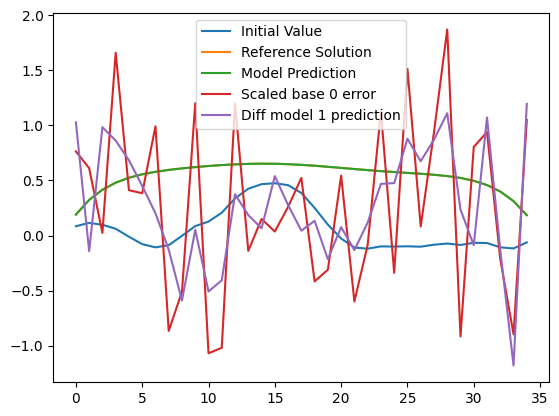

--------------------------------------RUN 7 --------------------------------------
Use opt_params  3  for the  2 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0003536742042747269
0  :  1.16
10  :  0.8562
20  :  0.8323
30  :  0.8573
40  :  0.7707
50  :  0.6949
60  :  0.7491
70  :  0.7045
80  :  0.6262
90  :  0.7267
100  :  0.618
110  :  0.5714
120  :  0.5818
130  :  0.5642
140  :  0.5591
150  :  0.47
160  :  0.4639
170  :  0.4347
180  :  0.3829
190  :  0.4445
200  :  0.3768
210  :  0.3949
220  :  0.3965
230  :  0.3039
240  :  0.2905
250  :  0.2672
260  :  0.2264
270  :  0.2423
280  :  0.2228
290  :  0.2364
300  :  0.2083
310  :  0.2052
320  :  0.1975
330  :  0.1642
340  :  0.1796
350  :  0.1656
360  :  0.1464
370  :  0.1425
380  :  0.1429
390  :  0.1543
400  :  0.1338
410  :  0.13
420  :  0.118
430  :  0.1324
440  :  0.128
450  :  0.1182
460  :  0.1079
470  :  0.1221
480  :  0.1228
490  :  0.1175
500  :  0.1284
510  :  0.1199
520  :  0.1158
530  :  0

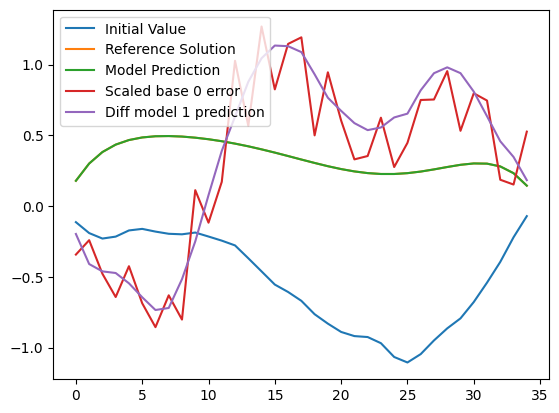

--------------------------------------RUN 8 --------------------------------------
Generated opt_params  5
0  :  4.375e-06
10  :  1.065e-06
20  :  1.092e-06
30  :  8.878e-07
40  :  7.936e-07
50  :  7.049e-07
60  :  6.471e-07
70  :  5.803e-07
80  :  5.64e-07
90  :  5.215e-07
100  :  4.715e-07
110  :  4.822e-07
120  :  4.771e-07
130  :  4.651e-07
140  :  4.36e-07
150  :  4.467e-07
160  :  4.253e-07
170  :  4.259e-07
180  :  4.193e-07
190  :  4.007e-07
200  :  4.159e-07
210  :  3.983e-07
220  :  4.028e-07
230  :  3.847e-07
240  :  3.772e-07
250  :  3.822e-07
260  :  3.739e-07
270  :  3.804e-07
280  :  3.888e-07
290  :  3.766e-07
300  :  3.501e-07
310  :  3.744e-07
320  :  3.601e-07
330  :  3.593e-07
340  :  3.678e-07
350  :  3.495e-07
360  :  3.474e-07
370  :  3.506e-07
380  :  3.424e-07
390  :  3.515e-07
400  :  3.318e-07
410  :  3.284e-07
420  :  3.501e-07
430  :  3.408e-07
440  :  3.369e-07
450  :  3.167e-07
460  :  3.181e-07
470  :  3.365e-07
480  :  3.259e-07
490  :  3.133e-07
500  :

2610  :  0.3777
2620  :  0.3645
2630  :  0.3632
2640  :  0.3913
2650  :  0.3981
2660  :  0.3773
2670  :  0.3704
2680  :  0.3796
2690  :  0.3483
2700  :  0.4733
2710  :  0.3678
2720  :  0.3552
2730  :  0.3605
2740  :  0.3645
2750  :  0.3593
2760  :  0.3746
2770  :  0.3682
2780  :  0.3619
2790  :  0.3732
2800  :  0.3906
2810  :  0.3639
2820  :  0.3557
2830  :  0.3519
2840  :  0.3649
2850  :  0.4031
2860  :  0.3613
2870  :  0.3554
2880  :  0.3615
2890  :  0.3964
2900  :  0.367
2910  :  0.3526
2920  :  0.3652
2930  :  0.3634
2940  :  0.3671
2950  :  0.3562
2960  :  0.359
2970  :  0.3583
2980  :  0.4003
2990  :  0.3312
3000  :  0.3447
3010  :  0.3406
3020  :  0.3519
3030  :  0.344
3040  :  0.3927
3050  :  0.335
3060  :  0.3381
3070  :  0.372
3080  :  0.3644
3090  :  0.341
3100  :  0.339
3110  :  0.3428
3120  :  0.3339
3130  :  0.3267
3140  :  0.3435
3150  :  0.3409
3160  :  0.3279
3170  :  0.3355
3180  :  0.3308
3190  :  0.3377
3200  :  0.3177
3210  :  0.3233
3220  :  0.329
3230  :  0.3309


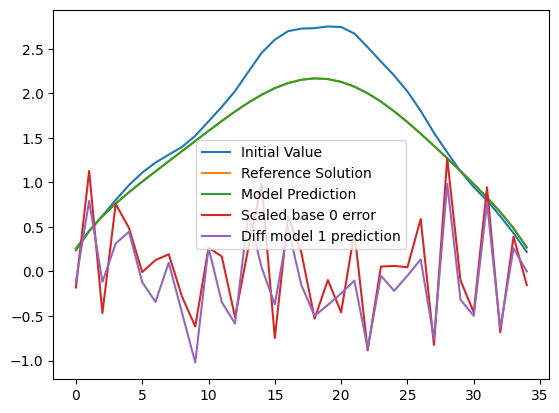

--------------------------------------RUN 9 --------------------------------------
Use opt_params  3  for the  3 th time
------ TRAINING BASE------
------ TRAINING DIFF 0 ------
Est. L2-error:  0.0003536742042747269
0  :  1.165
10  :  1.137
20  :  0.931
30  :  0.7747
40  :  0.907
50  :  0.8059
60  :  0.7025
70  :  0.7258
80  :  0.7369
90  :  0.6386
100  :  0.6225
110  :  0.5399
120  :  0.596
130  :  0.5666
140  :  0.5457
150  :  0.5268
160  :  0.4949
170  :  0.5121
180  :  0.5652
190  :  0.5242
200  :  0.4204
210  :  0.4147
220  :  0.3911
230  :  0.4335
240  :  0.4503
250  :  0.4114
260  :  0.4259
270  :  0.3155
280  :  0.3066
290  :  0.2978
300  :  0.306
310  :  0.3056
320  :  0.3014
330  :  0.2724
340  :  0.2882
350  :  0.2665
360  :  0.2346
370  :  0.2182
380  :  0.2272
390  :  0.2301
400  :  0.2106
410  :  0.2202
420  :  0.2206
430  :  0.1897
440  :  0.194
450  :  0.1857
460  :  0.1743
470  :  0.1819
480  :  0.1759
490  :  0.1621
500  :  0.1705
510  :  0.1378
520  :  0.1618
530  : 

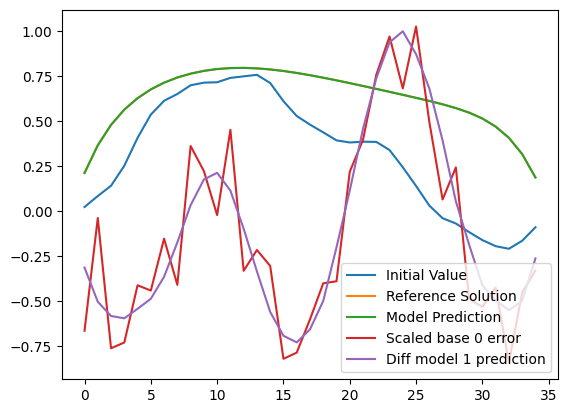

--------------------------------------RUN 10 --------------------------------------
Generated opt_params  6
0  :  5.711e-06
10  :  3.653e-06
20  :  2.896e-06
30  :  2.222e-06
40  :  1.991e-06
50  :  1.77e-06
60  :  1.604e-06
70  :  1.309e-06
80  :  1.193e-06
90  :  1.144e-06
100  :  1.084e-06
110  :  1.052e-06
120  :  9.801e-07
130  :  8.162e-07
140  :  8.861e-07
150  :  8.227e-07
160  :  8.069e-07
170  :  7.18e-07
180  :  6.953e-07
190  :  7.046e-07
200  :  6.726e-07
210  :  7.018e-07
220  :  5.82e-07
230  :  5.61e-07
240  :  6.037e-07
250  :  5.546e-07
260  :  5.457e-07
270  :  5.164e-07
280  :  4.71e-07
290  :  4.419e-07
300  :  4.405e-07
310  :  4.648e-07
320  :  4.669e-07
330  :  4.441e-07
340  :  4.748e-07
350  :  4.186e-07
360  :  4.339e-07
370  :  4.254e-07
380  :  4.034e-07
390  :  4.021e-07
400  :  4.096e-07
410  :  3.474e-07
420  :  3.86e-07
430  :  3.712e-07
440  :  3.638e-07
450  :  3.331e-07
460  :  3.935e-07
470  :  3.674e-07
480  :  3.538e-07
490  :  3.48e-07
500  :  3.

2540  :  0.04692
2550  :  0.04583
2560  :  0.04851
2570  :  0.04852
2580  :  0.04473
2590  :  0.04655
2600  :  0.04562
2610  :  0.04995
2620  :  0.04663
2630  :  0.04752
    New learning rate:  0.0004
    New Batch size:  2048
2640  :  0.04531
2650  :  0.04792
2660  :  0.04564
2670  :  0.04447
2680  :  0.04535
2690  :  0.04335
2700  :  0.04496
2710  :  0.04464
2720  :  0.04675
2730  :  0.04599
2740  :  0.04415
2750  :  0.04388
2760  :  0.04378
2770  :  0.04483
2780  :  0.04502
2790  :  0.04356
2800  :  0.04507
2810  :  0.04563
    New learning rate:  8e-05
2820  :  0.04403
2830  :  0.0465
2840  :  0.04813
2850  :  0.04598
2860  :  0.04302
2870  :  0.04471
2880  :  0.04308
2890  :  0.04544
2900  :  0.04651
2910  :  0.04384
2920  :  0.04586
2930  :  0.04589
2940  :  0.04315
Training ended due to inssuficient improvement


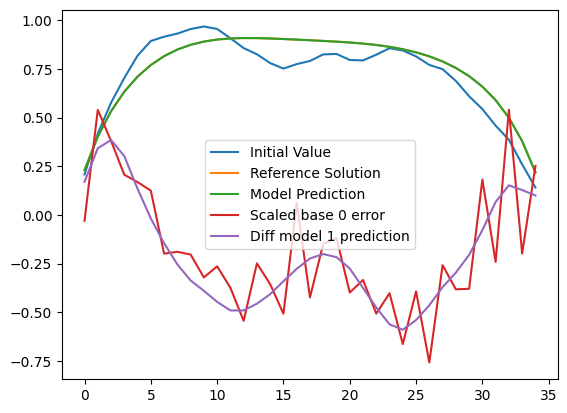

--------------------------------------RUN 11 --------------------------------------
Generated opt_params  7
0  :  7.719e-06
10  :  2.24e-06
20  :  1.436e-06
30  :  1.365e-06
40  :  1.063e-06
50  :  9.226e-07
60  :  8.156e-07
70  :  7.1e-07
80  :  6.396e-07
90  :  5.941e-07
100  :  5.208e-07
110  :  4.716e-07
120  :  4.492e-07
130  :  4.244e-07
140  :  3.911e-07
150  :  3.81e-07
160  :  3.679e-07
170  :  3.312e-07
180  :  3.504e-07
190  :  3.222e-07
200  :  2.999e-07
210  :  2.986e-07
220  :  2.884e-07
230  :  2.916e-07
240  :  2.832e-07
250  :  2.938e-07
260  :  2.728e-07
270  :  2.793e-07
280  :  2.697e-07
290  :  2.657e-07
300  :  2.571e-07
310  :  2.551e-07
320  :  2.538e-07
330  :  2.503e-07
340  :  2.472e-07
350  :  2.524e-07
360  :  2.415e-07
370  :  2.565e-07
380  :  2.477e-07
390  :  2.432e-07
400  :  2.384e-07
410  :  2.425e-07
420  :  2.415e-07
430  :  2.471e-07
440  :  2.397e-07
450  :  2.37e-07
460  :  2.285e-07
470  :  2.334e-07
480  :  2.314e-07
490  :  2.294e-07
500  :  

2670  :  0.4285
2680  :  0.4589
2690  :  0.4332
2700  :  0.4309
2710  :  0.4258
2720  :  0.4424
2730  :  0.4354
2740  :  0.4291
2750  :  0.4102
2760  :  0.4194
2770  :  0.4353
2780  :  0.4081
2790  :  0.4285
2800  :  0.4264
2810  :  0.411
2820  :  0.4176
2830  :  0.4153
2840  :  0.4178
2850  :  0.4034
2860  :  0.4269
2870  :  0.4093
2880  :  0.4074
2890  :  0.4542
2900  :  0.4341
2910  :  0.4178
2920  :  0.4094
2930  :  0.3952
2940  :  0.4332
2950  :  0.4032
2960  :  0.4118
2970  :  0.4394
2980  :  0.393
2990  :  0.3996
3000  :  0.4099
3010  :  0.4047
3020  :  0.411
3030  :  0.4276
3040  :  0.3867
3050  :  0.4362
3060  :  0.4113
3070  :  0.3897
3080  :  0.4135
3090  :  0.4062
3100  :  0.4014
3110  :  0.3799
3120  :  0.4632
3130  :  0.395
3140  :  0.395
3150  :  0.4075
3160  :  0.3935
3170  :  0.4007
3180  :  0.4153
3190  :  0.3995
3200  :  0.4058
3210  :  0.394
3220  :  0.4187
3230  :  0.3845
3240  :  0.393
3250  :  0.3747
3260  :  0.3777
3270  :  0.3925
3280  :  0.4203
3290  :  0.4437

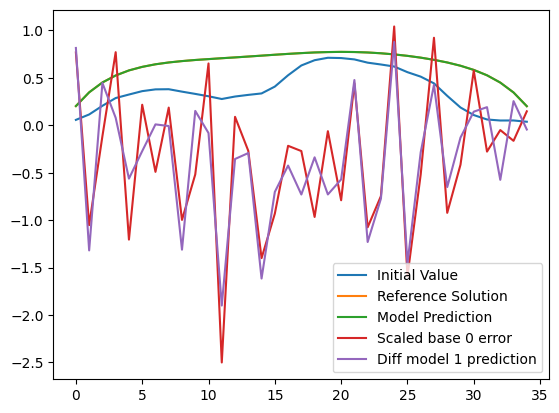

--------------------------------------RUN 12 --------------------------------------
Generated opt_params  8
0  :  2.744e-06
10  :  1.75e-06
20  :  1.61e-06
30  :  1.444e-06
40  :  1.289e-06
50  :  1.123e-06
60  :  9.766e-07
70  :  9.232e-07
80  :  8.846e-07
90  :  8.728e-07
100  :  7.071e-07
110  :  7.715e-07
120  :  7.25e-07
130  :  6.677e-07
140  :  7.042e-07
150  :  6.589e-07
160  :  5.715e-07
170  :  6.114e-07
180  :  5.475e-07
190  :  4.689e-07
200  :  5.442e-07
210  :  4.828e-07
220  :  4.468e-07
230  :  4.448e-07
240  :  4.945e-07
250  :  4.397e-07
260  :  4.227e-07
270  :  4.15e-07
280  :  3.943e-07
290  :  4.381e-07
300  :  3.795e-07
310  :  3.351e-07
320  :  3.505e-07
330  :  3.704e-07
340  :  3.592e-07
350  :  3.372e-07
360  :  3.158e-07
370  :  3.243e-07
380  :  3.029e-07
390  :  3.039e-07
400  :  2.995e-07
410  :  2.616e-07
420  :  2.986e-07
430  :  2.619e-07
440  :  2.845e-07
450  :  2.51e-07
460  :  2.558e-07
470  :  2.599e-07
480  :  2.746e-07
490  :  2.62e-07
500  :  2

2210  :  0.1344
2220  :  0.1351
2230  :  0.1313
2240  :  0.1341
2250  :  0.1315
2260  :  0.1299
2270  :  0.1303
2280  :  0.1318
2290  :  0.1321
2300  :  0.1309
Training ended due to inssuficient improvement


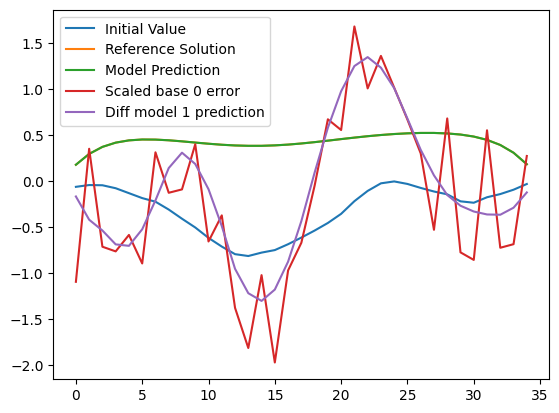

--------------------------------------RUN 13 --------------------------------------
Generated opt_params  9
0  :  3.727e-06
10  :  3.047e-06
20  :  2.18e-06
30  :  2.053e-06
40  :  1.725e-06
50  :  1.526e-06
60  :  1.408e-06
70  :  1.247e-06
80  :  1.216e-06
90  :  1.068e-06
100  :  1.106e-06
110  :  1.043e-06
120  :  1.006e-06
130  :  9.249e-07
140  :  9.69e-07
150  :  9.444e-07
160  :  9.045e-07
170  :  8.032e-07
180  :  8.001e-07
190  :  7.928e-07
200  :  7.689e-07
210  :  7.569e-07
220  :  7.71e-07
230  :  7.327e-07
240  :  6.473e-07
250  :  7.133e-07
260  :  6.732e-07
270  :  7.052e-07
280  :  6.375e-07
290  :  6.388e-07
300  :  6.256e-07
310  :  6.11e-07
320  :  5.77e-07
330  :  5.729e-07
340  :  6.019e-07
350  :  5.758e-07
360  :  5.741e-07
370  :  5.455e-07
380  :  5.476e-07
390  :  5.334e-07
400  :  5.355e-07
410  :  5.646e-07
420  :  5.268e-07
430  :  5.761e-07
440  :  5.03e-07
450  :  5.348e-07
460  :  5.291e-07
470  :  5.143e-07
480  :  4.794e-07
490  :  5.134e-07
500  :  5

2600  :  0.3259
2610  :  0.3212
2620  :  0.3304
2630  :  0.3171
2640  :  0.3103
2650  :  0.3181
2660  :  0.3412
2670  :  0.3326
2680  :  0.3155
2690  :  0.3204
2700  :  0.3217
    New learning rate:  0.0004
    New Batch size:  2048
2710  :  0.3084
2720  :  0.3007
2730  :  0.3119
2740  :  0.3097
2750  :  0.3036
2760  :  0.3079
2770  :  0.3106
2780  :  0.3013
2790  :  0.3045
2800  :  0.3048
2810  :  0.3033
2820  :  0.3023
2830  :  0.3099
2840  :  0.2986
2850  :  0.307
2860  :  0.3082
2870  :  0.301
    New learning rate:  8e-05
2880  :  0.3066
2890  :  0.3105
2900  :  0.3085
2910  :  0.3008
2920  :  0.306
2930  :  0.3075
2940  :  0.3104
2950  :  0.3012
2960  :  0.2996
2970  :  0.3036
2980  :  0.3053
2990  :  0.3033
3000  :  0.303
3010  :  0.3111
    New learning rate:  1.6000000000000003e-05
3020  :  0.3055
3030  :  0.31
3040  :  0.3077
3050  :  0.3153
3060  :  0.3003
3070  :  0.3004
3080  :  0.3053
3090  :  0.299
3100  :  0.3121
3110  :  0.3079
3120  :  0.3026
3130  :  0.3058
3140  :  

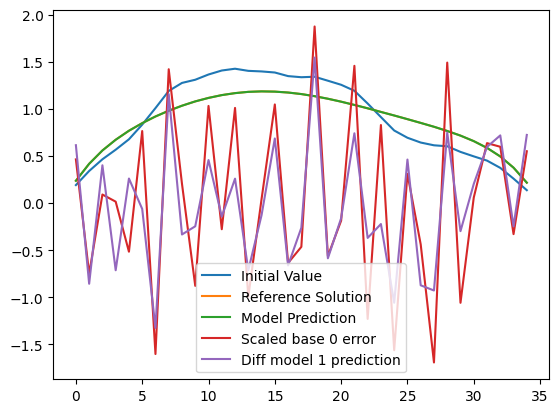

--------------------------------------RUN 14 --------------------------------------
Generated opt_params  10
0  :  6.949e-06
10  :  1.863e-06
20  :  1.263e-06
30  :  1.25e-06
40  :  9.436e-07
50  :  9.001e-07
60  :  8.024e-07
70  :  7.268e-07
80  :  6.447e-07
90  :  6.429e-07
100  :  5.753e-07
110  :  5.507e-07
120  :  5.475e-07
130  :  5.092e-07
140  :  4.898e-07
150  :  4.974e-07
160  :  4.548e-07
170  :  4.252e-07
180  :  4.191e-07
190  :  4.47e-07
200  :  4.41e-07
210  :  4.155e-07
220  :  3.775e-07
230  :  3.888e-07
240  :  3.872e-07
250  :  3.709e-07
260  :  3.574e-07
270  :  3.32e-07
280  :  3.503e-07
290  :  3.72e-07
300  :  3.645e-07
310  :  3.52e-07
320  :  3.413e-07
330  :  3.303e-07
340  :  3.53e-07
350  :  3.234e-07
360  :  2.944e-07
370  :  2.903e-07
380  :  3.077e-07
390  :  3.352e-07
400  :  2.851e-07
410  :  3.301e-07
420  :  2.995e-07
430  :  2.852e-07
440  :  2.859e-07
450  :  2.763e-07
460  :  2.857e-07
470  :  2.699e-07
480  :  2.683e-07
490  :  2.879e-07
500  :  2

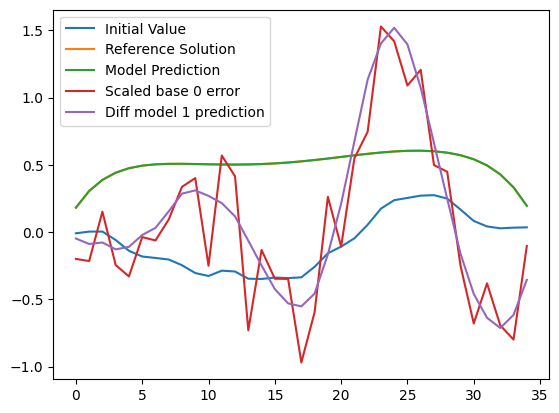

--------------------------------------RUN 15 --------------------------------------
Generated opt_params  11
0  :  3.874e-06
10  :  3.084e-06
20  :  2.33e-06
30  :  2.049e-06
40  :  1.65e-06
50  :  1.569e-06
60  :  1.342e-06
70  :  1.298e-06
80  :  1.371e-06
90  :  1.109e-06
100  :  9.648e-07
110  :  1.008e-06
120  :  8.778e-07
130  :  9.009e-07
140  :  7.934e-07
150  :  8.134e-07
160  :  7.508e-07
170  :  6.623e-07
180  :  7.408e-07
190  :  7.039e-07
200  :  6.207e-07
210  :  6.357e-07
220  :  5.868e-07
230  :  6.02e-07
240  :  5.304e-07
250  :  5.552e-07
260  :  4.933e-07
270  :  4.362e-07
280  :  5.503e-07
290  :  4.31e-07
300  :  4.851e-07
310  :  4.456e-07
320  :  4.225e-07
330  :  4.28e-07
340  :  4.513e-07
350  :  4.309e-07
360  :  3.497e-07
370  :  4.032e-07
380  :  3.95e-07
390  :  3.604e-07
400  :  3.456e-07
410  :  3.455e-07
420  :  3.476e-07
430  :  3.55e-07
440  :  3.72e-07
450  :  3.606e-07
460  :  3.168e-07
470  :  3.047e-07
480  :  3.131e-07
490  :  3.573e-07
500  :  3.

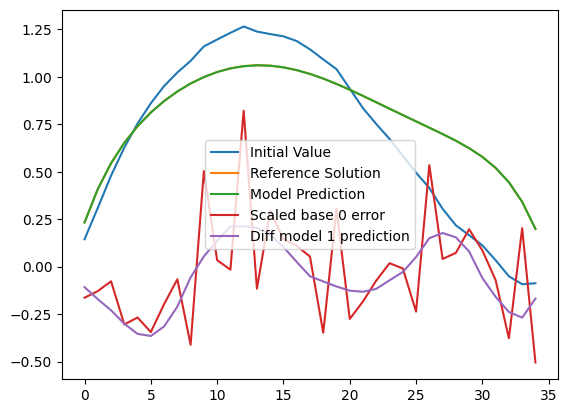

--------------------------------------RUN 16 --------------------------------------
Generated opt_params  12
0  :  3.261e-06
10  :  2.355e-06
20  :  1.927e-06
30  :  1.729e-06
40  :  1.598e-06
50  :  1.346e-06
60  :  1.245e-06
70  :  1.048e-06
80  :  1.114e-06
90  :  9.952e-07
100  :  8.56e-07
110  :  8.328e-07
120  :  8.221e-07
130  :  7.179e-07
140  :  8.309e-07
150  :  7.616e-07
160  :  6.382e-07
170  :  7.415e-07
180  :  6.163e-07
190  :  5.826e-07
200  :  5.786e-07
210  :  5.789e-07
220  :  5.354e-07
230  :  5.357e-07
240  :  5.251e-07
250  :  5.309e-07
260  :  4.479e-07
270  :  4.988e-07
280  :  4.387e-07
290  :  4.024e-07
300  :  4.048e-07
310  :  4.652e-07
320  :  4.314e-07
330  :  3.528e-07
340  :  3.859e-07
350  :  3.8e-07
360  :  3.387e-07
370  :  3.423e-07
380  :  3.457e-07
390  :  3.234e-07
400  :  3.345e-07
410  :  3.169e-07
420  :  3.113e-07
430  :  3.284e-07
440  :  2.886e-07
450  :  3.165e-07
460  :  2.986e-07
470  :  2.949e-07
480  :  3.03e-07
490  :  3.164e-07
500  :

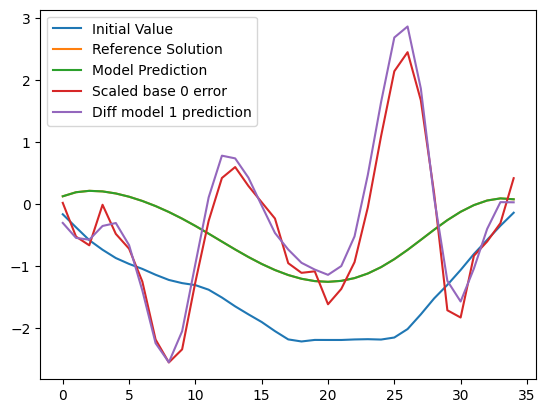

--------------------------------------RUN 17 --------------------------------------
Generated opt_params  13
0  :  3.265e-06
10  :  2.46e-06
20  :  1.833e-06
30  :  1.67e-06
40  :  1.376e-06
50  :  1.285e-06
60  :  1.147e-06
70  :  1.088e-06
80  :  1.037e-06
90  :  9.569e-07
100  :  9.378e-07
110  :  8.381e-07
120  :  8.238e-07
130  :  8.075e-07
140  :  7.875e-07
150  :  7.779e-07
160  :  7.454e-07
170  :  6.899e-07
180  :  6.502e-07
190  :  6.686e-07
200  :  6.489e-07
210  :  6.079e-07
220  :  6.112e-07
230  :  5.801e-07
240  :  5.78e-07
250  :  6.2e-07
260  :  5.532e-07
270  :  5.357e-07
280  :  5.324e-07
290  :  5.233e-07
300  :  5.166e-07
310  :  4.909e-07
320  :  4.946e-07
330  :  5.02e-07
340  :  4.722e-07
350  :  4.603e-07
360  :  4.659e-07
370  :  4.547e-07
380  :  4.914e-07
390  :  4.658e-07
400  :  4.349e-07
410  :  4.701e-07
420  :  4.252e-07
430  :  4.505e-07
440  :  4.181e-07
450  :  4.298e-07
460  :  4.074e-07
470  :  4.276e-07
480  :  4.071e-07
490  :  4.413e-07
500  :  

2750  :  0.3984
2760  :  0.3971
2770  :  0.4048
2780  :  0.3969
2790  :  0.3992
2800  :  0.3971
2810  :  0.4013
2820  :  0.4009
2830  :  0.4006
2840  :  0.398
2850  :  0.4009
2860  :  0.3956
2870  :  0.394
2880  :  0.3974
2890  :  0.394
    New learning rate:  8e-05
2900  :  0.3958
2910  :  0.3962
2920  :  0.3909
2930  :  0.402
2940  :  0.3977
2950  :  0.3966
2960  :  0.3942
2970  :  0.3988
2980  :  0.3957
2990  :  0.4035
3000  :  0.3905
3010  :  0.3947
Training ended due to inssuficient improvement


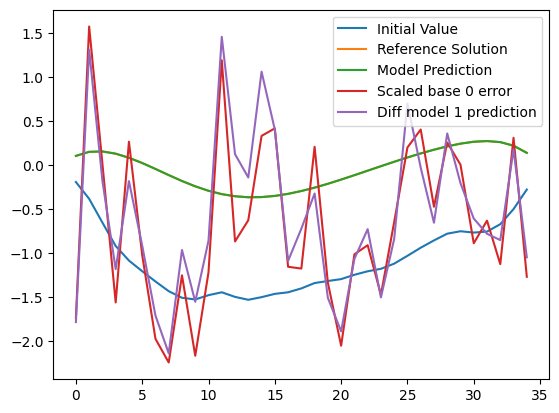

--------------------------------------RUN 18 --------------------------------------
Generated opt_params  14
0  :  2.678e-06
10  :  1.934e-06
20  :  1.82e-06
30  :  1.314e-06
40  :  1.289e-06
50  :  1.092e-06
60  :  1.039e-06
70  :  9.362e-07
80  :  9.261e-07
90  :  8.879e-07
100  :  8.479e-07
110  :  8.197e-07
120  :  7.644e-07
130  :  7.233e-07
140  :  7.718e-07
150  :  6.469e-07
160  :  6.613e-07
170  :  6.446e-07
180  :  5.897e-07
190  :  5.839e-07
200  :  5.995e-07
210  :  5.093e-07
220  :  5.71e-07
230  :  5.459e-07
240  :  5.091e-07
250  :  4.673e-07
260  :  5.042e-07
270  :  4.625e-07
280  :  4.701e-07
290  :  4.411e-07
300  :  4.725e-07
310  :  4.148e-07
320  :  4.389e-07
330  :  4.174e-07
340  :  4.139e-07
350  :  4.228e-07
360  :  4.068e-07
370  :  4.243e-07
380  :  3.894e-07
390  :  4.007e-07
400  :  3.612e-07
410  :  3.845e-07
420  :  3.628e-07
430  :  3.638e-07
440  :  3.539e-07
450  :  3.442e-07
460  :  3.592e-07
470  :  3.398e-07
480  :  3.434e-07
490  :  3.524e-07
500 

2730  :  0.4462
2740  :  0.4487
2750  :  0.4503
2760  :  0.4403
2770  :  0.4502
2780  :  0.451
2790  :  0.4426
2800  :  0.4488
2810  :  0.4464
2820  :  0.4426
2830  :  0.4403
2840  :  0.4481
2850  :  0.4462
2860  :  0.4484
2870  :  0.4495
2880  :  0.4474
2890  :  0.4421
2900  :  0.4475
2910  :  0.4471
2920  :  0.4313
2930  :  0.4427
2940  :  0.4388
2950  :  0.4449
2960  :  0.4377
2970  :  0.4418
2980  :  0.4476
2990  :  0.4392
3000  :  0.4429
3010  :  0.4459
3020  :  0.4347
3030  :  0.4387
3040  :  0.443
    New learning rate:  8e-05
3050  :  0.4451
3060  :  0.438
3070  :  0.4347
3080  :  0.4408
3090  :  0.4418
3100  :  0.4426
3110  :  0.442
3120  :  0.4361
3130  :  0.4418
3140  :  0.4461
3150  :  0.4462
3160  :  0.4426
3170  :  0.437
3180  :  0.4387
3190  :  0.4349
3200  :  0.4331
3210  :  0.4461
3220  :  0.4341
3230  :  0.4387
3240  :  0.4396
3250  :  0.438
    New learning rate:  1.6000000000000003e-05
3260  :  0.4423
3270  :  0.4387
3280  :  0.4391
3290  :  0.4467
3300  :  0.4402
3

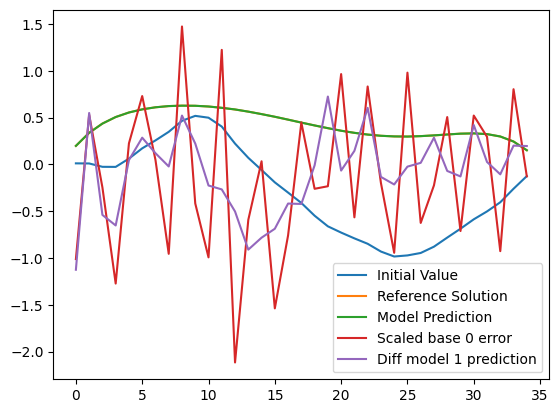

--------------------------------------RUN 19 --------------------------------------
Generated opt_params  15
0  :  4.987e-06
10  :  1.241e-06
20  :  1.101e-06
30  :  8.952e-07
40  :  7.665e-07
50  :  6.927e-07
60  :  6.395e-07
70  :  5.947e-07
80  :  5.74e-07
90  :  5.526e-07
100  :  4.803e-07
110  :  4.6e-07
120  :  4.498e-07
130  :  4.516e-07
140  :  4.258e-07
150  :  4.26e-07
160  :  4.068e-07
170  :  4.013e-07
180  :  4.001e-07
190  :  3.843e-07
200  :  3.784e-07
210  :  3.773e-07
220  :  4.011e-07
230  :  3.653e-07
240  :  3.777e-07
250  :  3.66e-07
260  :  3.561e-07
270  :  3.627e-07
280  :  3.66e-07
290  :  3.615e-07
300  :  3.447e-07
310  :  3.4e-07
320  :  3.403e-07
330  :  3.494e-07
340  :  3.362e-07
350  :  3.265e-07
360  :  3.442e-07
370  :  3.29e-07
380  :  3.289e-07
390  :  3.166e-07
400  :  3.424e-07
410  :  3.297e-07
420  :  3.273e-07
430  :  3.239e-07
440  :  3.231e-07
450  :  3.275e-07
460  :  3.143e-07
470  :  3.129e-07
480  :  3.151e-07
490  :  3.073e-07
500  :  3.2

2670  :  0.3773
2680  :  0.3574
2690  :  0.3769
2700  :  0.352
2710  :  0.3749
2720  :  0.4081
2730  :  0.3904
2740  :  0.3608
2750  :  0.363
    New learning rate:  0.0004
    New Batch size:  2048
2760  :  0.3524
2770  :  0.3539
2780  :  0.3426
2790  :  0.3471
2800  :  0.341
2810  :  0.3424
2820  :  0.3467
2830  :  0.3489
2840  :  0.3476
2850  :  0.3467
2860  :  0.3464
2870  :  0.344
2880  :  0.3417
2890  :  0.3423
2900  :  0.341
2910  :  0.35
    New learning rate:  8e-05
2920  :  0.3403
2930  :  0.3451
2940  :  0.331
2950  :  0.3423
2960  :  0.3528
2970  :  0.3372
2980  :  0.3425
2990  :  0.3517
3000  :  0.3386
3010  :  0.3412
3020  :  0.3482
3030  :  0.3364
3040  :  0.3314
3050  :  0.3435
    New learning rate:  1.6000000000000003e-05
3060  :  0.3477
3070  :  0.3429
3080  :  0.3401
3090  :  0.3469
3100  :  0.3382
3110  :  0.3431
3120  :  0.3428
3130  :  0.3382
3140  :  0.3357
3150  :  0.338
3160  :  0.3447
3170  :  0.3406
3180  :  0.3438
Training ended due to inssuficient improvem

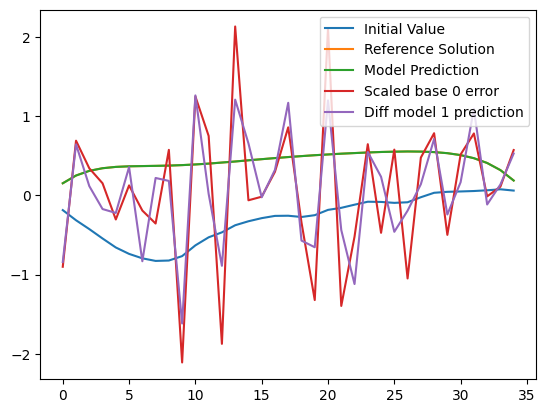

--------------------------------------RUN 20 --------------------------------------
Generated opt_params  16
0  :  9.801e-06
10  :  3.243e-06
20  :  2.079e-06
30  :  1.932e-06
40  :  1.664e-06
50  :  1.466e-06
60  :  1.261e-06
70  :  1.132e-06
80  :  9.707e-07
90  :  9.46e-07
100  :  8.687e-07
110  :  7.666e-07
120  :  7.478e-07
130  :  6.569e-07
140  :  6.511e-07
150  :  6.267e-07
160  :  6.146e-07
170  :  5.578e-07
180  :  5.431e-07
190  :  5.59e-07
200  :  5.317e-07
210  :  5.027e-07
220  :  5.122e-07
230  :  5.091e-07
240  :  4.563e-07
250  :  4.642e-07
260  :  4.365e-07
270  :  4.519e-07
280  :  4.562e-07
290  :  4.36e-07
300  :  4.467e-07
310  :  4.13e-07
320  :  4.348e-07
330  :  4.31e-07
340  :  4.039e-07
350  :  4.24e-07
360  :  4.319e-07
370  :  4.007e-07
380  :  3.986e-07
390  :  3.768e-07
400  :  3.864e-07
410  :  4.158e-07
420  :  3.837e-07
430  :  3.86e-07
440  :  3.906e-07
450  :  3.828e-07
460  :  3.824e-07
470  :  3.752e-07
480  :  3.571e-07
490  :  3.627e-07
500  :  3

2340  :  0.3564
2350  :  0.3504
2360  :  0.3688
2370  :  0.3458
2380  :  0.3563
2390  :  0.5644
2400  :  0.3801
2410  :  0.3533
2420  :  0.354
2430  :  0.3437
2440  :  0.3429
2450  :  0.346
2460  :  0.3365
2470  :  0.3422
2480  :  0.3366
2490  :  0.3431
2500  :  0.3398
2510  :  0.3321
2520  :  0.3403
2530  :  0.3493
2540  :  0.343
2550  :  0.3251
2560  :  0.3564
2570  :  0.3382
2580  :  0.3304
2590  :  0.3382
2600  :  0.3561
2610  :  0.3186
2620  :  0.3278
2630  :  0.3647
2640  :  0.3289
2650  :  0.3284
2660  :  0.3253
2670  :  0.3814
2680  :  0.3311
2690  :  0.3339
2700  :  0.3091
2710  :  0.3179
2720  :  0.4311
2730  :  0.3269
2740  :  0.3208
2750  :  0.3146
2760  :  0.3124
2770  :  0.3286
2780  :  0.3208
2790  :  0.3344
2800  :  0.3617
2810  :  0.302
2820  :  0.313
2830  :  0.3019
2840  :  0.3307
2850  :  0.3114
2860  :  0.3172
2870  :  0.4131
2880  :  0.3482
2890  :  0.3093
2900  :  0.3066
2910  :  0.2974
2920  :  0.3121
2930  :  0.3179
2940  :  0.3068
2950  :  0.2891
2960  :  0.29

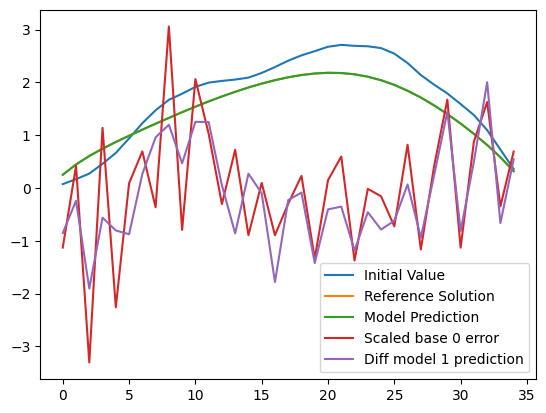

--------------------------------------RUN 21 --------------------------------------
Generated opt_params  17
0  :  3.347e-06
10  :  9.978e-07
20  :  9.935e-07
30  :  8.683e-07
40  :  7.566e-07
50  :  6.794e-07
60  :  6.361e-07
70  :  6.094e-07
80  :  5.462e-07
90  :  5.713e-07
100  :  5.241e-07
110  :  5.086e-07
120  :  4.791e-07
130  :  4.58e-07
140  :  4.586e-07
150  :  4.271e-07
160  :  4.419e-07
170  :  4.034e-07
180  :  4.288e-07
190  :  3.948e-07
200  :  3.677e-07
210  :  3.833e-07
220  :  3.904e-07
230  :  3.443e-07
240  :  3.624e-07
250  :  3.487e-07
260  :  3.516e-07
270  :  3.148e-07
280  :  3.215e-07
290  :  3.486e-07
300  :  2.994e-07
310  :  3.065e-07
320  :  2.995e-07
330  :  2.975e-07
340  :  2.851e-07
350  :  2.911e-07
360  :  2.55e-07
370  :  2.825e-07
380  :  2.755e-07
390  :  2.631e-07
400  :  2.504e-07
410  :  2.58e-07
420  :  2.557e-07
430  :  2.488e-07
440  :  2.308e-07
450  :  2.396e-07
460  :  2.278e-07
470  :  2.428e-07
480  :  2.177e-07
490  :  2.238e-07
500  

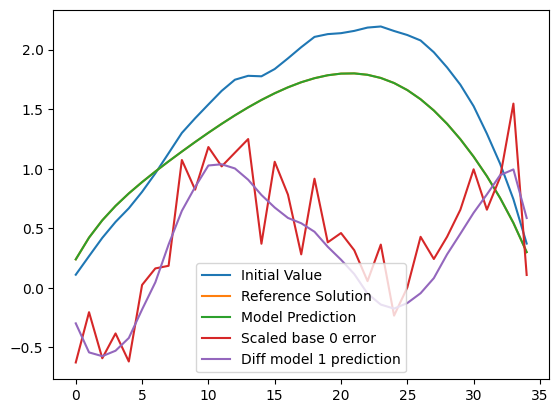

--------------------------------------RUN 22 --------------------------------------
Generated opt_params  18
0  :  4.296e-06
10  :  3.196e-06
20  :  2.598e-06
30  :  2.019e-06
40  :  1.806e-06
50  :  1.529e-06
60  :  1.585e-06
70  :  1.466e-06
80  :  1.422e-06
90  :  1.266e-06
100  :  1.09e-06
110  :  1.071e-06
120  :  1.104e-06
130  :  1.034e-06
140  :  9.31e-07
150  :  8.987e-07
160  :  8.798e-07
170  :  8.597e-07
180  :  8.989e-07
190  :  8.126e-07
200  :  8.211e-07
210  :  7.925e-07
220  :  7.227e-07
230  :  7.561e-07
240  :  7.656e-07
250  :  7.255e-07
260  :  6.836e-07
270  :  6.986e-07
280  :  6.753e-07
290  :  6.479e-07
300  :  6.383e-07
310  :  6.469e-07
320  :  6.279e-07
330  :  6.527e-07
340  :  5.975e-07
350  :  6.194e-07
360  :  5.879e-07
370  :  5.908e-07
380  :  5.432e-07
390  :  5.483e-07
400  :  5.729e-07
410  :  5.719e-07
420  :  5.512e-07
430  :  5.137e-07
440  :  5.3e-07
450  :  5.432e-07
460  :  5.324e-07
470  :  5.425e-07
480  :  5.285e-07
490  :  4.93e-07
500  : 

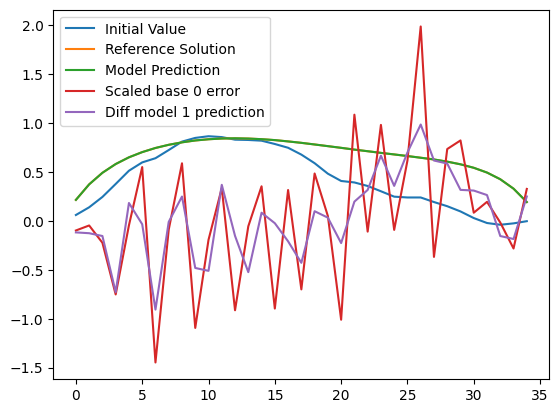

--------------------------------------RUN 23 --------------------------------------
Generated opt_params  19
0  :  3.96e-06
10  :  2.829e-06
20  :  2.356e-06
30  :  2.099e-06
40  :  1.671e-06
50  :  1.514e-06
60  :  1.265e-06
70  :  1.188e-06
80  :  1.235e-06
90  :  1.09e-06
100  :  1.079e-06
110  :  9.646e-07
120  :  8.827e-07
130  :  8.415e-07
140  :  9.292e-07
150  :  8.78e-07
160  :  7.844e-07
170  :  7.707e-07
180  :  6.778e-07
190  :  6.687e-07
200  :  7.246e-07
210  :  6.81e-07
220  :  5.893e-07
230  :  6.056e-07
240  :  6.554e-07
250  :  5.433e-07
260  :  5.432e-07
270  :  6.017e-07
280  :  5.592e-07
290  :  5.185e-07
300  :  4.91e-07
310  :  5.162e-07
320  :  5.096e-07
330  :  4.825e-07
340  :  5.146e-07
350  :  4.457e-07
360  :  4.664e-07
370  :  4.347e-07
380  :  4.277e-07
390  :  3.826e-07
400  :  3.968e-07
410  :  3.973e-07
420  :  4.007e-07
430  :  4.279e-07
440  :  4.154e-07
450  :  3.992e-07
460  :  3.747e-07
470  :  3.794e-07
480  :  3.713e-07
490  :  3.358e-07
500  : 

1210  :  0.4532
1220  :  0.4671
1230  :  0.4589
1240  :  0.4541
1250  :  0.4482
1260  :  0.4506
1270  :  0.4557
1280  :  0.4613
1290  :  0.4659
1300  :  0.4586
1310  :  0.464
1320  :  0.455
1330  :  0.4527
1340  :  0.459
1350  :  0.4592
1360  :  0.4413
1370  :  0.458
1380  :  0.4448
    New learning rate:  0.0004
    New Batch size:  2048
1390  :  0.4441
1400  :  0.4478
1410  :  0.4466
1420  :  0.4405
1430  :  0.439
1440  :  0.445
1450  :  0.4417
1460  :  0.4424
1470  :  0.4436
1480  :  0.4348
1490  :  0.4434
1500  :  0.4361
1510  :  0.4338
1520  :  0.4333
1530  :  0.4374
1540  :  0.444
1550  :  0.4494
    New learning rate:  8e-05
1560  :  0.4445
1570  :  0.4389
1580  :  0.4415
1590  :  0.441
1600  :  0.4428
1610  :  0.4368
1620  :  0.4449
1630  :  0.4444
1640  :  0.438
1650  :  0.4354
1660  :  0.437
1670  :  0.4379
1680  :  0.4369
1690  :  0.4415
1700  :  0.4365
1710  :  0.439
1720  :  0.4452
1730  :  0.4387
1740  :  0.4412
1750  :  0.4369
1760  :  0.4379
1770  :  0.4355
1780  :  0.4

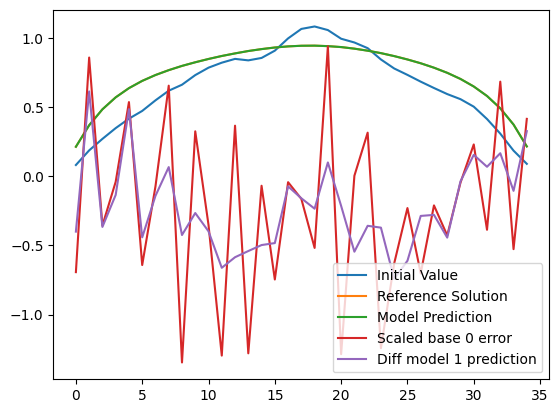

--------------------------------------RUN 24 --------------------------------------
Generated opt_params  20
0  :  2.456e-06
10  :  1.385e-06
20  :  1.259e-06
30  :  1.034e-06
40  :  9.705e-07
50  :  8.441e-07
60  :  7.928e-07
70  :  7.916e-07
80  :  7.04e-07
90  :  6.483e-07
100  :  6.144e-07
110  :  5.825e-07
120  :  6.022e-07
130  :  5.696e-07
140  :  5.435e-07
150  :  5.719e-07
160  :  5.164e-07
170  :  4.572e-07
180  :  4.99e-07
190  :  4.551e-07
200  :  4.437e-07
210  :  4.056e-07
220  :  4.048e-07
230  :  4.668e-07
240  :  3.654e-07
250  :  3.659e-07
260  :  3.723e-07
270  :  3.813e-07
280  :  3.531e-07
290  :  3.221e-07
300  :  3.835e-07
310  :  3.266e-07
320  :  3.144e-07
330  :  3.122e-07
340  :  3.283e-07
350  :  2.945e-07
360  :  3.029e-07
370  :  3.068e-07
380  :  2.675e-07
390  :  2.457e-07
400  :  2.706e-07
410  :  3.017e-07
420  :  2.871e-07
430  :  2.727e-07
440  :  2.666e-07
450  :  2.477e-07
460  :  2.463e-07
470  :  2.543e-07
480  :  2.342e-07
490  :  2.291e-07
500 

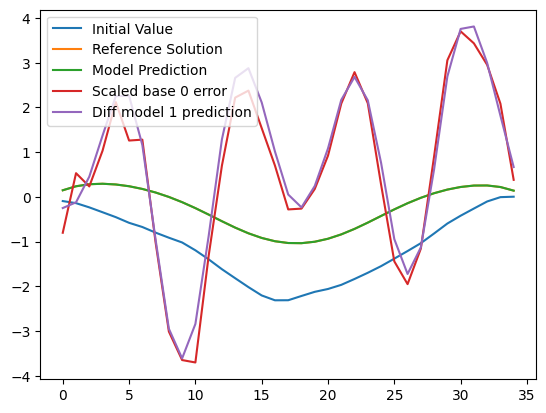

--------------------------------------RUN 25 --------------------------------------
Generated opt_params  21
0  :  3.327e-06
10  :  2.53e-06
20  :  2.059e-06
30  :  1.782e-06
40  :  1.496e-06
50  :  1.267e-06
60  :  1.234e-06
70  :  1.148e-06
80  :  1.157e-06
90  :  1.01e-06
100  :  9.19e-07
110  :  8.619e-07
120  :  8.716e-07
130  :  8.322e-07
140  :  7.704e-07
150  :  7.646e-07
160  :  7.623e-07
170  :  7.227e-07
180  :  7.1e-07
190  :  6.874e-07
200  :  6.489e-07
210  :  6.437e-07
220  :  5.972e-07
230  :  5.873e-07
240  :  5.714e-07
250  :  5.74e-07
260  :  5.605e-07
270  :  4.966e-07
280  :  5.149e-07
290  :  5.245e-07
300  :  4.645e-07
310  :  4.721e-07
320  :  4.765e-07
330  :  4.845e-07
340  :  4.389e-07
350  :  4.815e-07
360  :  4.186e-07
370  :  4.238e-07
380  :  4.396e-07
390  :  4.219e-07
400  :  3.983e-07
410  :  4.209e-07
420  :  4.11e-07
430  :  3.875e-07
440  :  3.862e-07
450  :  3.923e-07
460  :  3.633e-07
470  :  3.809e-07
480  :  3.819e-07
490  :  3.779e-07
500  :  3

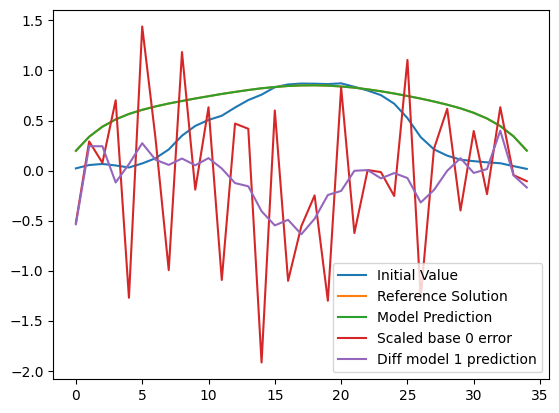

--------------------------------------RUN 26 --------------------------------------
Generated opt_params  22
0  :  3.481e-06
10  :  1.247e-06
20  :  1.119e-06
30  :  1.012e-06
40  :  8.144e-07
50  :  9e-07
60  :  7.881e-07
70  :  7.017e-07
80  :  6.082e-07
90  :  5.878e-07
100  :  5.813e-07
110  :  5.554e-07
120  :  5.513e-07
130  :  5.681e-07
140  :  5.307e-07
150  :  5.156e-07
160  :  5.572e-07
170  :  5.399e-07
180  :  4.909e-07
190  :  4.623e-07
200  :  4.374e-07
210  :  4.324e-07
220  :  4.119e-07
230  :  4.059e-07
240  :  3.873e-07
250  :  4.144e-07
260  :  3.734e-07
270  :  3.582e-07
280  :  3.976e-07
290  :  3.854e-07
300  :  3.766e-07
310  :  4.001e-07
320  :  3.272e-07
330  :  3.736e-07
340  :  3.393e-07
350  :  3.471e-07
360  :  3.055e-07
370  :  2.9e-07
380  :  3.029e-07
390  :  3.049e-07
400  :  2.983e-07
410  :  3.206e-07
420  :  2.883e-07
430  :  2.765e-07
440  :  2.887e-07
450  :  2.662e-07
460  :  2.831e-07
470  :  2.913e-07
480  :  2.58e-07
490  :  2.831e-07
500  :  2

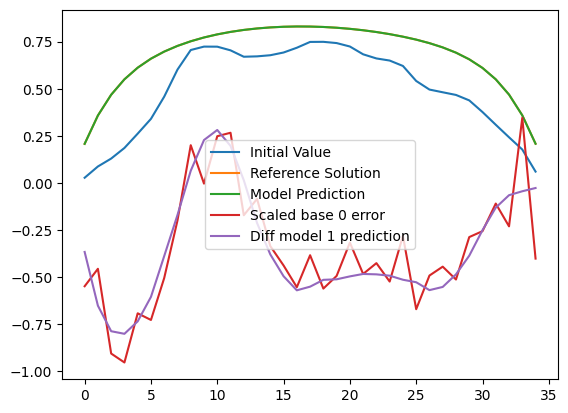

--------------------------------------RUN 27 --------------------------------------
Generated opt_params  23
0  :  1.004e-05
10  :  3.601e-06
20  :  2.024e-06
30  :  1.837e-06
40  :  1.602e-06
50  :  1.379e-06
60  :  1.235e-06
70  :  1.06e-06
80  :  8.442e-07
90  :  7.859e-07
100  :  7.617e-07
110  :  6.529e-07
120  :  6.212e-07
130  :  5.262e-07
140  :  4.868e-07
150  :  4.561e-07
160  :  4.309e-07
170  :  4.112e-07
180  :  4.002e-07
190  :  3.114e-07
200  :  3.351e-07
210  :  3.107e-07
220  :  3.093e-07
230  :  2.939e-07
240  :  2.781e-07
250  :  2.815e-07
260  :  2.595e-07
270  :  2.639e-07
280  :  2.421e-07
290  :  2.408e-07
300  :  2.344e-07
310  :  2.377e-07
320  :  2.117e-07
330  :  2.201e-07
340  :  1.974e-07
350  :  2.054e-07
360  :  2.044e-07
370  :  2.035e-07
380  :  1.888e-07
390  :  1.939e-07
400  :  1.742e-07
410  :  1.8e-07
420  :  1.882e-07
430  :  1.719e-07
440  :  1.689e-07
450  :  1.639e-07
460  :  1.614e-07
470  :  1.68e-07
480  :  1.615e-07
490  :  1.653e-07
500  :

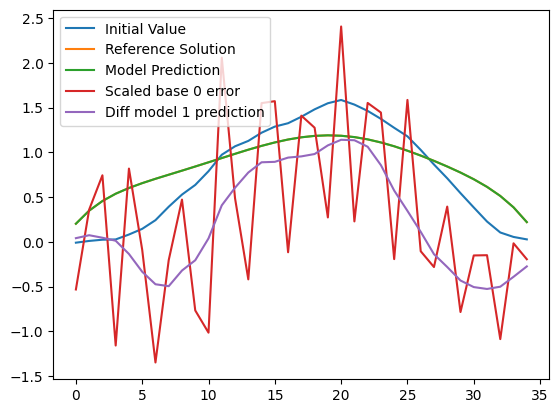

--------------------------------------RUN 28 --------------------------------------
Generated opt_params  24
0  :  4.423e-06
10  :  3.62e-06
20  :  2.646e-06
30  :  2.127e-06
40  :  1.873e-06
50  :  1.65e-06
60  :  1.359e-06
70  :  1.193e-06
80  :  1.279e-06
90  :  1.2e-06
100  :  1.1e-06
110  :  1.035e-06
120  :  9.634e-07
130  :  9.478e-07
140  :  9.091e-07
150  :  8.359e-07
160  :  7.432e-07
170  :  7.729e-07
180  :  6.832e-07
190  :  7.271e-07
200  :  7.081e-07
210  :  6.426e-07
220  :  6.36e-07
230  :  6.312e-07
240  :  6.472e-07
250  :  5.677e-07
260  :  5.569e-07
270  :  5.372e-07
280  :  5.394e-07
290  :  5.317e-07
300  :  4.66e-07
310  :  5.091e-07
320  :  4.474e-07
330  :  4.746e-07
340  :  4.537e-07
350  :  4.835e-07
360  :  4.622e-07
370  :  4.53e-07
380  :  4.241e-07
390  :  4.719e-07
400  :  4.198e-07
410  :  4.395e-07
420  :  4.21e-07
430  :  4.063e-07
440  :  3.952e-07
450  :  3.647e-07
460  :  4.121e-07
470  :  3.615e-07
480  :  3.817e-07
490  :  3.672e-07
500  :  3.59

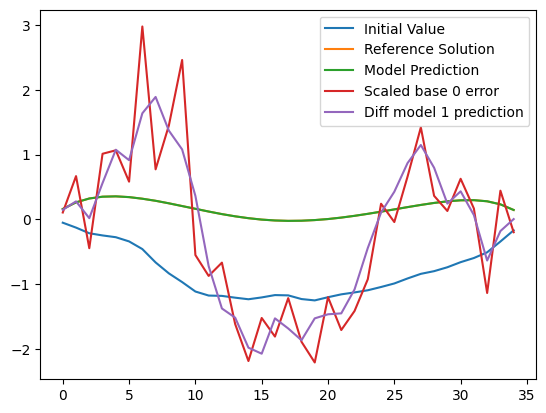

--------------------------------------RUN 29 --------------------------------------
Generated opt_params  25
0  :  7.467e-06
10  :  2.028e-06
20  :  1.23e-06
30  :  1.232e-06
40  :  9.732e-07
50  :  8.46e-07
60  :  7.303e-07
70  :  6.27e-07
80  :  5.71e-07
90  :  5.364e-07
100  :  4.589e-07
110  :  4.269e-07
120  :  4.028e-07
130  :  3.627e-07
140  :  3.559e-07
150  :  3.201e-07
160  :  3.118e-07
170  :  2.949e-07
180  :  2.754e-07
190  :  2.758e-07
200  :  2.662e-07
210  :  2.55e-07
220  :  2.605e-07
230  :  2.564e-07
240  :  2.48e-07
250  :  2.383e-07
260  :  2.43e-07
270  :  2.28e-07
280  :  2.239e-07
290  :  2.347e-07
300  :  2.129e-07
310  :  2.196e-07
320  :  2.283e-07
330  :  2.148e-07
340  :  2.172e-07
350  :  2.111e-07
360  :  2.088e-07
370  :  2.101e-07
380  :  2.094e-07
390  :  2.041e-07
400  :  1.971e-07
410  :  1.994e-07
420  :  1.972e-07
430  :  1.997e-07
440  :  1.962e-07
450  :  1.991e-07
460  :  1.967e-07
470  :  1.843e-07
480  :  1.924e-07
490  :  1.883e-07
500  :  1.

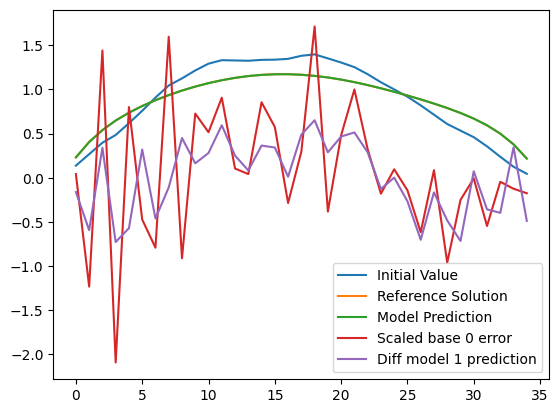

--------------------------------------RUN 30 --------------------------------------
Generated opt_params  26
0  :  3.652e-06
10  :  2.701e-06
20  :  2.383e-06
30  :  2.068e-06
40  :  1.791e-06
50  :  1.587e-06
60  :  1.376e-06
70  :  1.363e-06
80  :  1.196e-06
90  :  1.22e-06
100  :  1.174e-06
110  :  1.065e-06
120  :  1.005e-06
130  :  1.067e-06
140  :  8.807e-07
150  :  9.876e-07
160  :  9.585e-07
170  :  8.436e-07
180  :  8.188e-07
190  :  8.056e-07
200  :  7.629e-07
210  :  7.403e-07
220  :  7.298e-07
230  :  6.947e-07
240  :  7.084e-07
250  :  6.423e-07
260  :  6.701e-07
270  :  6.6e-07
280  :  6.519e-07
290  :  5.838e-07
300  :  6.112e-07
310  :  5.873e-07
320  :  6.169e-07
330  :  5.892e-07
340  :  6.039e-07
350  :  5.609e-07
360  :  4.849e-07
370  :  5.498e-07
380  :  5.546e-07
390  :  5.461e-07
400  :  5.326e-07
410  :  4.904e-07
420  :  5.24e-07
430  :  4.964e-07
440  :  5.077e-07
450  :  5.048e-07
460  :  4.672e-07
470  :  4.881e-07
480  :  4.888e-07
490  :  4.895e-07
500  :

3530  :  0.3121
3540  :  0.3128
3550  :  0.3108
3560  :  0.3096
3570  :  0.307
3580  :  0.3071
3590  :  0.3148
3600  :  0.3126
3610  :  0.3109
3620  :  0.3089
3630  :  0.3116
3640  :  0.3188
3650  :  0.3128
3660  :  0.3118
3670  :  0.3109
3680  :  0.3103
3690  :  0.3056
3700  :  0.3106
3710  :  0.3081
3720  :  0.3127
3730  :  0.3066
3740  :  0.3125
3750  :  0.3086
3760  :  0.3128
3770  :  0.3082
3780  :  0.3065
    New learning rate:  8e-05
3790  :  0.3062
3800  :  0.3106
3810  :  0.3045
3820  :  0.3071
3830  :  0.3079
3840  :  0.3053
3850  :  0.3129
3860  :  0.3162
3870  :  0.3067
3880  :  0.3091
3890  :  0.3081
3900  :  0.3069
3910  :  0.3122
3920  :  0.3037
3930  :  0.3118
3940  :  0.3098
3950  :  0.3029
3960  :  0.305
3970  :  0.3067
3980  :  0.3074
3990  :  0.3156
4000  :  0.3078
4010  :  0.3145
4020  :  0.3085
4030  :  0.3093
4040  :  0.3026
4050  :  0.3141
4060  :  0.3102
4070  :  0.3
4080  :  0.313
4090  :  0.3119
4100  :  0.3107
    New learning rate:  1.6000000000000003e-05
4

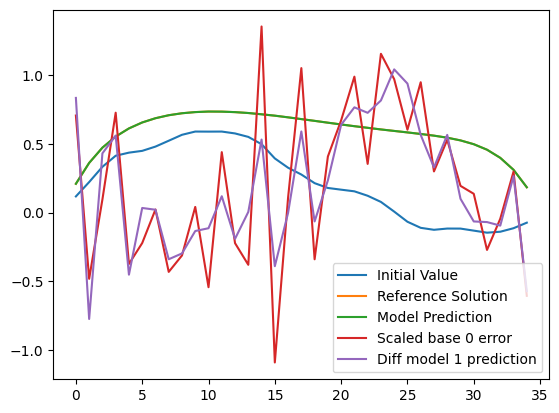

--------------------------------------RUN 31 --------------------------------------
Generated opt_params  27
0  :  8.345e-06
10  :  2.564e-06
20  :  1.677e-06
30  :  1.672e-06
40  :  1.255e-06
50  :  1.11e-06
60  :  9.806e-07
70  :  8.893e-07
80  :  7.663e-07
90  :  7.022e-07
100  :  6.521e-07
110  :  5.565e-07
120  :  5.765e-07
130  :  5.353e-07
140  :  5.023e-07
150  :  4.606e-07
160  :  4.501e-07
170  :  4.344e-07
180  :  4.086e-07
190  :  4.127e-07
200  :  3.73e-07
210  :  3.727e-07
220  :  3.778e-07
230  :  3.516e-07
240  :  3.5e-07
250  :  3.531e-07
260  :  3.336e-07
270  :  3.436e-07
280  :  3.234e-07
290  :  3.196e-07
300  :  3.201e-07
310  :  3.208e-07
320  :  3.254e-07
330  :  3.2e-07
340  :  3.114e-07
350  :  3.158e-07
360  :  3.066e-07
370  :  3.06e-07
380  :  2.979e-07
390  :  3.024e-07
400  :  2.944e-07
410  :  2.961e-07
420  :  2.956e-07
430  :  2.932e-07
440  :  2.935e-07
450  :  2.881e-07
460  :  2.883e-07
470  :  2.81e-07
480  :  2.823e-07
490  :  2.889e-07
500  :  2.

In [ ]:
next_step_decider = LIRK2_uniform_sampler(opt_p1_low, opt_p1_high, opt_p2_low, opt_p2_high, opt_nr_of_runs)

base_models = []
full_models = []
opt_params = []
opt_start_errors = []
opt_end_errors_base = []
opt_end_errors = []
base_traintimes = []
diff_traintimes = []


#Store the results
opt_foldername = "Results_opt"
opt_foldername_full = os.getcwd() + "/" + opt_foldername #for shutil.copyfile
if not os.path.exists(opt_foldername):
        os.makedirs(opt_foldername)

with open(opt_foldername + '/opt_simulation_results.txt', 'w+') as f:
    start_time = time.perf_counter()
    
    current_run_nr = 0
    while current_run_nr < opt_nr_of_runs:
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)
        
        this_run_base_nr, new_opt_params = next_step_decider(opt_end_errors)        
        
        if this_run_base_nr == -1:
            this_run_base_nr = len(base_models)
            
            print("Generated opt_params ", this_run_base_nr, file = f)
            print("Generated opt_params ", this_run_base_nr)
            
            new_base_model = base_model_class(T, pde, nr_spacediscr, nr_timesteps, new_opt_params, training_samples_generator, learning_rate = base_initial_lr)
            
            start_error = evaluate(new_base_model, evaluate_samples = end_eval_samples) 
            csv_summary(new_base_model, opt_foldername + "/Z_start_error_" + str(this_run_base_nr))

            base_traintime = whole_training(new_base_model, 
                                            base_initial_lr, 
                                            base_initial_batchsize, 
                                            base_tolerance, 
                                            base_max_trainsteps, 
                                            evaluate_steps = eval_steps, 
                                            evaluate_samples = eval_samples)
            
            end_error_base = evaluate(new_base_model, evaluate_samples = end_eval_samples)
            csv_summary(new_base_model, opt_foldername + "/Z_end_error_base_" + str(this_run_base_nr))            
            
            base_models = base_models + [new_base_model]
            opt_params = opt_params + [new_opt_params]
            opt_start_errors = opt_start_errors + [start_error]
            opt_end_errors_base = opt_end_errors_base + [end_error_base]
            opt_end_errors = opt_end_errors + [[]]
            base_traintimes = base_traintimes + [base_traintime]
            diff_traintimes = diff_traintimes + [[]]
            full_models = full_models + [[]]
            
        else:
            print("Use opt_params ", this_run_base_nr, " for the ", len(opt_end_errors[this_run_base_nr])+1, "th time", file = f)
            print("Use opt_params ", this_run_base_nr, " for the ", len(opt_end_errors[this_run_base_nr])+1, "th time")
            
    
        difference_learning_model = Difference_learning_model(T, 
                                                              pde, 
                                                              nr_spacediscr,
                                                              base = base_models[this_run_base_nr], 
                                                              nr_timesteps_base = 0,
                                                              params_base = None, 
                                                              diff_classes = [diff_model_class], 
                                                              diff_params = [diff_model_params], 
                                                              training_samples_generator = training_samples_generator)
        
        
        base_traintime, diff_traintime = multi_difference_model_training(difference_learning_model, 
                                                                        initial_learning_rates = [base_initial_lr, diff_initial_lr], 
                                                                        initial_batch_sizes = [base_initial_batchsize, diff_initial_batchsize], 
                                                                        tolerances = [base_tolerance, diff_tolerance], 
                                                                        max_trainsteps = [0, diff_max_trainsteps], 
                                                                        evaluate_steps = eval_steps, 
                                                                        estimate_samples = est_samples,
                                                                        evaluate_samples = eval_samples)
        
        end_error = evaluate(difference_learning_model, evaluate_samples = end_eval_samples)   
        csv_summary(difference_learning_model, opt_foldername + "/Z_end_error_" + str(this_run_base_nr) + "_" + str(len(opt_end_errors[this_run_base_nr])))
        
        opt_end_errors[this_run_base_nr] = opt_end_errors[this_run_base_nr] + [end_error]
        diff_traintimes[this_run_base_nr] = diff_traintimes[this_run_base_nr] + [diff_traintime]
        full_models[this_run_base_nr] = full_models[this_run_base_nr] + [difference_learning_model]

        summary(difference_learning_model, multidiff_model = True, write_file = f, plot_file_name = opt_foldername + "/Z_plot_" + str(this_run_base_nr) + "_" + str(len(opt_end_errors[this_run_base_nr])))
        print("\n\n", file = f)
        
        current_run_nr = current_run_nr + 1
    
    
    best_start = opt_start_errors.index(min(opt_start_errors))
    best_trained_base = opt_end_errors_base.index(min(opt_end_errors_base))
    best_full_adann = minimal_index(opt_end_errors)
    
    total_time = time.perf_counter() - start_time 
    
    #Remember best model
    best_full_adann_model = full_models[best_full_adann[0]][best_full_adann[1]]
    
    #Copy best error files
    shutil.copyfile(opt_foldername + "/Z_start_error_" + str(best_start) + ".csv", opt_foldername + "/opt_best_start_error_" + str(best_start) + ".csv")
    shutil.copyfile(opt_foldername + "/Z_end_error_base_" + str(best_trained_base) + ".csv", opt_foldername + "/opt_best_end_error_base_" + str(best_trained_base) + ".csv")
    shutil.copyfile(opt_foldername + "/Z_end_error_" + str(best_full_adann[0]) + "_" + str(best_full_adann[1]) + ".csv", opt_foldername + "/opt_best_end_error_" + str(best_full_adann[0]) + "_" + str(best_full_adann[1]) + ".csv")

    
    #Print some summary values
    
    print("\n\n\n--------------------------------------", file = f)
    
    print("Best errors:", file = f)
    print("    Best start: ", opt_start_errors[best_start], "(" + str(best_start) + ")", file = f)
    print("    Best trained base: ", opt_end_errors_base[best_trained_base], "(" + str(best_trained_base) + ")", file = f)
    print("    Best full ADANN: ", opt_end_errors[best_full_adann[0]][best_full_adann[1]], best_full_adann, file = f)
    
    
    print("\nTrain times:", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", np.sum(base_traintimes) + np.sum([np.sum(times) for times in diff_traintimes]), file = f)
    print("    Total base train time: ", np.sum(base_traintimes), file = f)
    print("    Total diff train time: ", np.sum([np.sum(times) for times in diff_traintimes]), file = f)
    print("\n    Average base train time: ", np.mean(base_traintimes), file = f)
    print("    Average diff train time: ",np.sum([np.sum(times) for times in diff_traintimes])/opt_nr_of_runs, file = f)


    
with open(opt_foldername + "/Y_opt_params.txt", 'w+') as f:
    print(opt_params, file = f)
with open(opt_foldername + "/Y_opt_start_errors.txt", 'w+') as f:
    print(opt_start_errors, file = f)
with open(opt_foldername + "/Y_opt_end_errors_base.txt", 'w+') as f:
    print(opt_end_errors_base, file = f)
with open(opt_foldername + "/Y_opt_end_errors.txt", 'w+') as f:
    print(opt_end_errors, file = f)

In [ ]:
start_errors_stretched = [[opt_start_errors[i] for _ in range(len(opt_end_errors[i]))] for i in range(len(opt_end_errors))]
end_errors_base_stretched = [[opt_end_errors_base[i] for _ in range(len(opt_end_errors[i]))] for i in range(len(opt_end_errors))]

lengths = [len(errors) for errors in opt_end_errors]
line_locations = np.cumsum(lengths)

plt.figure()
for l in line_locations[:-1]:
    plt.axvline(x = l - 0.5, color = 'navajowhite')
plt.semilogy([classical_reference_error for ss in start_errors_stretched for s in ss], label = "Classical approx. error")
plt.semilogy([s for ss in start_errors_stretched for s in ss], label = "Start errors")
plt.semilogy([s for ss in end_errors_base_stretched for s in ss], label = "Trained base errors")
plt.semilogy([s for ss in opt_end_errors for s in ss], label = "Trained full ADANN errors")
plt.xlabel("Run number")
plt.ylabel("Estimated " + r'$L^2$'+ "-error")
plt.legend(loc = "upper left")
plt.savefig(opt_foldername + "/opt_end_errors.pdf")
plt.show()

#### ANN Experiment

In [ ]:
ann_errors = []
train_times = []
ann_models = []

#Create forlder to store results
ann_foldername = "Results_ANN"
if not os.path.exists(ann_foldername):
    os.makedirs(ann_foldername)


#Run the experiment
start_time = time.perf_counter() 
with open(ann_foldername + '/ANN_simulation_results.txt', 'w+') as f:
    for current_run_nr in range(ann_nr_of_runs):
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)

        ann_model = ANN_Model(layer_dims, training_samples_generator)

        train_time = whole_training(ann_model, ann_initial_lr, ann_initial_batchsize, tolerance = ann_tolerance, max_trainsteps = ann_max_trainsteps, evaluate_steps = eval_steps, evaluate_samples = eval_samples)
        error = evaluate(ann_model, end_eval_samples)

        ann_errors = ann_errors + [error]
        train_times = train_times + [train_time]
        ann_models = ann_models + [ann_model]
        
        summary(ann_model, write_file=f, plot_file_name = ann_foldername + "/ANN_plot_" + str(current_run_nr))
        print("\n\n", file = f)
    
    best_ann_index = ann_errors.index(min(ann_errors))
    best_ann_model = ann_models[best_ann_index]
    csv_summary(best_ann_model, ann_foldername + "/ANN_best_error")

    total_time = time.perf_counter() - start_time 
    


    print("\n\n\n--------------------------------------\nTrain times:", file = f)
    print("    Best error: ", ann_errors[best_ann_index], "(" + str(best_ann_index) + ")", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", sum(train_times), file = f)


    
with open(ann_foldername + "/Y_ann_errors.txt", 'w+') as f:
    print(ann_errors, file = f)

#### FNO Experiment

In [ ]:
fno_errors = []
train_times = []
fno_models = []

#Store the results
fno_foldername = "Results_FNO"
if not os.path.exists(fno_foldername):
    os.makedirs(fno_foldername)


#Run the experiment
start_time = time.perf_counter() 
with open(fno_foldername + '/FNO_simulation_results.txt', 'w+') as f:

    for current_run_nr in range(fno_nr_of_runs):
        
        print("--------------------------------------RUN", current_run_nr, "--------------------------------------")
        print("--------------------------------------RUN", str(current_run_nr) + "--------------------------------------", file = f)

        fno_model = FNO_Model([nr_fourier_modes, width, depth], training_samples_generator)

        train_time = whole_training(fno_model, fno_initial_lr, fno_initial_batchsize, tolerance = fno_tolerance, max_trainsteps = fno_max_trainsteps, evaluate_steps = eval_steps, evaluate_samples = eval_samples)
        error = evaluate(fno_model, end_eval_samples)

        fno_errors = fno_errors + [error]
        train_times = train_times + [train_time]
        fno_models = fno_models + [fno_model]
        
        summary(fno_model, write_file=f, plot_file_name = fno_foldername + "/FNO_plot_" + str(current_run_nr))
        print("\n\n", file = f)
    
    best_fno_index = fno_errors.index(min(fno_errors))
    best_fno_model = fno_models[best_fno_index]
    csv_summary(best_fno_model, fno_foldername + "/FNO_best_error")

    total_time = time.perf_counter() - start_time 
    


    print("\n\n\n--------------------------------------\nTrain times:", file = f)
    print("    Best error: ", fno_errors[best_fno_index], "(" + str(best_fno_index) + ")", file = f)
    print("    Total time : ", total_time, file = f)
    print("    Total train time: ", sum(train_times), file = f)


with open(fno_foldername + "/Y_fno_errors.txt", 'w+') as f:
    print(fno_errors, file = f)

### Final plot

In [ ]:
#Store the results
plots_foldername = "Results_plots"
if not os.path.exists(plots_foldername):
    os.makedirs(plots_foldername)

x_values = pde.x_values(nr_spacediscr)

initial_values, reference_solutions, finer_initial_values = training_samples_generator.generate(1, finer_resolution = True)

best_adann_predictions = best_full_adann_model(initial_values)
scaled_base_model_errors = best_full_adann_model.difference_models[0].training_samples_generator.get_label(initial_values, finer_initial_values)
difference_predictions = best_full_adann_model.difference_models[0](initial_values)

ann_predictions = best_ann_model(initial_values)
fno_prediction = best_fno_model(initial_values)


plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, scaled_base_model_errors[0], label = "Scaled base model error")
plt.plot(x_values, difference_predictions[0], label = "Difference model")
plt.plot(x_values, best_adann_predictions[0], label = "Best full ADANN Prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_ADANN.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, ann_predictions[0], label = "ANN prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_ANN.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, fno_prediction[0], label = "FNO prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_FNO.pdf", bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(x_values, initial_values[0], label = "Initial Value")
plt.plot(x_values, reference_solutions[0], label = "Reference Solution")

plt.plot(x_values, scaled_base_model_errors[0], label = "Scaled base model error")
plt.plot(x_values, difference_predictions[0], label = "Difference model")
plt.plot(x_values, best_adann_predictions[0], label = "Best full ADANN Prediction")

plt.plot(x_values, ann_predictions[0], label = "ANN prediction")
plt.plot(x_values, fno_prediction[0], label = "FNO prediction")

plt.legend(loc = "lower right")
# plt.title("Error plot", fontsize=10)
plt.savefig(plots_foldername + "/Results_approx_error_plot_together.pdf", bbox_inches='tight')
plt.show()


### Testing zone